In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np
from matplotlib.patches import Rectangle
import pylab as plt
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Our amputed dataset

In [21]:
dataset_dir = r'C:\Users\Asus\Downloads\transformed_mnist\transformed_mnist'

image_files = os.listdir(dataset_dir)

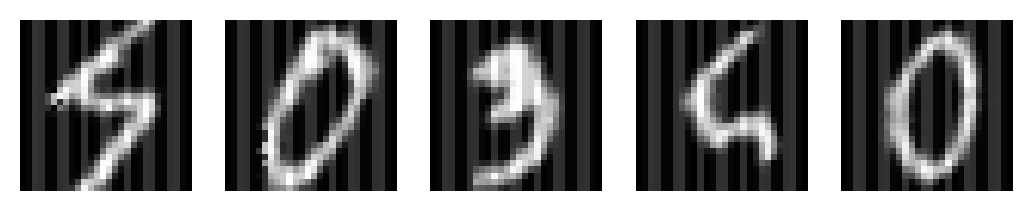

In [22]:
image_files = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]

for i, img_file in enumerate(image_files[:5]):  # Visualise first 5 images
    img_path = os.path.join(dataset_dir, img_file)
    
    try:
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1) 
        plt.imshow(img, cmap='gray')  # 'gray' for grayscale images
        plt.axis('off') 
    except Exception as e:
        print(f"Error opening {img_file}: {e}")

plt.show()

# Obtaining missing dataset (their code)

"BlockMaskedMNIST" creates an incomplete MNIST dataset by turning each image
in MNIST into a pair of a partially-observed image (FloatTensor)
and a mask (CharTensor), which both have size (1, 28, 28).
Note that the range of pixel values of each image is rescaled to \[0,1\].

### With a sample of the data

In [13]:
# class BlockMaskedMNIST(Dataset):
#     def __init__(self, block_len, data_dir='src/mnist-data', random_seed=0):
#         self.block_len = block_len
#         self.rnd = np.random.RandomState(random_seed)

#         # Load full MNIST dataset
#         full_data = datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())

#         # Sample 10 images per digit (0-9)
#         self.data_size = 10 * 10  # 10 samples for each of the 10 digits
#         self.data = self.sample_10_per_digit(full_data)

#         self.generate_incomplete_data(self.data)

#     def sample_10_per_digit(self, full_data):
#         # Create lists to hold sampled data and labels
#         sampled_data = []

#         for digit in range(10):
#             # Get all indices of the current digit
#             digit_indices = [i for i, label in enumerate(full_data.targets) if label == digit]
#             # Randomly select 10 indices
#             sampled_indices = np.random.choice(digit_indices, 10, replace=False)
#             # Add the selected data to the list
#             sampled_data.extend([full_data[i] for i in sampled_indices])

#         return sampled_data

#     def __getitem__(self, index):
#         # return index so we can retrieve the mask location from self.mask_loc
#         return self.image[index], self.mask[index], index

#     def __len__(self):
#         return self.data_size

#     def generate_incomplete_data(self, data):
#         n_masks = self.data_size
#         self.image = [None] * n_masks
#         self.mask = [None] * n_masks
#         self.mask_loc = [None] * n_masks

#         for i in range(n_masks):
#             d0 = self.rnd.randint(0, 28 - self.block_len + 1)
#             d1 = self.rnd.randint(0, 28 - self.block_len + 1)
#             mask = torch.zeros((28, 28), dtype=torch.uint8)
#             mask[d0:(d0 + self.block_len), d1:(d1 + self.block_len)] = 1
#             self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
#             self.mask_loc[i] = d0, d1, self.block_len, self.block_len
#             # Mask out missing pixels by zero
#             self.image[i] = data[i][0] * mask.float()


# # THIS IS WHAT WE NEED TO CHANGE FOR OUR AMPUTED MNIST DATASET <----------------
# sampled_data = BlockMaskedMNIST(block_len=12)
# batch_size = 64
# data_loader = DataLoader(sampled_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Our dataset

In [28]:
# import os
# from PIL import Image
# import torch

# class CustomImageDataset(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.image_dir = image_dir
#         self.image_files = os.listdir(image_dir)
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_dir, self.image_files[idx])
#         image = Image.open(img_name)

#         if self.transform:
#             image = self.transform(image)

#         return image
    
# transform = None 
# image_dataset = CustomImageDataset(dataset_dir, transform)

# batch_size = 64
# data_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [44]:
class TransformedMNISTDataset(Dataset):
    def __init__(self, image_dir, transform=None, mask_mode=False): #
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        self.mask_mode = mask_mode  

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_files[index])
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        if self.mask_mode:
            mask = torch.randint(0, 2, img.size(), dtype=torch.float32)  # Random binary mask
        else:
            mask = torch.ones_like(img)  # Default to a mask that selects everything (no missing data)

        return img, mask


In [63]:
image_dir = r'C:\Users\Asus\Downloads\transformed_mnist 2\transformed_mnist'
batch_size = 64
transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.ToTensor()    
])
dataset = TransformedMNISTDataset(image_dir=image_dir, transform=transform, mask_mode=True) #
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Plotting images in a grid

In [39]:
def plot_grid(ax, image, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8,
              title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = 28
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))
            
    if title:
        ax.set_title(title)

### Masking operator

Implementation of the masking operator
$f_\tau(\mathbf{x}, \mathbf{m}) = \mathbf{x} \odot \mathbf{m} + \tau\bar{\mathbf{m}}$.

An incomplete data instance can be represented as
a pair of fixed-length vectors $(\mathbf{x}, \mathbf{m})$.
The masking operator transforms an incomplete data instance into a vector of
the same size with all missing entries in $\mathbf{x}$ replaced by a constant
value $\tau$.

In [40]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

In [ ]:
# Visualization of the incomplete dataset
# data_samples, mask_samples, _ = next(iter(data_loader))
# fig, ax = plt.subplots(figsize=(12, 3))
# plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
#           nrow=4, ncol=16)

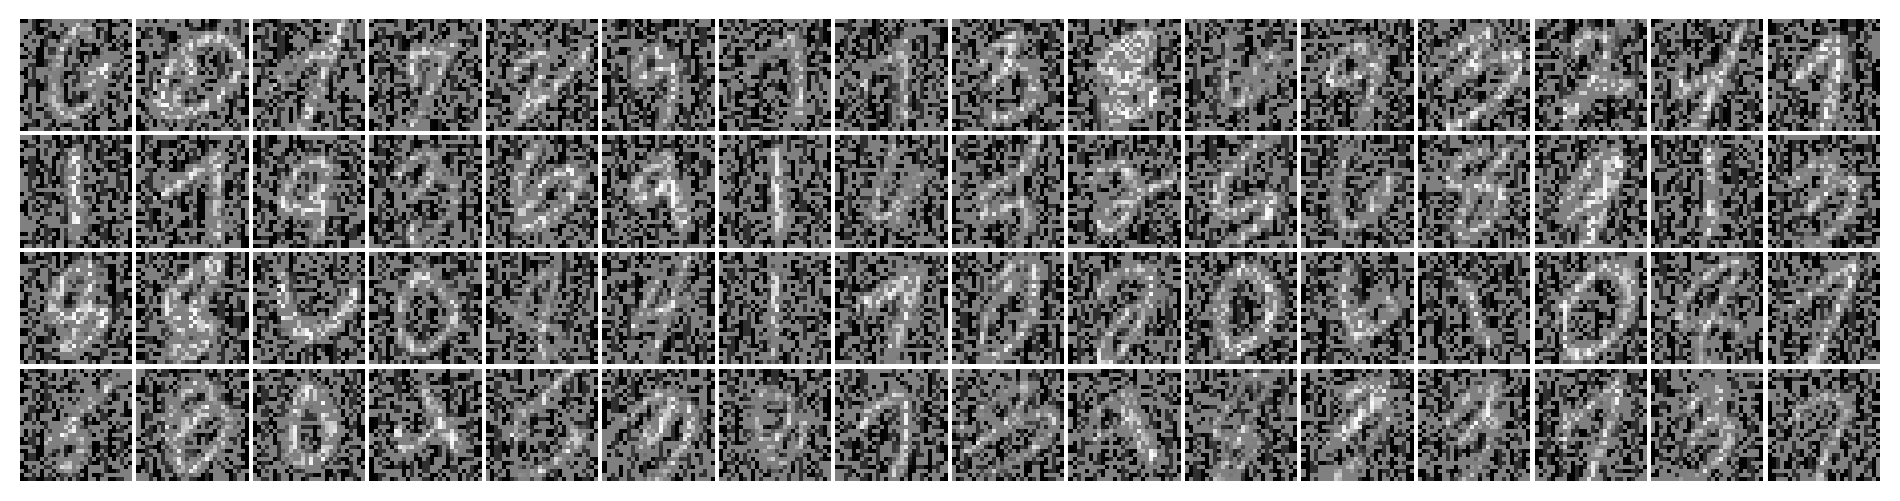

In [64]:
# Visualization of the incomplete dataset
data_samples, mask_samples = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
          nrow=4, ncol=16)

# With a sample of the data

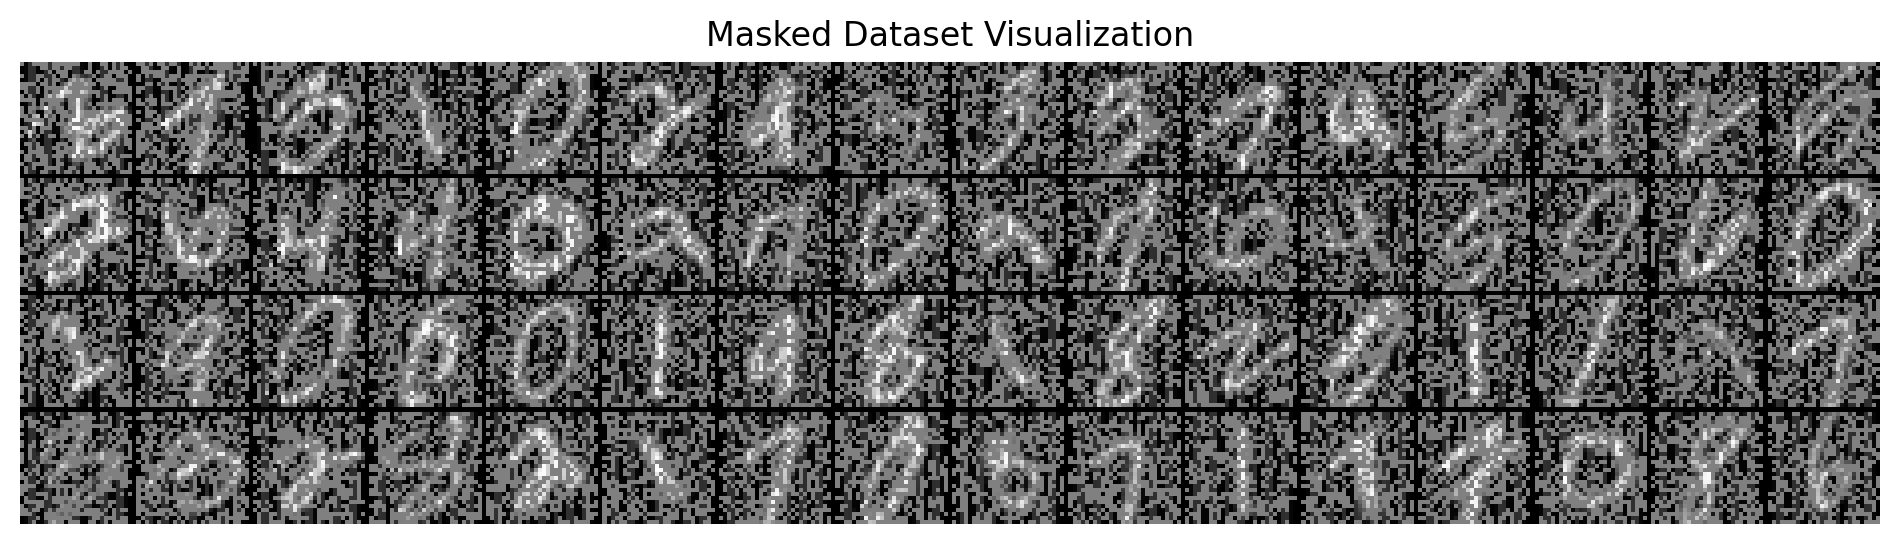

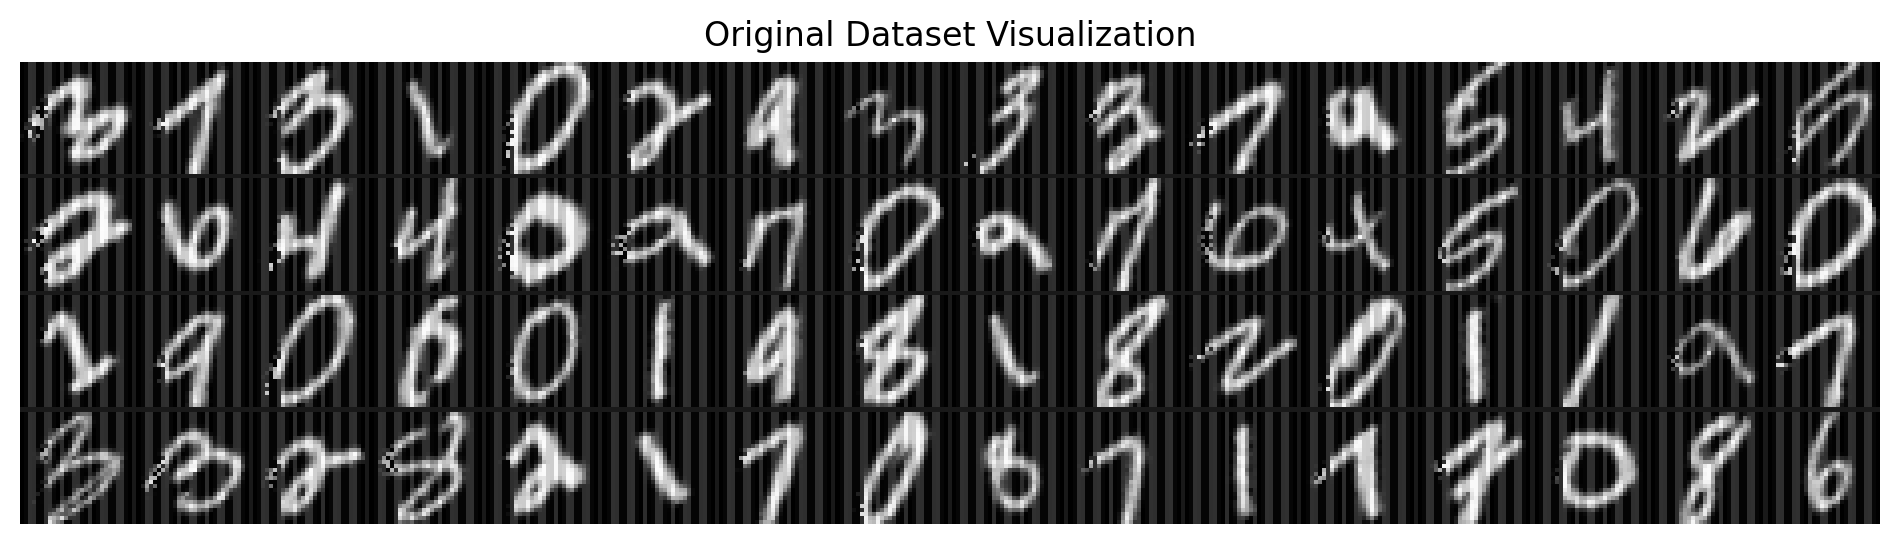

In [83]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class TransformedMNISTDataset(Dataset):
    def __init__(self, image_dir, transform=None, mask_mode=False, sample_fraction=0.1):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # samples to keep
        sample_size = int(len(self.image_files) * sample_fraction)
        
        # select randomly the images to sample
        self.image_files = random.sample(self.image_files, sample_size)

        self.transform = transform
        self.mask_mode = mask_mode 

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_files[index])
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        if self.mask_mode:
            mask = torch.randint(0, 2, img.size(), dtype=torch.float32) 
        else:
            mask = torch.ones_like(img)  

        return img, mask

image_dir = r'C:\Users\Asus\Downloads\transformed_mnist\transformed_mnist'
batch_size = 64
transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.ToTensor()    
])


dataset = TransformedMNISTDataset(image_dir=image_dir, transform=transform, mask_mode=True, sample_fraction=0.1)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

data_samples, mask_samples = next(iter(data_loader))

fig, ax = plt.subplots(figsize=(12, 3))
masked_data = mask_data(data_samples, mask_samples.float(), .5)
plot_grid(ax, masked_data, nrow=4, ncol=16)
plt.title("Masked Dataset Visualization")
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, data_samples, nrow=4, ncol=16)
plt.title("Original Dataset Visualization")
plt.show()

# MisGAN

Two generators
* Data Generator (Gx) --> Generates complete data
* Mask Generator (Gm) --> Models which parts of the data are missing

These two generators are trained together with tro discriminators (Dx and Dm) that try to distinguish between real and generated data, as well as real and generated missing masks.

### Generator
* "ConvDataGenerator" implements the data generator $G_x$.
Since the pixel values are in \[0, 1\], we apply the sigmoid activation to
the real-valued output at the end.
* "ConvMaskGenerator" implements the mask generator $G_m$.
Note that the masks are binary-valued.

In [48]:
# Must sub-class ConvGenerator to provide transform()
class ConvGenerator(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()

        self.DIM = 64
        self.latent_size = latent_size

        self.preprocess = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 4 * self.DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * self.DIM, 2 * self.DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.DIM, self.DIM, 5),
            nn.ReLU(True),
        )
        self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 8, stride=2)

    def forward(self, input):
        net = self.preprocess(input)
        net = net.view(-1, 4 * self.DIM, 4, 4)
        net = self.block1(net)
        net = net[:, :, :7, :7]
        net = self.block2(net)
        net = self.deconv_out(net)
        return self.transform(net).view(-1, 1, 28, 28)


class ConvDataGenerator(ConvGenerator):
    def __init__(self, latent_size=128):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x)


class ConvMaskGenerator(ConvGenerator):
    def __init__(self, latent_size=128, temperature=.66):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x / temperature)

### Discriminator

Implementing the discriminator in "ConvCritic" with three convolutional layers followed by
a linear layer for both $D_x$ and $D_m$.

In [49]:
class ConvCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.DIM = 64
        main = nn.Sequential(
            nn.Conv2d(1, self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(self.DIM, 2 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2 * self.DIM, 4 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4 * 4 * 4 * self.DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        net = self.main(input)
        net = net.view(-1, 4 * 4 * 4 * self.DIM)
        net = self.output(net)
        return net.view(-1)

### Training GAN with Gradient Penalty

They used Wasserstein GAN to train MisGAN. "CriticUpdater" computes the loss of the discriminator and updates its parameters accordingly.
* [WGAN-GP](https://arxiv.org/abs/1704.00028) procedure to train discriminators with the gradient penalty.

In [50]:
class CriticUpdater:
    def __init__(self, critic, critic_optimizer, batch_size=64, gp_lambda=10):
        self.critic = critic
        self.critic_optimizer = critic_optimizer
        self.gp_lambda = gp_lambda
        # Interpolation coefficient
        self.eps = torch.empty(batch_size, 1, 1, 1, device=device)
        # For computing the gradient penalty
        self.ones = torch.ones(batch_size).to(device)

    def __call__(self, real, fake):
        real = real.detach()
        fake = fake.detach()
        self.critic.zero_grad()
        self.eps.uniform_(0, 1)
        interp = (self.eps * real + (1 - self.eps) * fake).requires_grad_()
        grad_d = grad(self.critic(interp), interp, grad_outputs=self.ones,
                      create_graph=True)[0]
        grad_d = grad_d.view(real.shape[0], -1)
        grad_penalty = ((grad_d.norm(dim=1) - 1)**2).mean() * self.gp_lambda
        w_dist = self.critic(fake).mean() - self.critic(real).mean()
        loss = w_dist + grad_penalty
        loss.backward()
        self.critic_optimizer.step()

Now, instantiate all the building blocks for MisGAN: the data/mask
generators and their corresponding discriminators.
* The Adam optimizer is used to train them.

In [51]:
nz = 128   # dimensionality of the latent code
n_critic = 5
alpha = .2

data_gen = ConvDataGenerator().to(device)
mask_gen = ConvMaskGenerator().to(device)

data_critic = ConvCritic().to(device)
mask_critic = ConvCritic().to(device)

data_noise = torch.empty(batch_size, nz, device=device)
mask_noise = torch.empty(batch_size, nz, device=device)

lrate = 1e-4
data_gen_optimizer = optim.Adam(
    data_gen.parameters(), lr=lrate, betas=(.5, .9))
mask_gen_optimizer = optim.Adam(
    mask_gen.parameters(), lr=lrate, betas=(.5, .9))

data_critic_optimizer = optim.Adam(
    data_critic.parameters(), lr=lrate, betas=(.5, .9))
mask_critic_optimizer = optim.Adam(
    mask_critic.parameters(), lr=lrate, betas=(.5, .9))

update_data_critic = CriticUpdater(
    data_critic, data_critic_optimizer, batch_size)
update_mask_critic = CriticUpdater(
    mask_critic, mask_critic_optimizer, batch_size)

### Training MisGAN

Epoch: 29


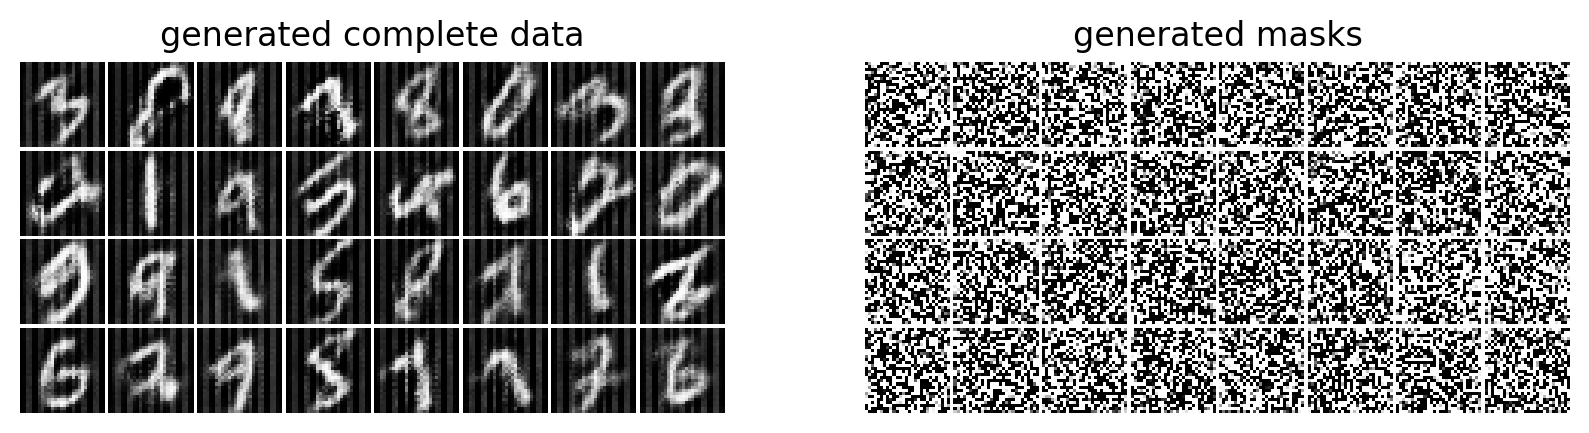

Epoch: 59


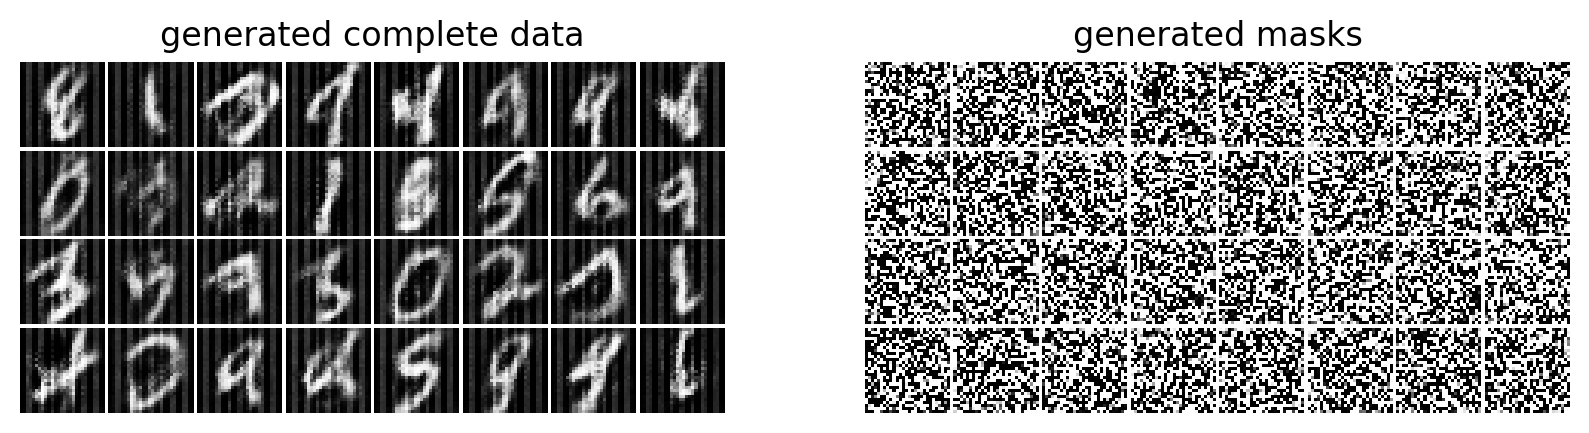

Epoch: 89


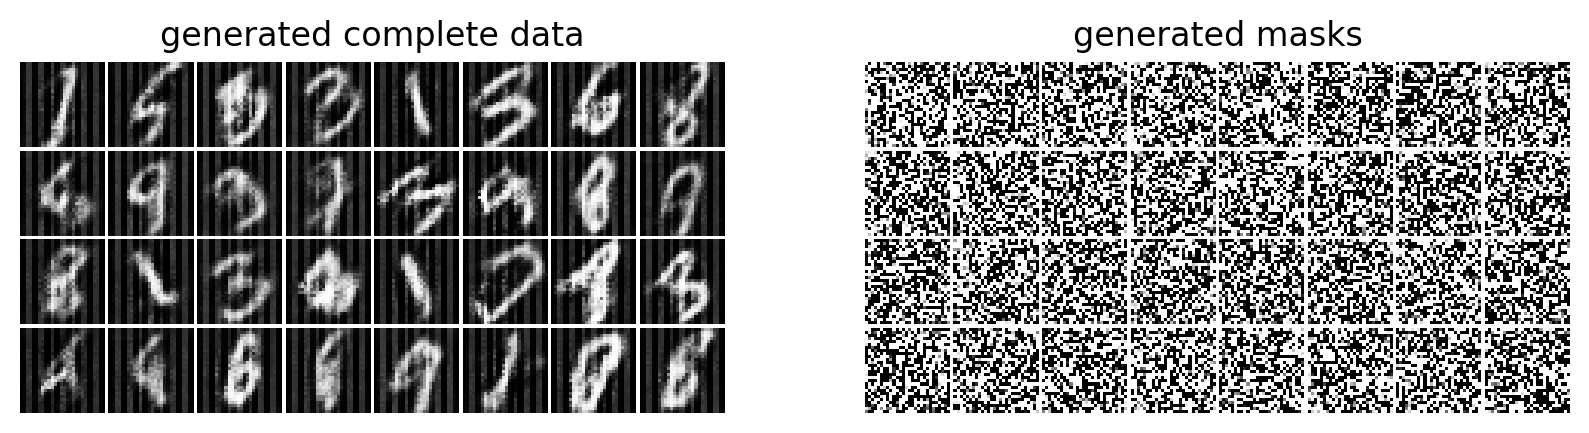

Epoch: 119


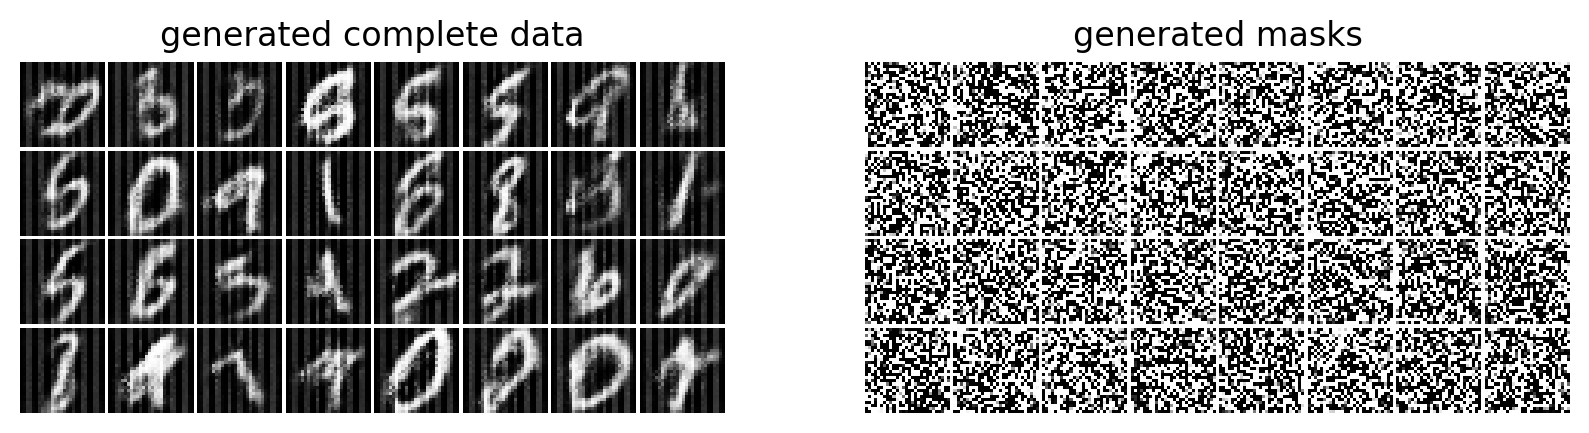

Epoch: 149


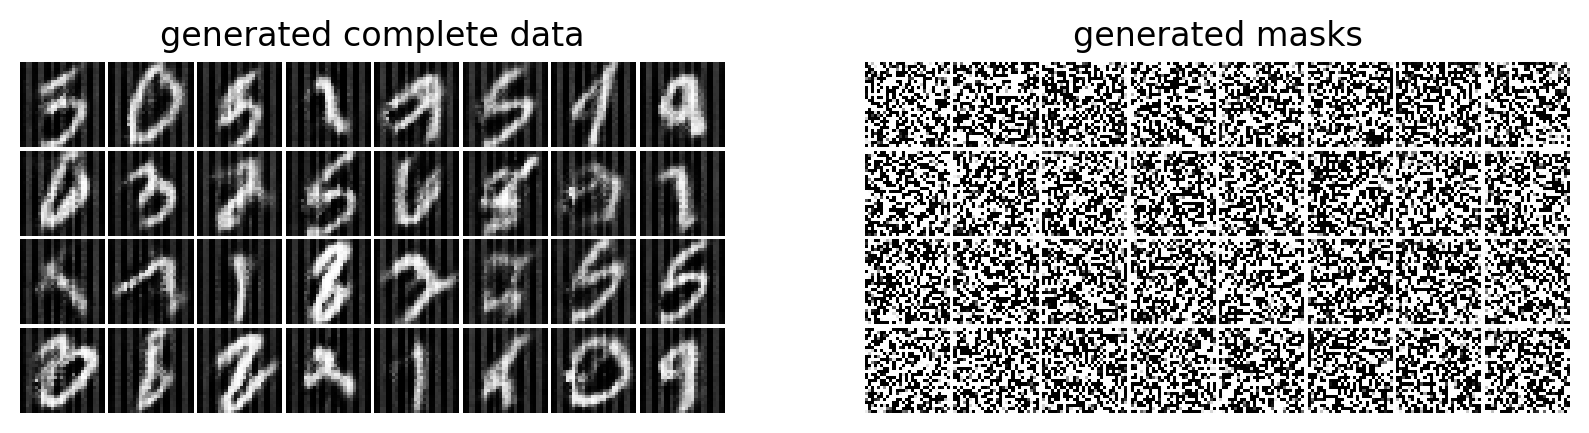

Epoch: 179


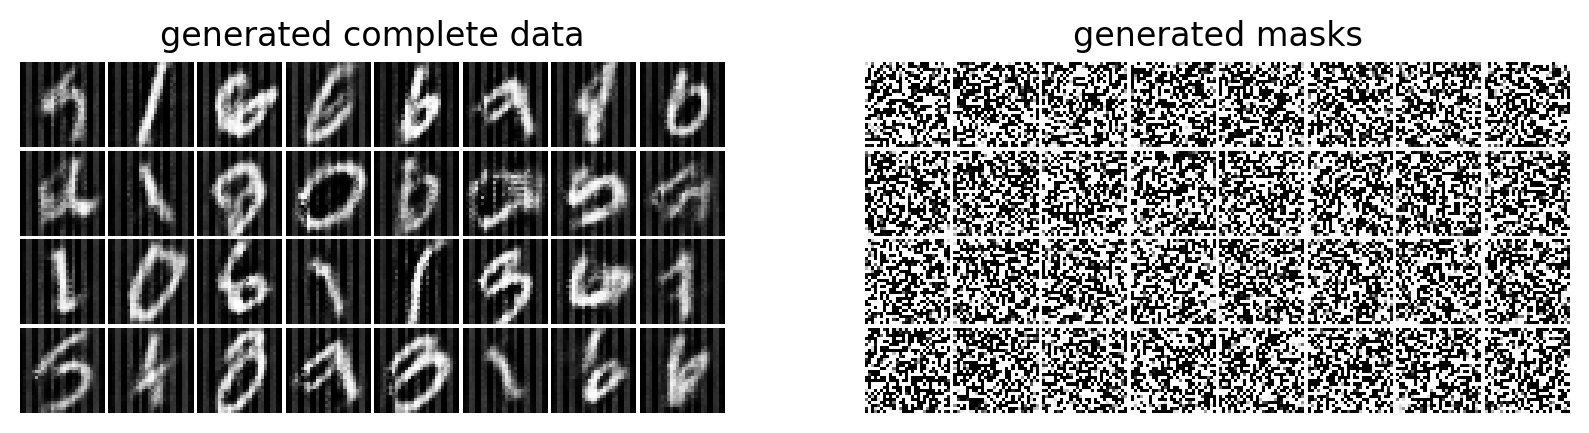

Epoch: 209


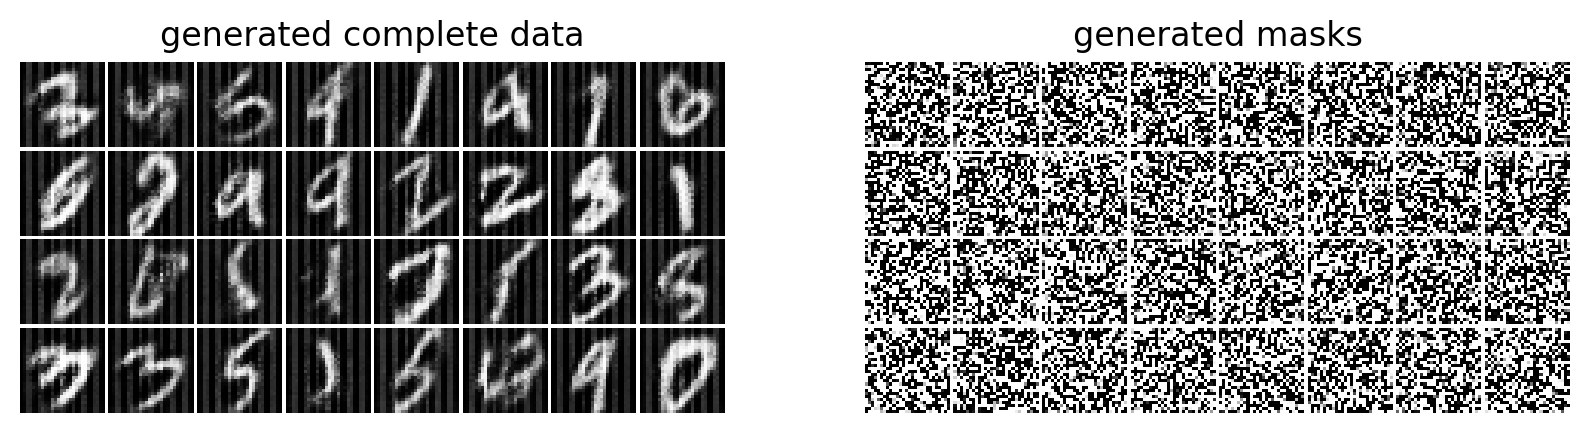

Epoch: 239


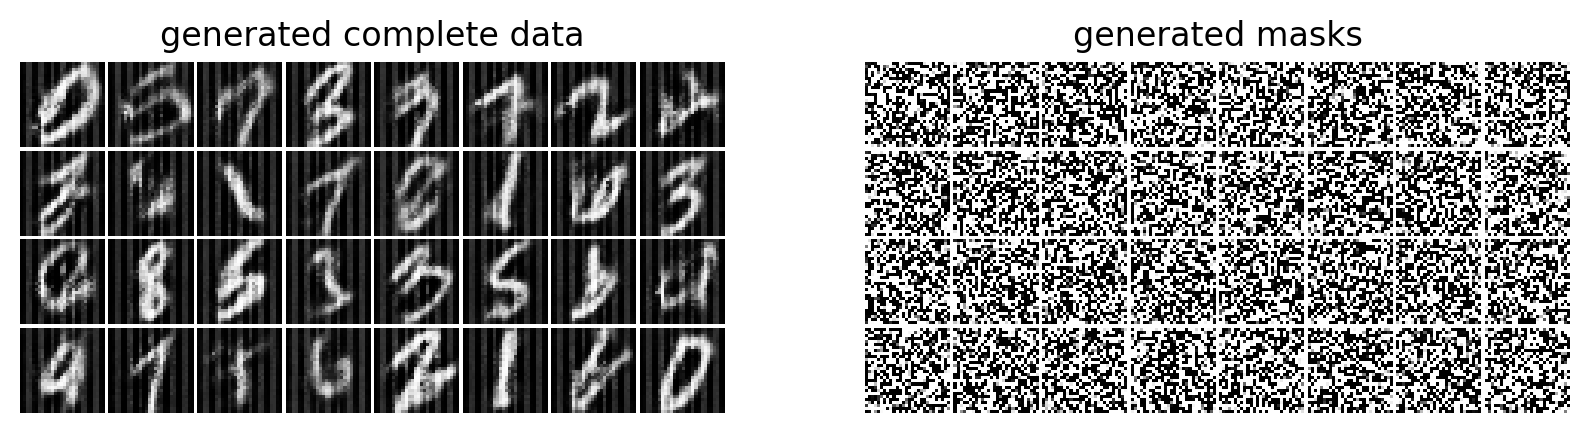

Epoch: 269


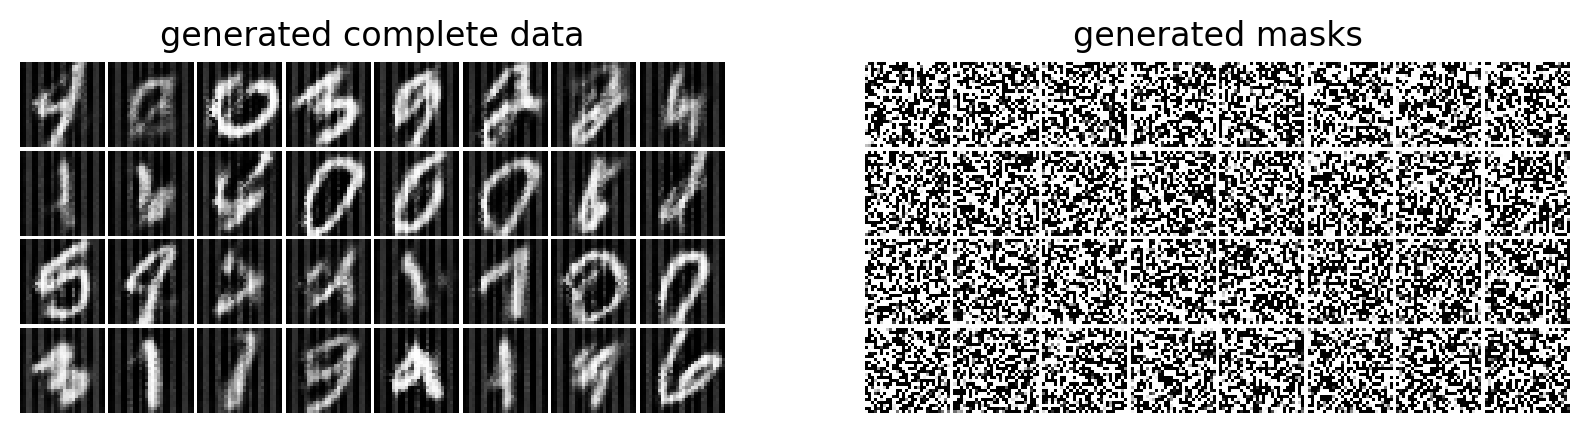

Epoch: 299


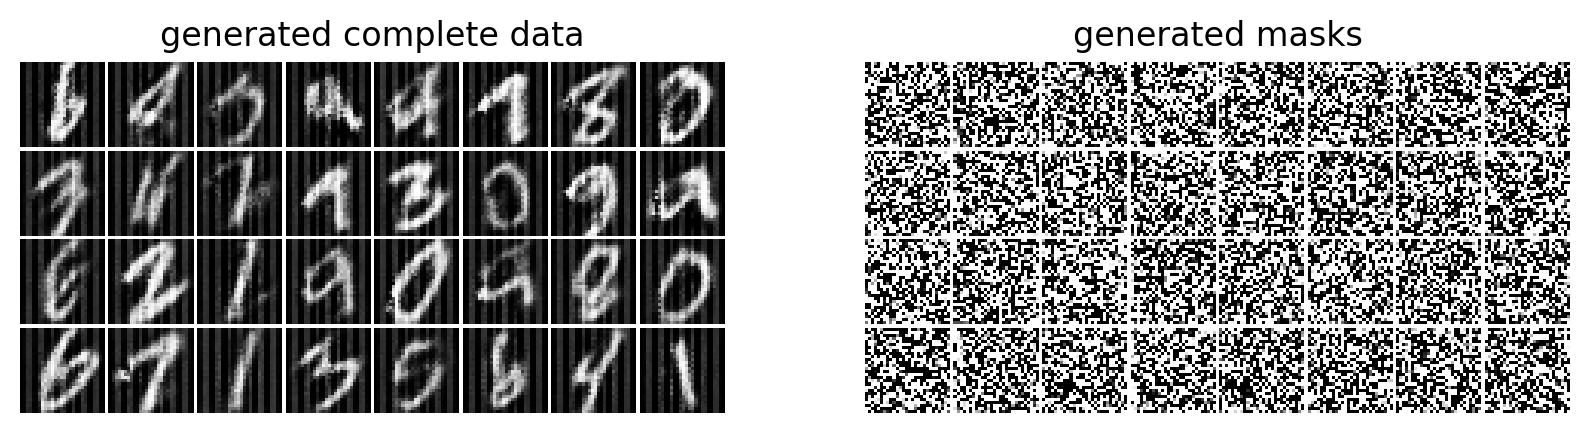

In [66]:
plot_interval = 30
critic_updates = 0

for epoch in range(300):
    for real_data, real_mask in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        # Update discriminators' parameters
        data_noise.normal_()
        mask_noise.normal_()

        fake_data = data_gen(data_noise)
        fake_mask = mask_gen(mask_noise)

        masked_fake_data = mask_data(fake_data, fake_mask)
        masked_real_data = mask_data(real_data, real_mask)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            # for p in data_critic.parameters():
            #     p.requires_grad_(False)
            # for p in mask_critic.parameters():
            #     p.requires_grad_(False)

            # data_gen.zero_grad()
            # mask_gen.zero_grad()

            # data_noise.normal_()
            # mask_noise.normal_()

            # fake_data = data_gen(data_noise)
            # fake_mask = mask_gen(mask_noise)
            # masked_fake_data = mask_data(fake_data, fake_mask)

            # data_loss = -data_critic(masked_fake_data).mean()
            # data_loss.backward(retain_graph=True)
            # data_gen_optimizer.step()

            # mask_loss = -mask_critic(fake_mask).mean()
            # (mask_loss + data_loss * alpha).backward()
            # mask_gen_optimizer.step()

            # for p in data_critic.parameters():
            #     p.requires_grad_(True)
            # for p in mask_critic.parameters():
            #     p.requires_grad_(True)
            
            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)

            data_gen.zero_grad()
            mask_gen.zero_grad()

            data_noise.normal_()
            mask_noise.normal_()

            fake_data = data_gen(data_noise)
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data.clone(), fake_mask.clone())

            data_loss = -data_critic(masked_fake_data).mean()
            data_loss.backward(retain_graph=True)
            data_gen_optimizer.step()

            mask_loss = -mask_critic(fake_mask).mean()
            total_loss = mask_loss + data_loss.detach() * alpha
            total_loss.backward()
            mask_gen_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        data_gen.eval()
        mask_gen.eval()

        with torch.no_grad():
            print('Epoch:', epoch)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
            
            data_noise.normal_()
            data_samples = data_gen(data_noise)
            plot_grid(ax1, data_samples, title='generated complete data')
            
            mask_noise.normal_()
            mask_samples = mask_gen(mask_noise)
            plot_grid(ax2, mask_samples, title='generated masks')
            
            plt.show()
            plt.close(fig)

        data_gen.train()
        mask_gen.train()

In [87]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

def mean_squared_error_metric(original, imputed):
    """Calculate Mean Squared Error (MSE) between original and imputed images."""
    return mean_squared_error(original.flatten(), imputed.flatten())

def structural_similarity_index(original, imputed):
    """Calculate Structural Similarity Index (SSIM) between original and imputed images."""
    return ssim(original, imputed, data_range=1.0)

def peak_signal_to_noise_ratio(original, imputed):
    """Calculate Peak Signal-to-Noise Ratio (PSNR) between original and imputed images."""
    mse_value = mean_squared_error(original.flatten(), imputed.flatten())
    if mse_value == 0:
        return float('inf')  # Return infinity if MSE is zero
    max_pixel_value = 255.0
    return 10 * np.log10(max_pixel_value**2 / mse_value)

def visualize_images(original, imputed):
    """Visualize original and imputed images side by side."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Imputed Image')
    plt.imshow(imputed, cmap='gray')
    plt.axis('off')

    plt.show()

def evaluate_images(original_path, imputed_path):
    """Evaluate the imputation performance based on various metrics."""
    original = original_path
    imputed = imputed_path

    mse_value = mean_squared_error_metric(original, imputed)
    ssim_value = structural_similarity_index(original, imputed)
    psnr_value = peak_signal_to_noise_ratio(original, imputed)

    print(f'Mean Squared Error (MSE): {mse_value:.4f}')
    print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')
    print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')

    visualize_images(original, imputed)

Epoch: 19


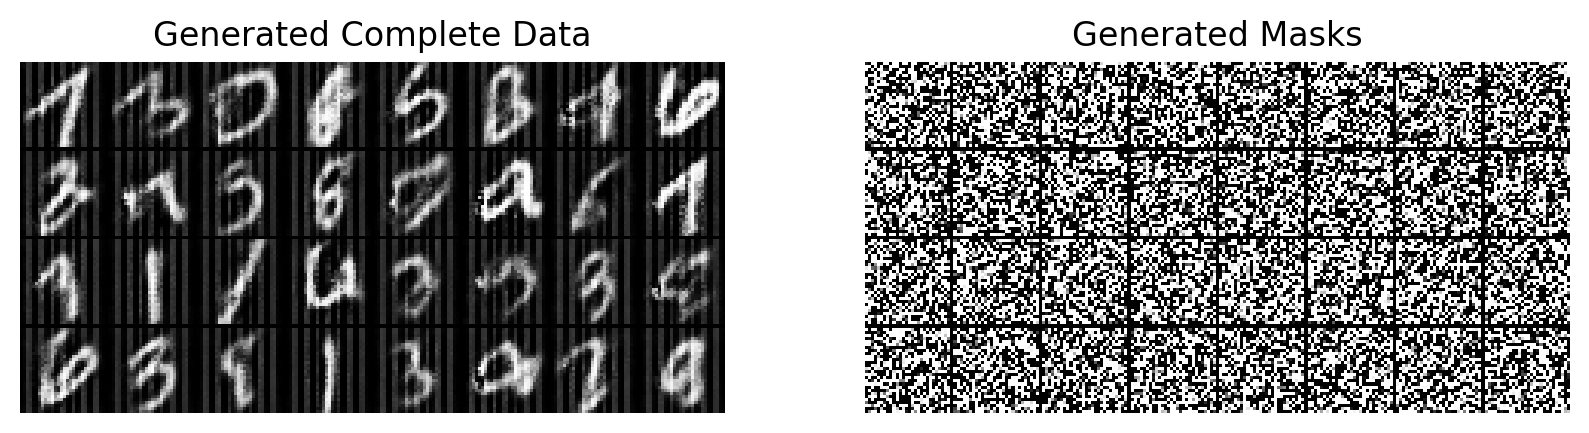


Sample 1:
Mean Squared Error (MSE): 0.0918
Structural Similarity Index (SSIM): 0.0404
Peak Signal-to-Noise Ratio (PSNR): 58.5012 dB


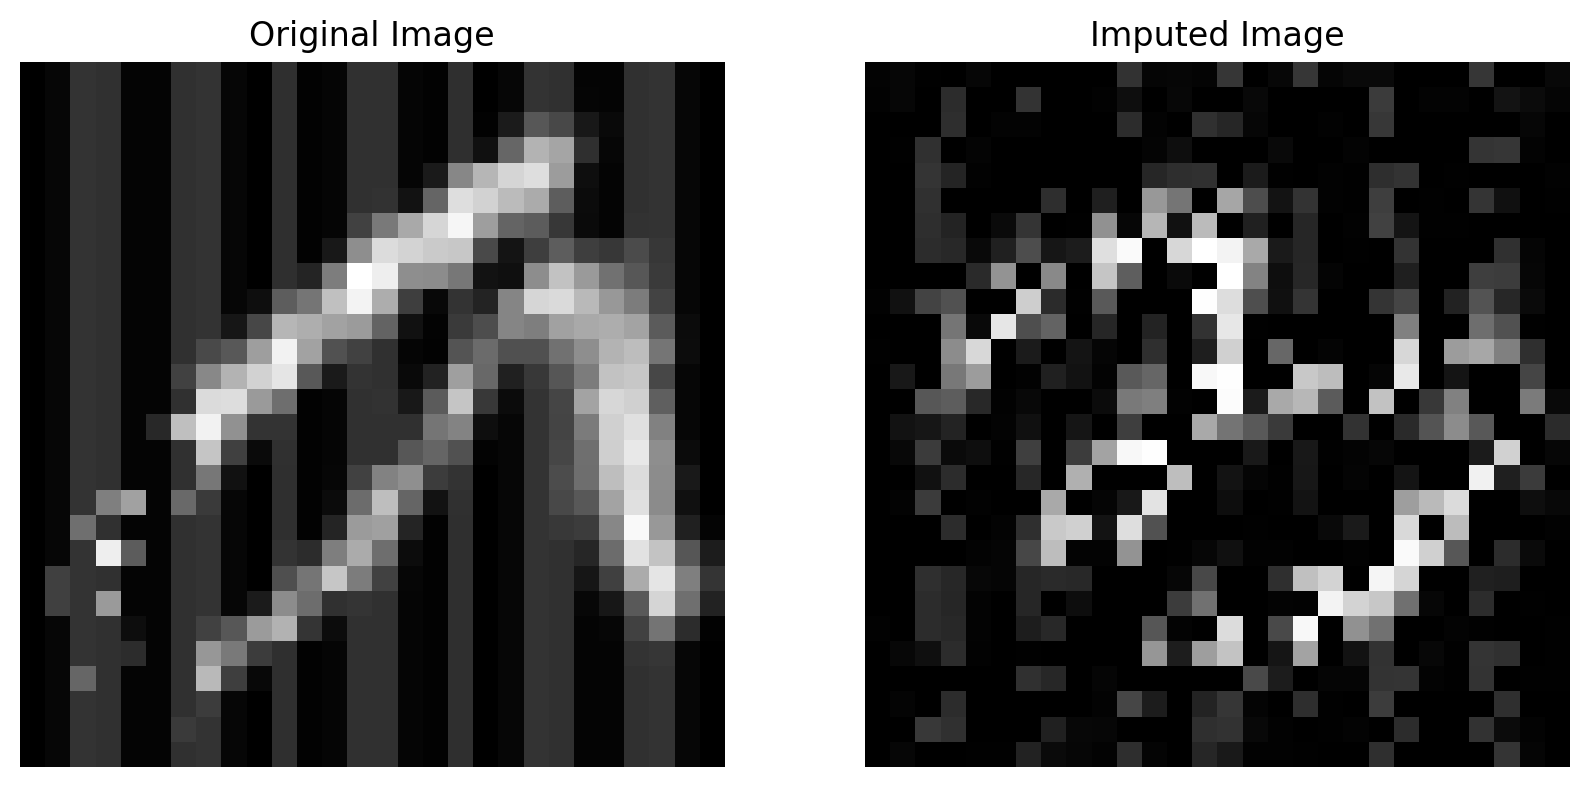


Sample 2:
Mean Squared Error (MSE): 0.1335
Structural Similarity Index (SSIM): 0.0816
Peak Signal-to-Noise Ratio (PSNR): 56.8767 dB


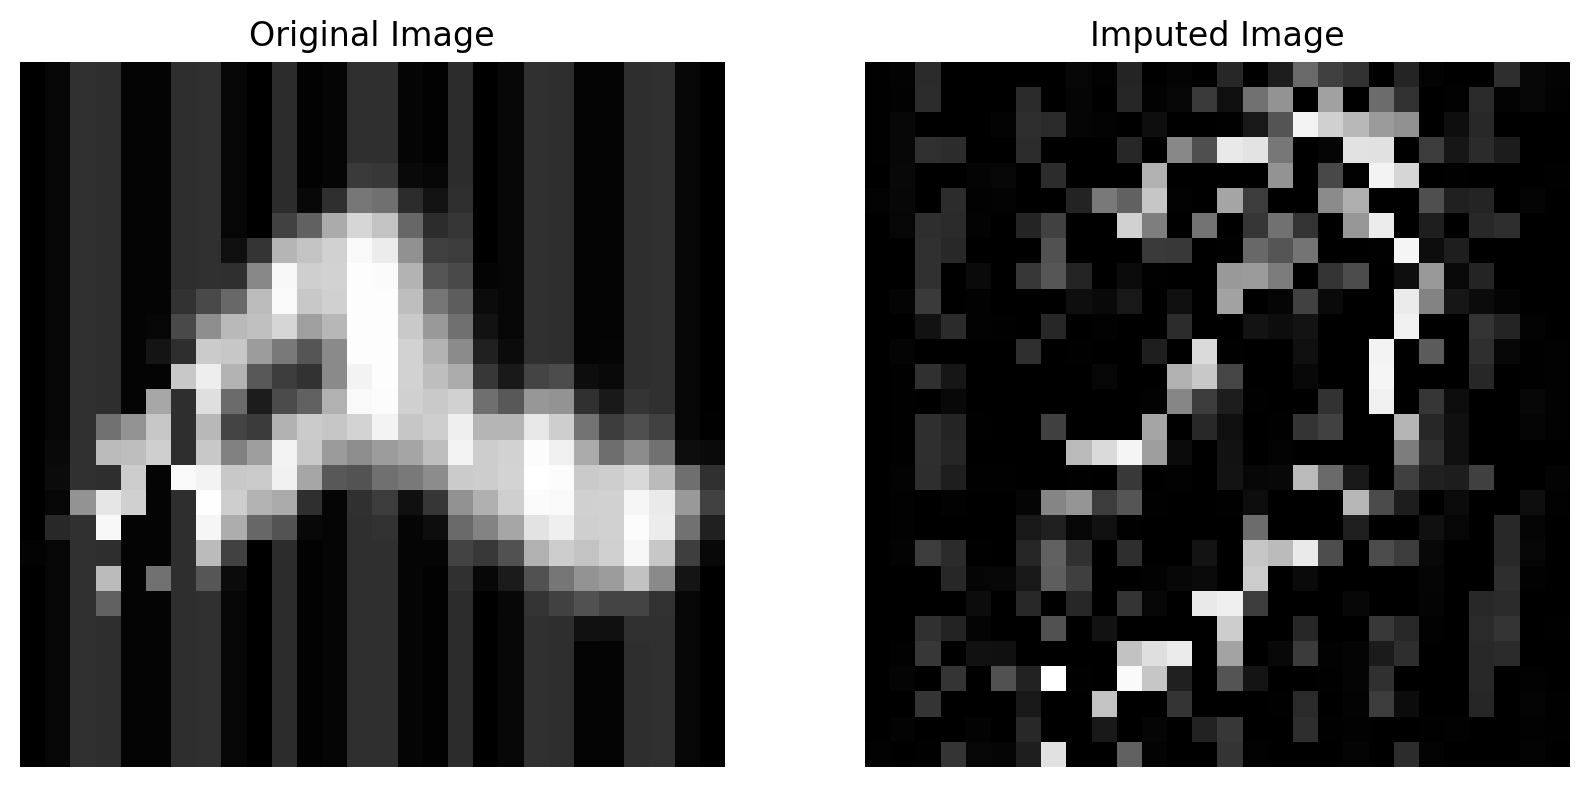


Sample 3:
Mean Squared Error (MSE): 0.1246
Structural Similarity Index (SSIM): 0.1296
Peak Signal-to-Noise Ratio (PSNR): 57.1753 dB


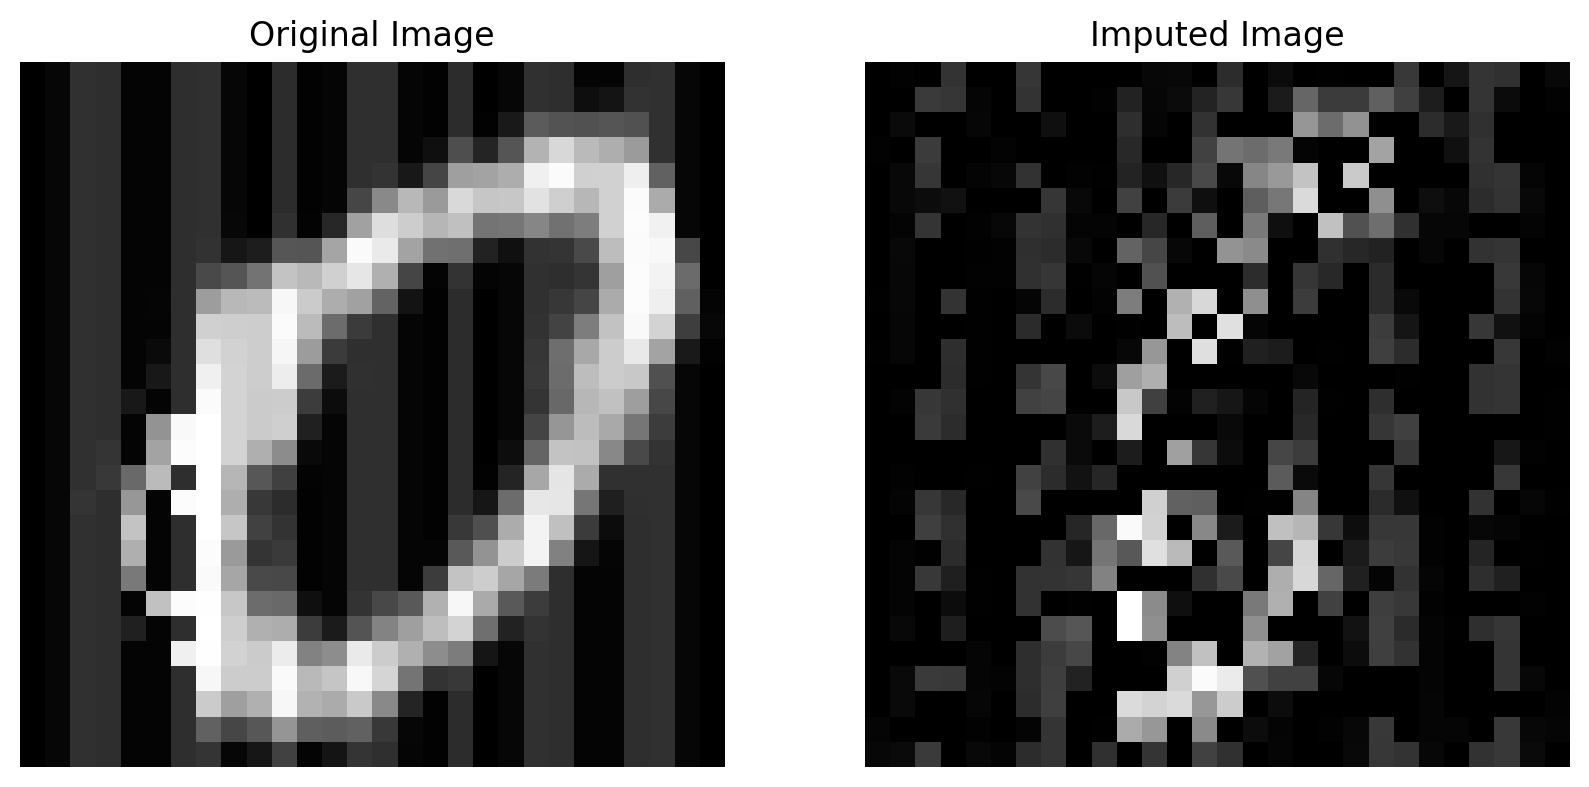


Sample 4:
Mean Squared Error (MSE): 0.1043
Structural Similarity Index (SSIM): 0.2013
Peak Signal-to-Noise Ratio (PSNR): 57.9473 dB


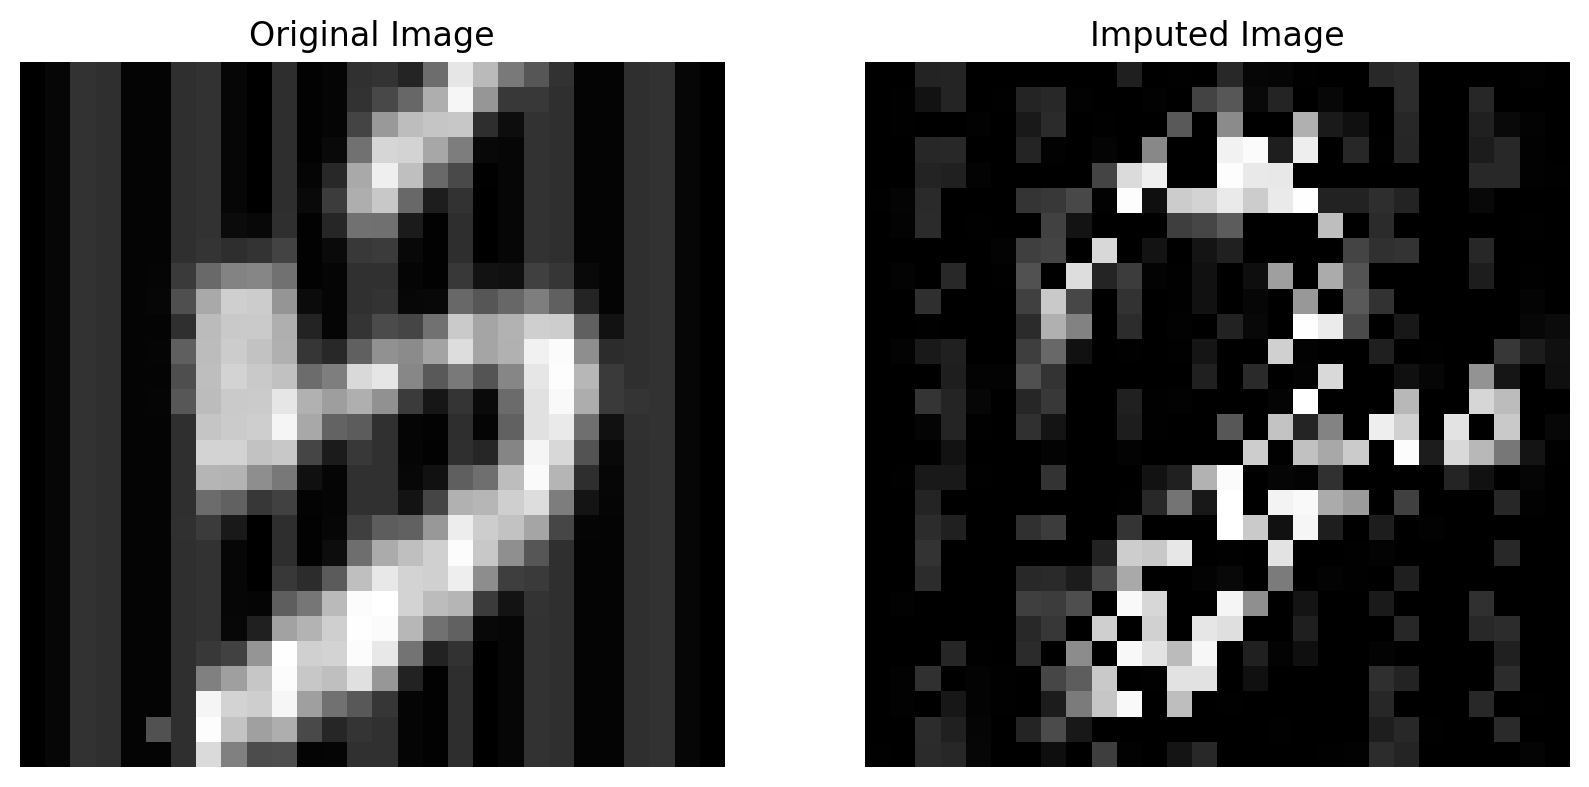


Sample 5:
Mean Squared Error (MSE): 0.1211
Structural Similarity Index (SSIM): 0.0869
Peak Signal-to-Noise Ratio (PSNR): 57.2985 dB


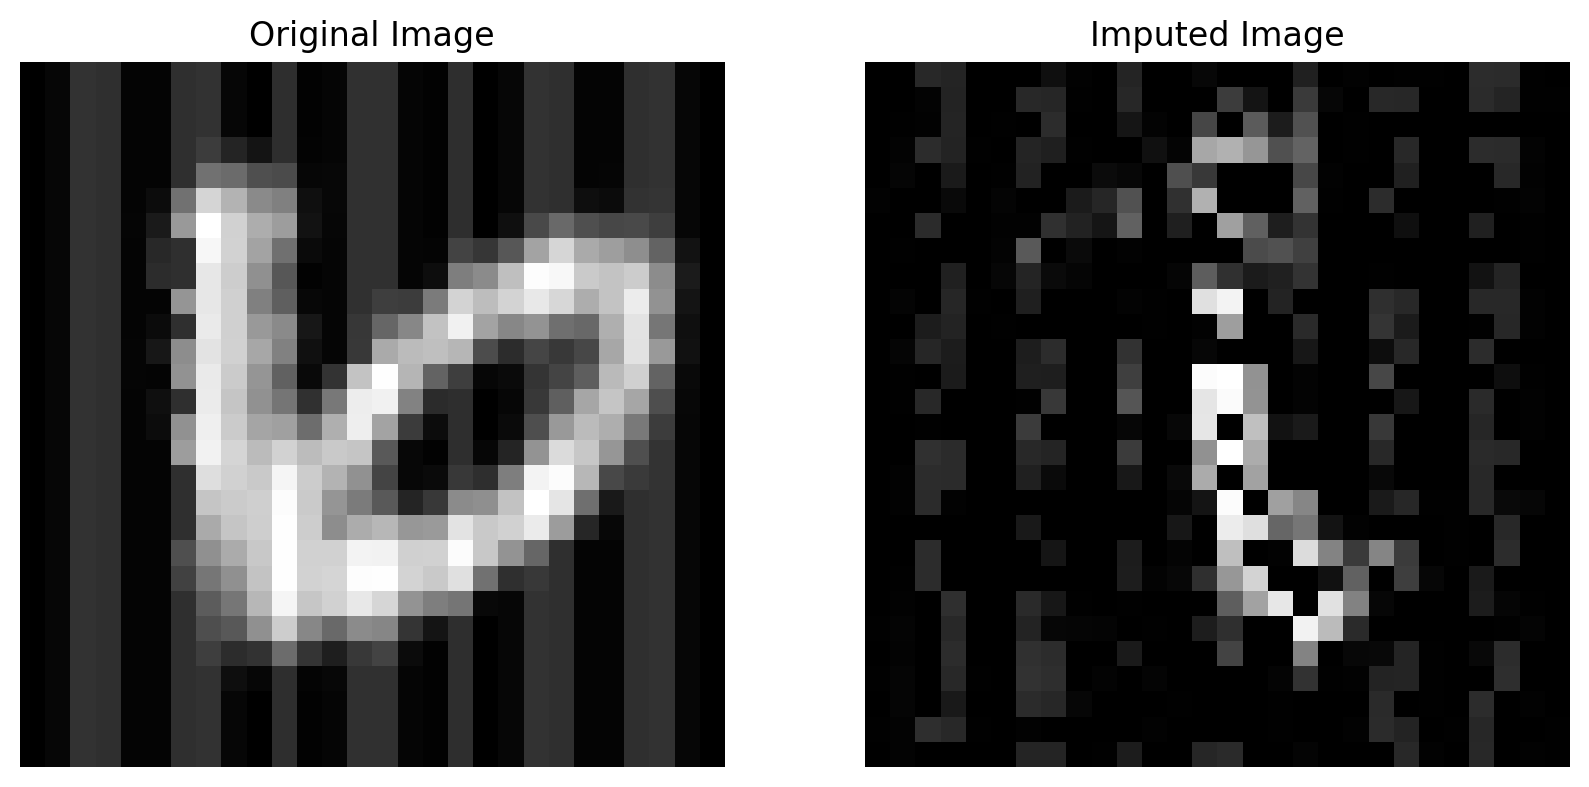

Epoch: 39


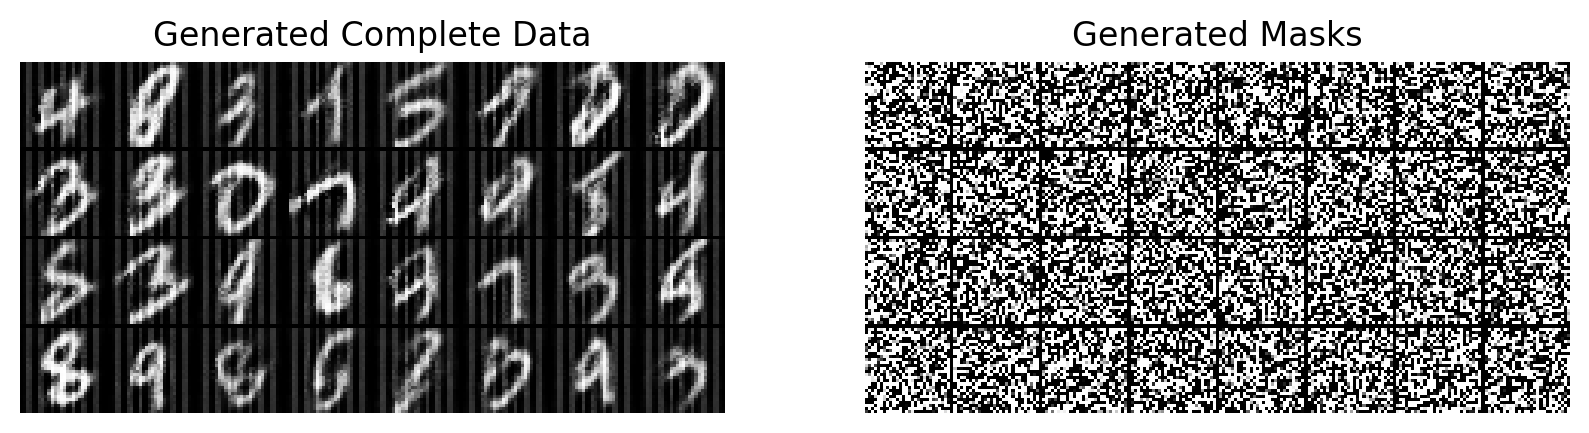


Sample 1:
Mean Squared Error (MSE): 0.0855
Structural Similarity Index (SSIM): 0.1241
Peak Signal-to-Noise Ratio (PSNR): 58.8103 dB


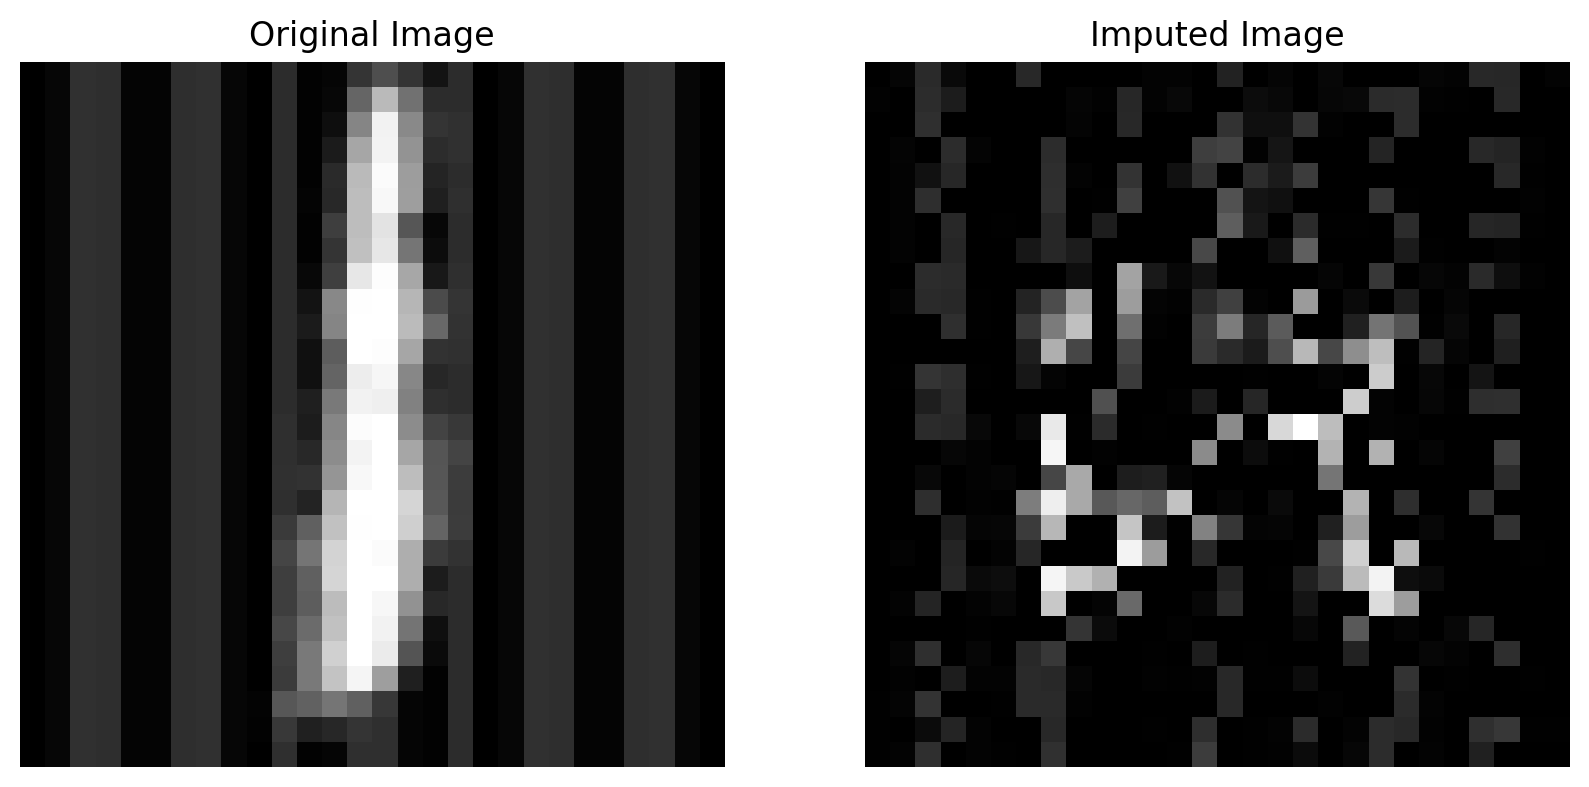


Sample 2:
Mean Squared Error (MSE): 0.0663
Structural Similarity Index (SSIM): 0.1170
Peak Signal-to-Noise Ratio (PSNR): 59.9181 dB


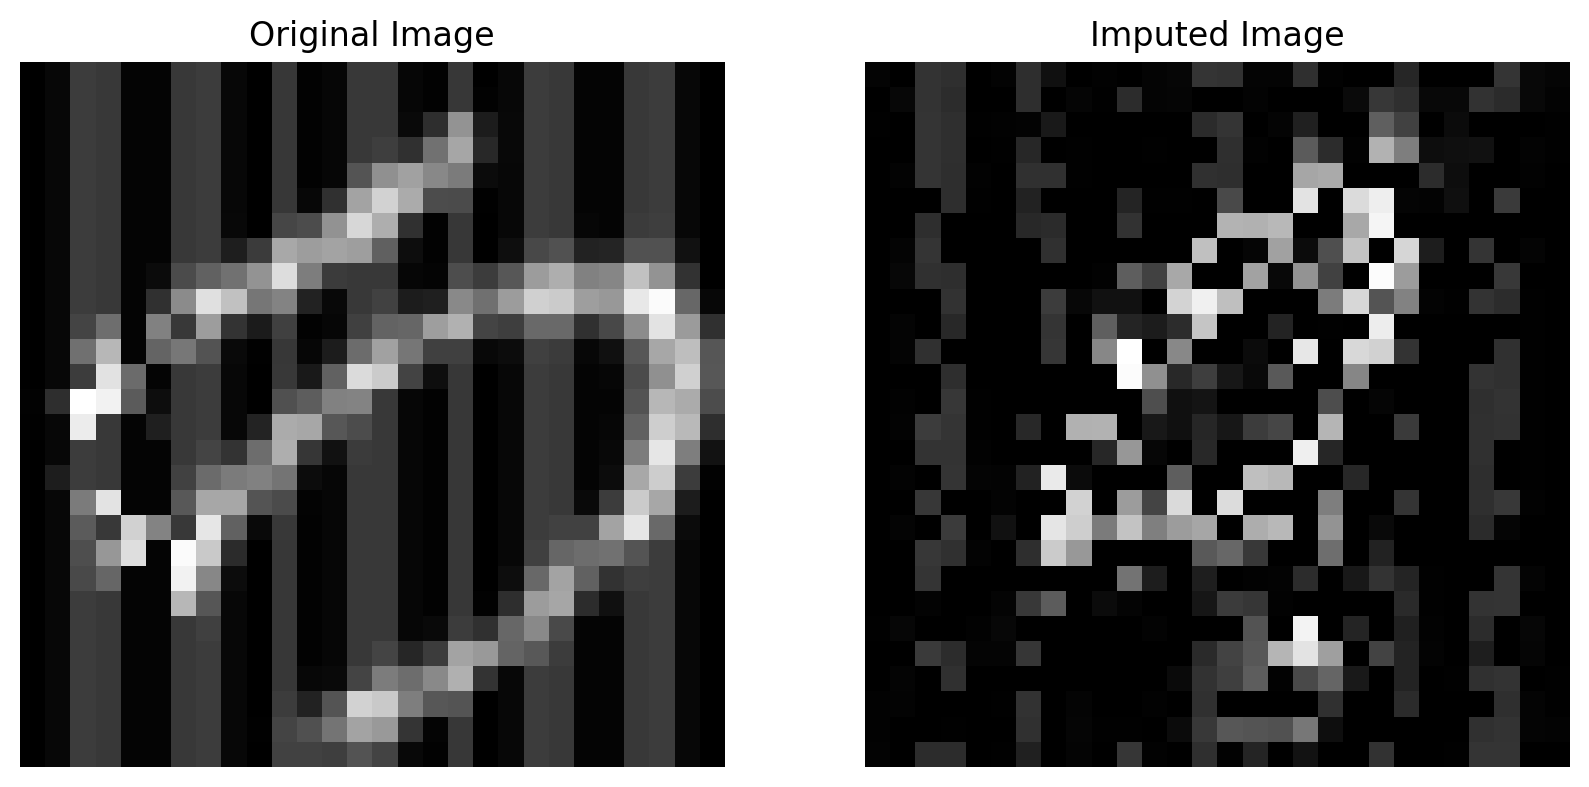


Sample 3:
Mean Squared Error (MSE): 0.0728
Structural Similarity Index (SSIM): 0.2062
Peak Signal-to-Noise Ratio (PSNR): 59.5086 dB


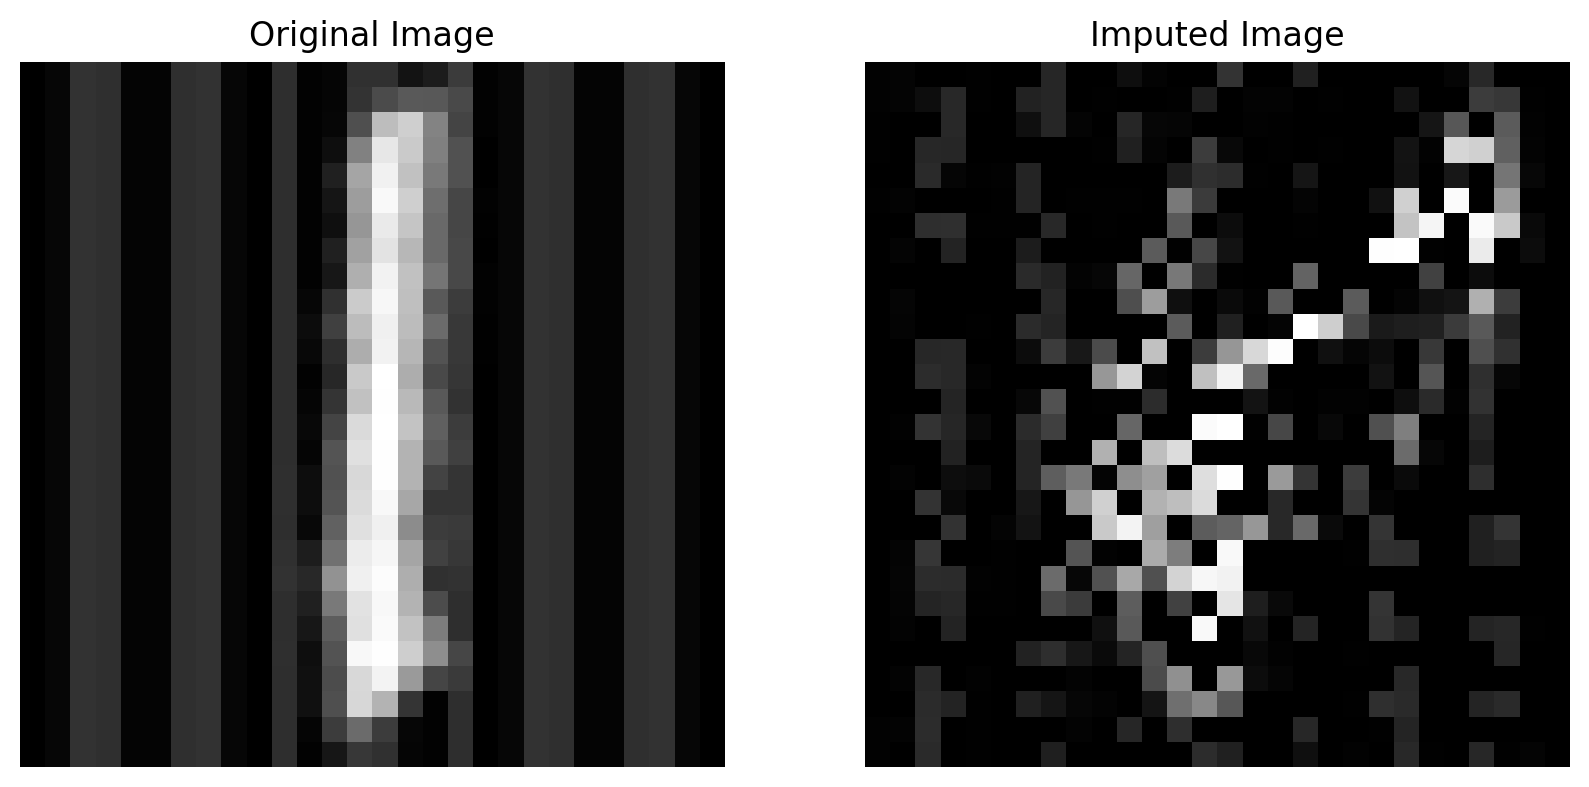


Sample 4:
Mean Squared Error (MSE): 0.1166
Structural Similarity Index (SSIM): 0.1914
Peak Signal-to-Noise Ratio (PSNR): 57.4628 dB


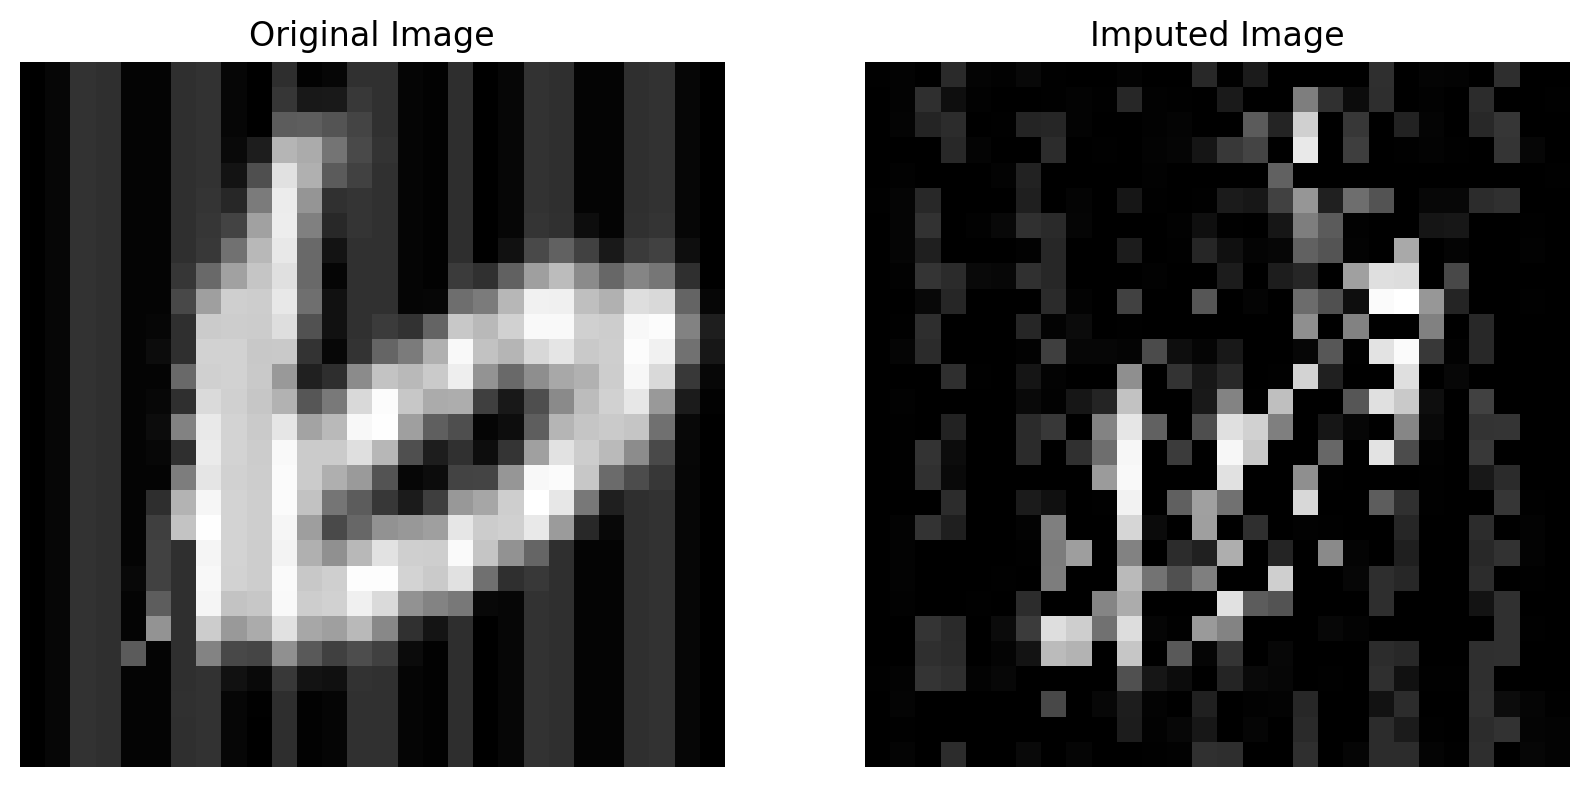


Sample 5:
Mean Squared Error (MSE): 0.0702
Structural Similarity Index (SSIM): 0.1247
Peak Signal-to-Noise Ratio (PSNR): 59.6697 dB


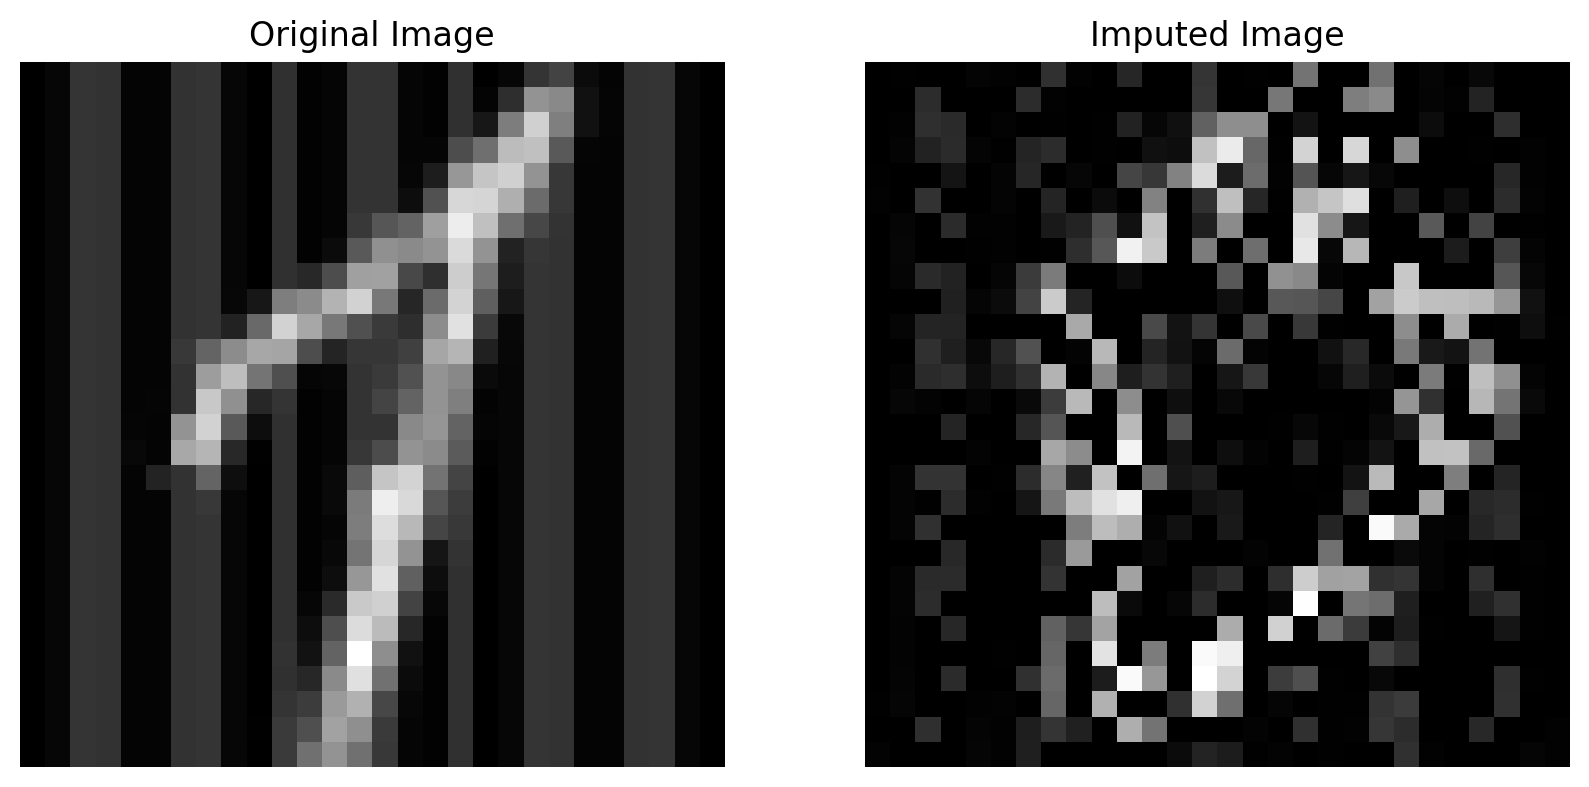

Epoch: 59


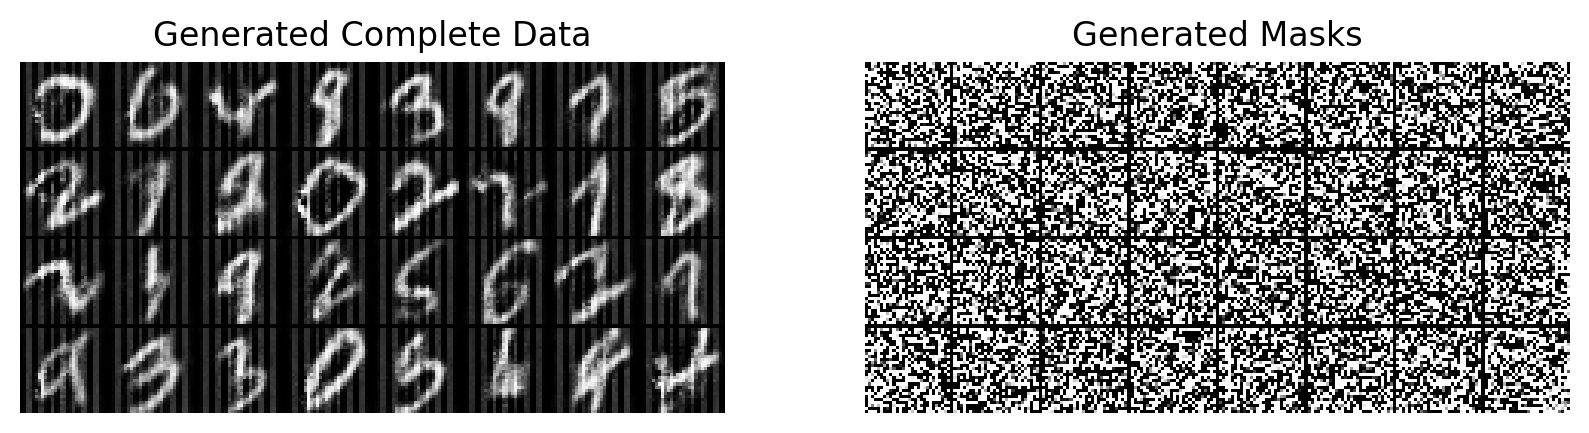


Sample 1:
Mean Squared Error (MSE): 0.0880
Structural Similarity Index (SSIM): 0.1956
Peak Signal-to-Noise Ratio (PSNR): 58.6846 dB


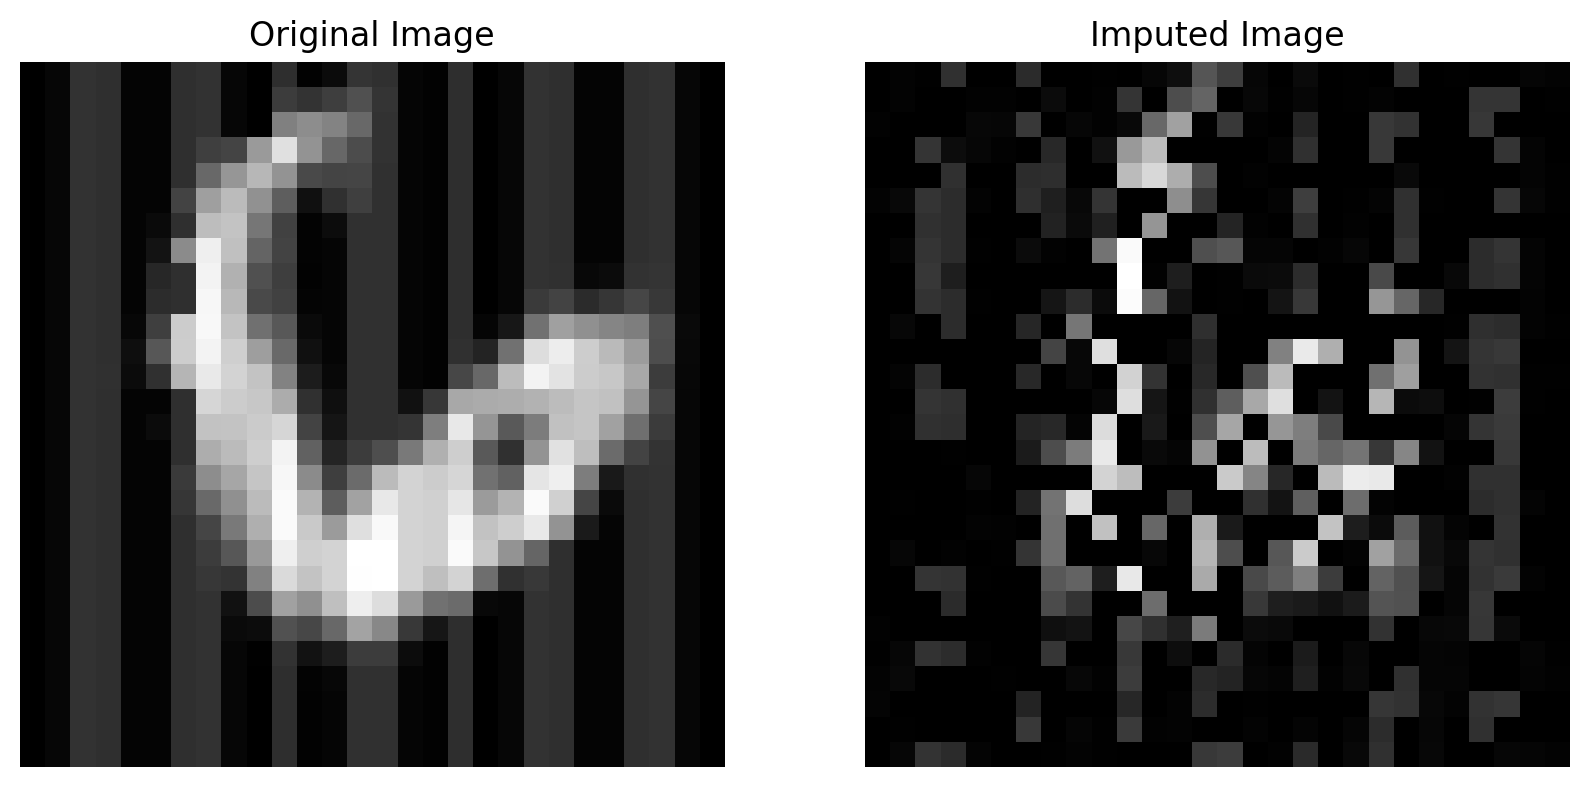


Sample 2:
Mean Squared Error (MSE): 0.1178
Structural Similarity Index (SSIM): 0.0529
Peak Signal-to-Noise Ratio (PSNR): 57.4181 dB


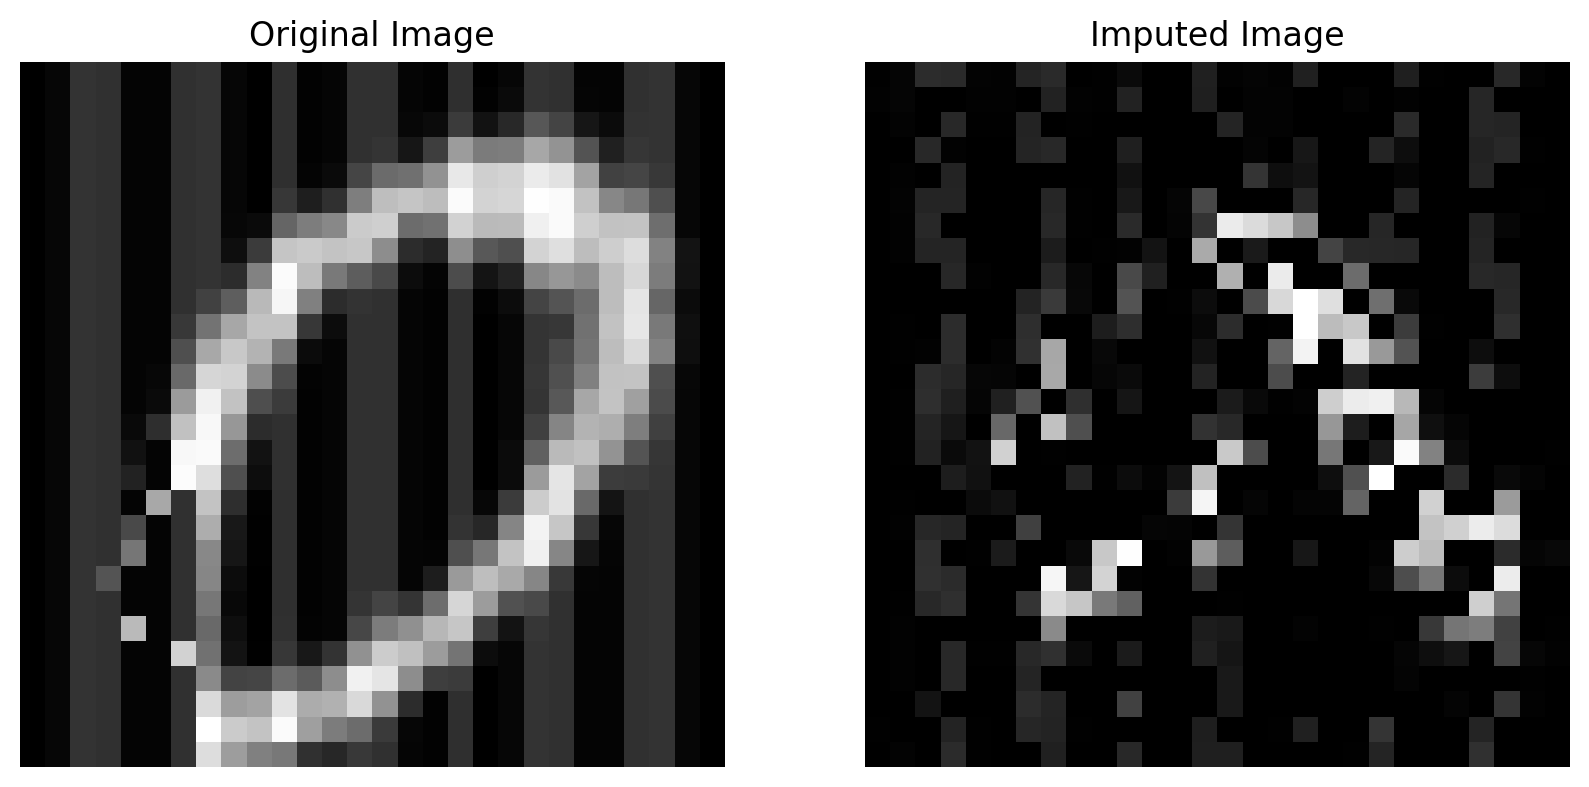


Sample 3:
Mean Squared Error (MSE): 0.0856
Structural Similarity Index (SSIM): 0.0545
Peak Signal-to-Noise Ratio (PSNR): 58.8054 dB


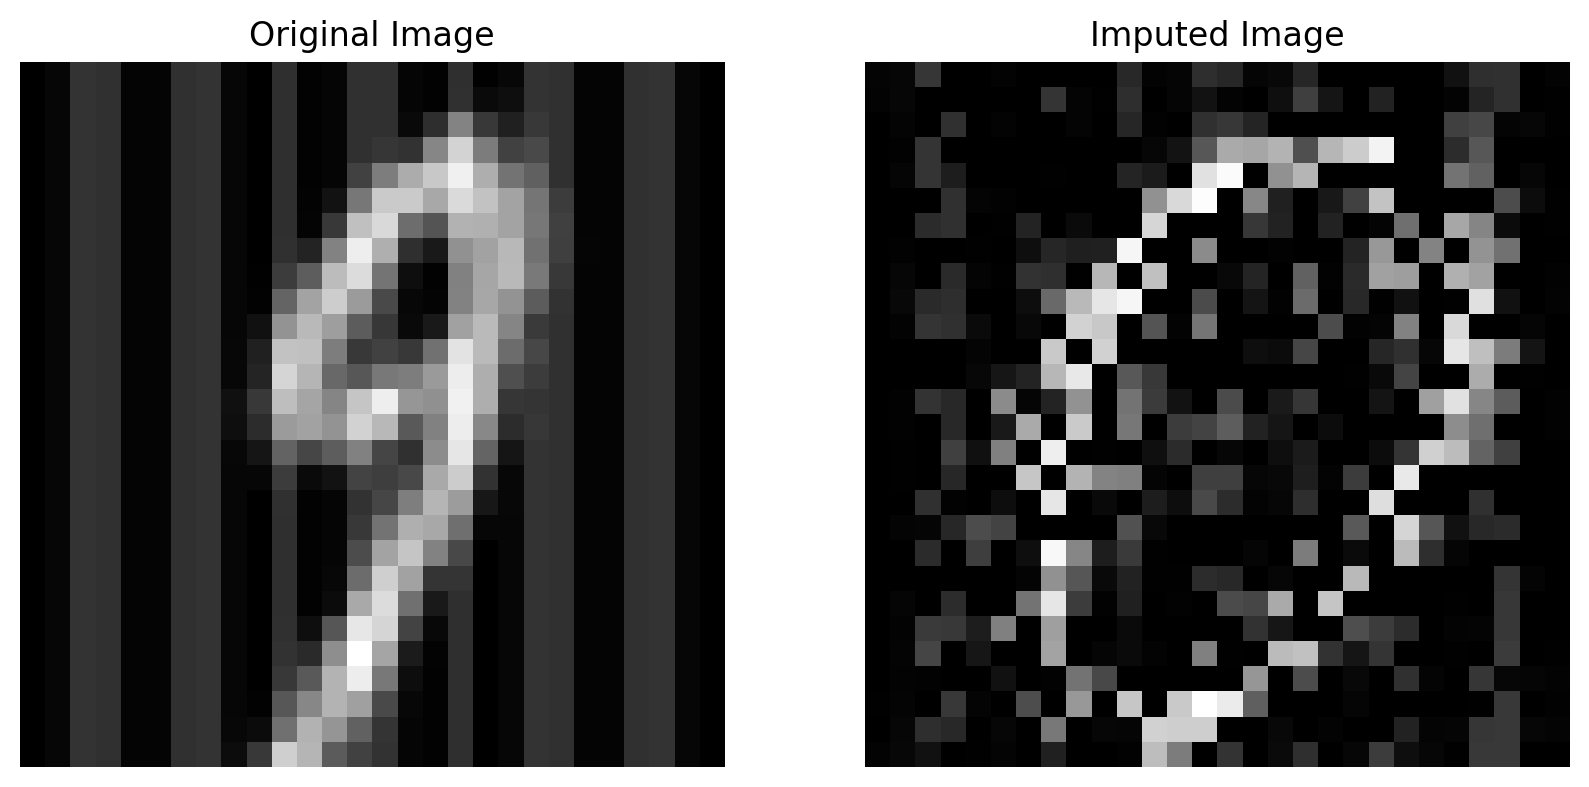


Sample 4:
Mean Squared Error (MSE): 0.1036
Structural Similarity Index (SSIM): 0.1841
Peak Signal-to-Noise Ratio (PSNR): 57.9754 dB


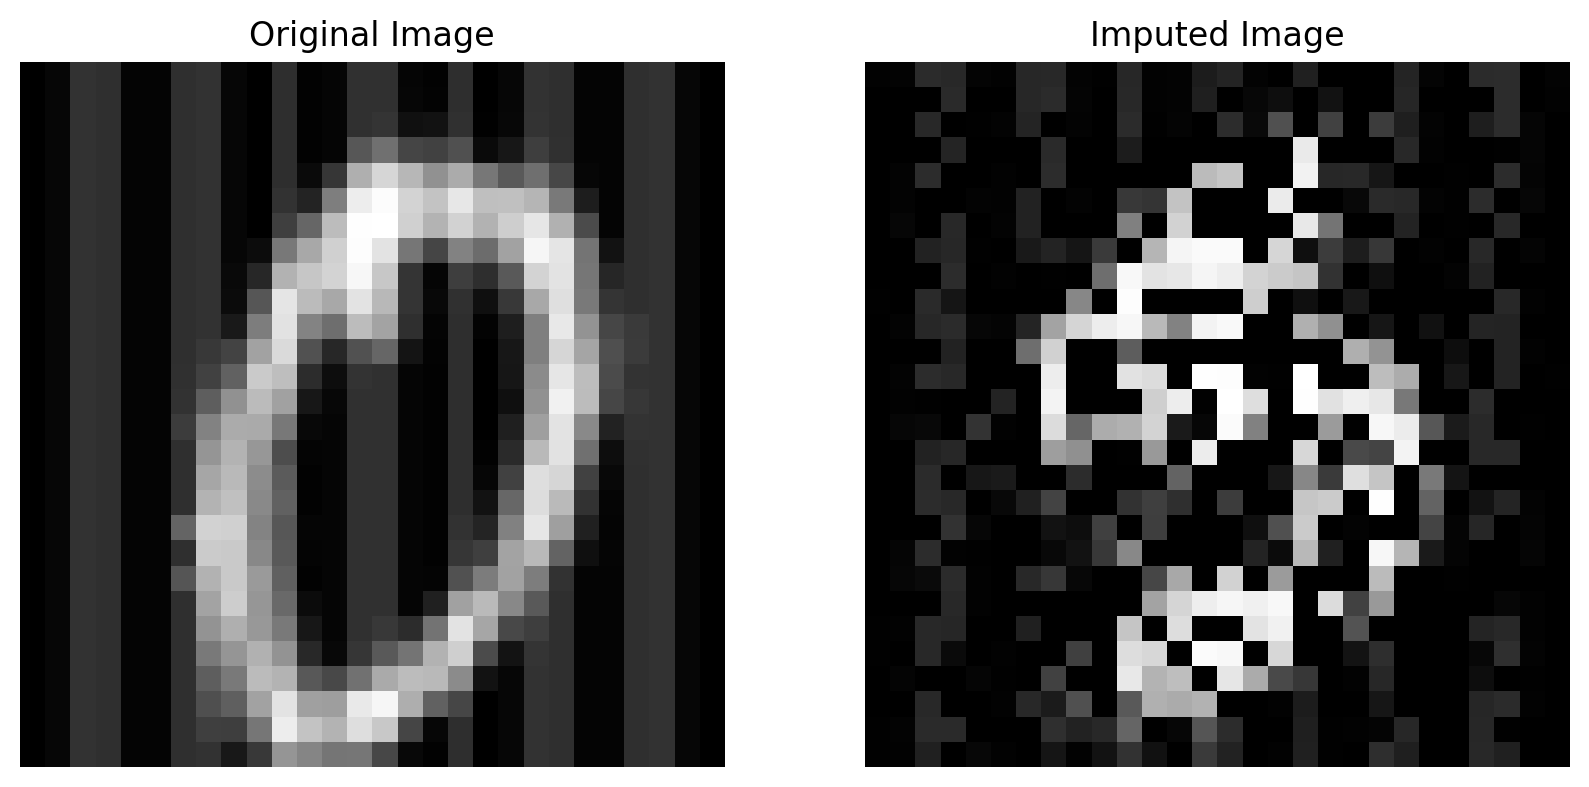


Sample 5:
Mean Squared Error (MSE): 0.1332
Structural Similarity Index (SSIM): 0.1287
Peak Signal-to-Noise Ratio (PSNR): 56.8856 dB


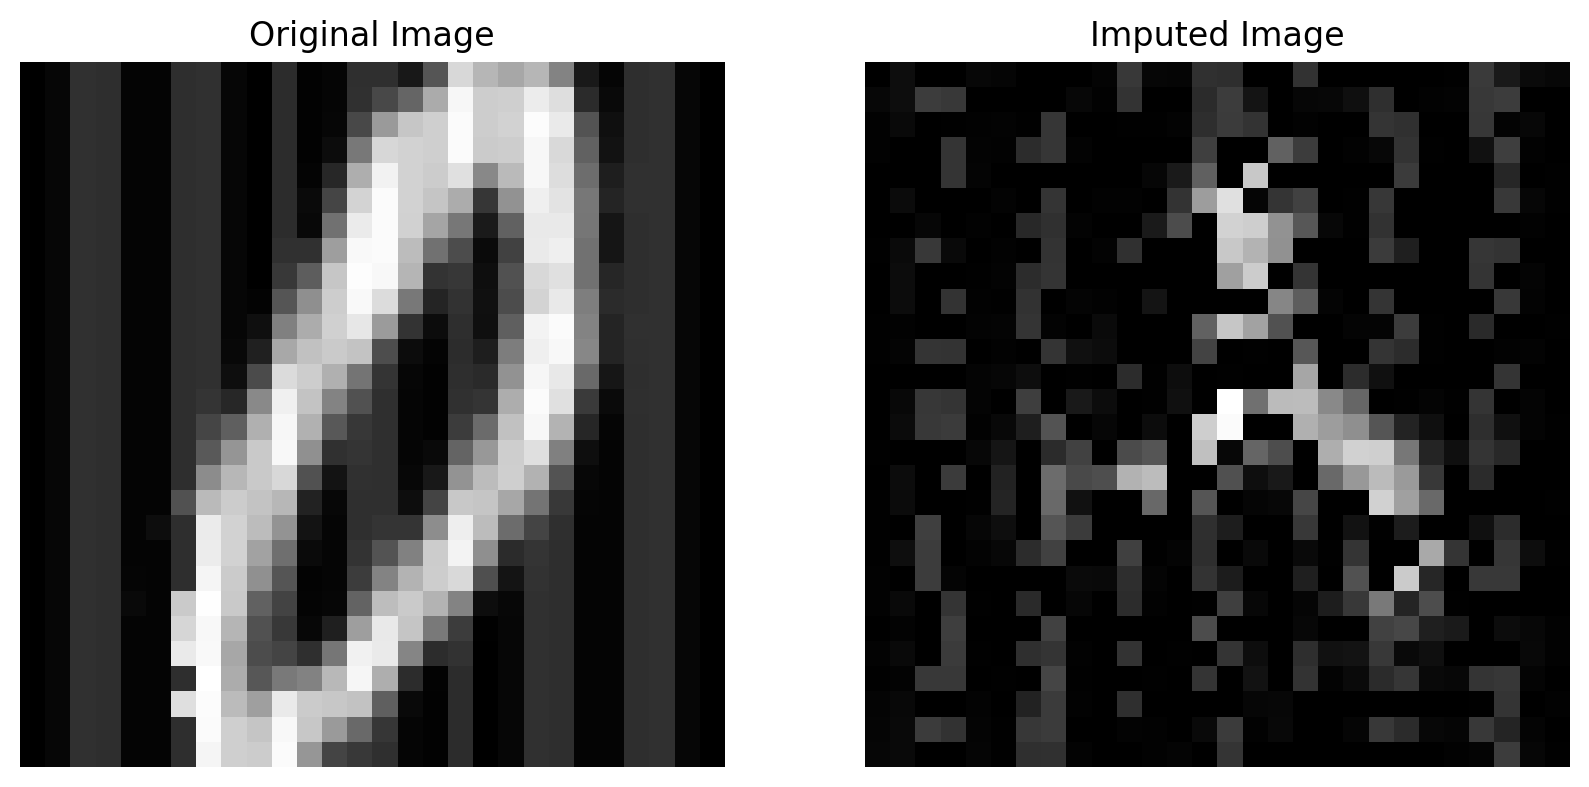

Epoch: 79


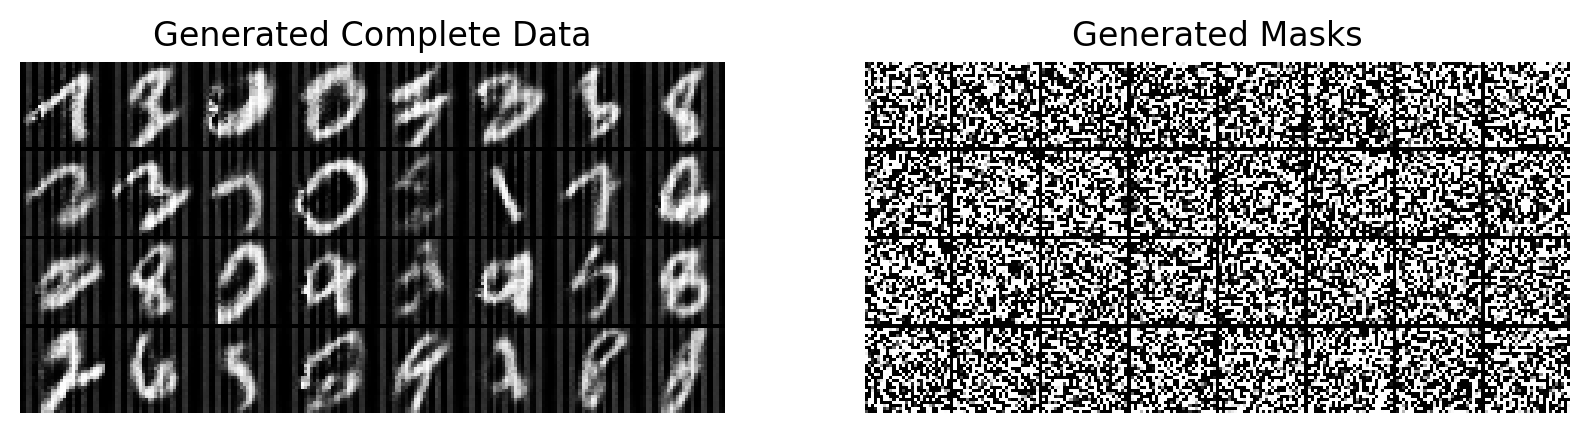


Sample 1:
Mean Squared Error (MSE): 0.0954
Structural Similarity Index (SSIM): 0.1298
Peak Signal-to-Noise Ratio (PSNR): 58.3340 dB


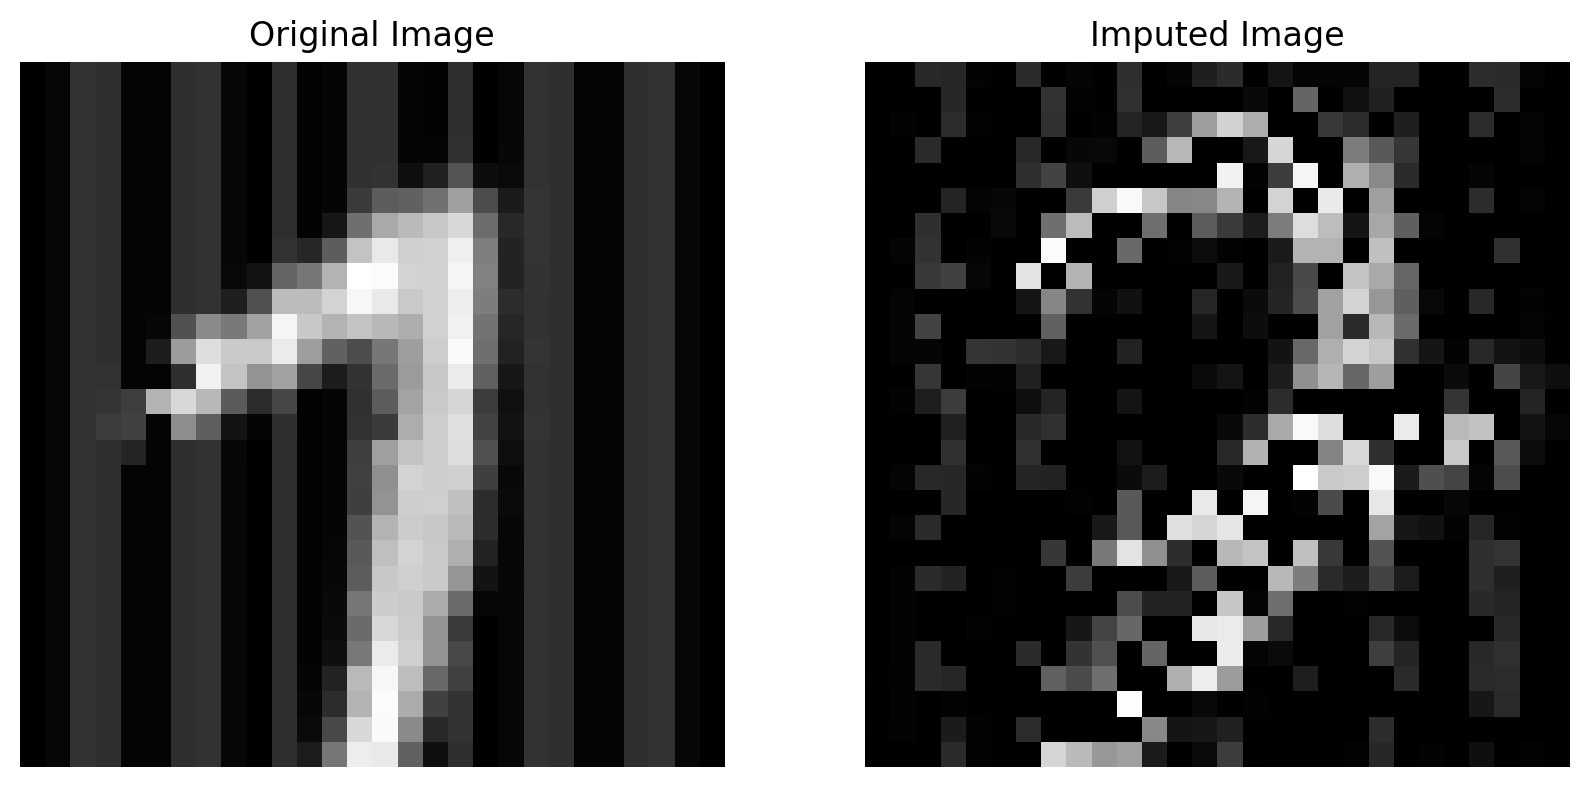


Sample 2:
Mean Squared Error (MSE): 0.0652
Structural Similarity Index (SSIM): 0.1834
Peak Signal-to-Noise Ratio (PSNR): 59.9908 dB


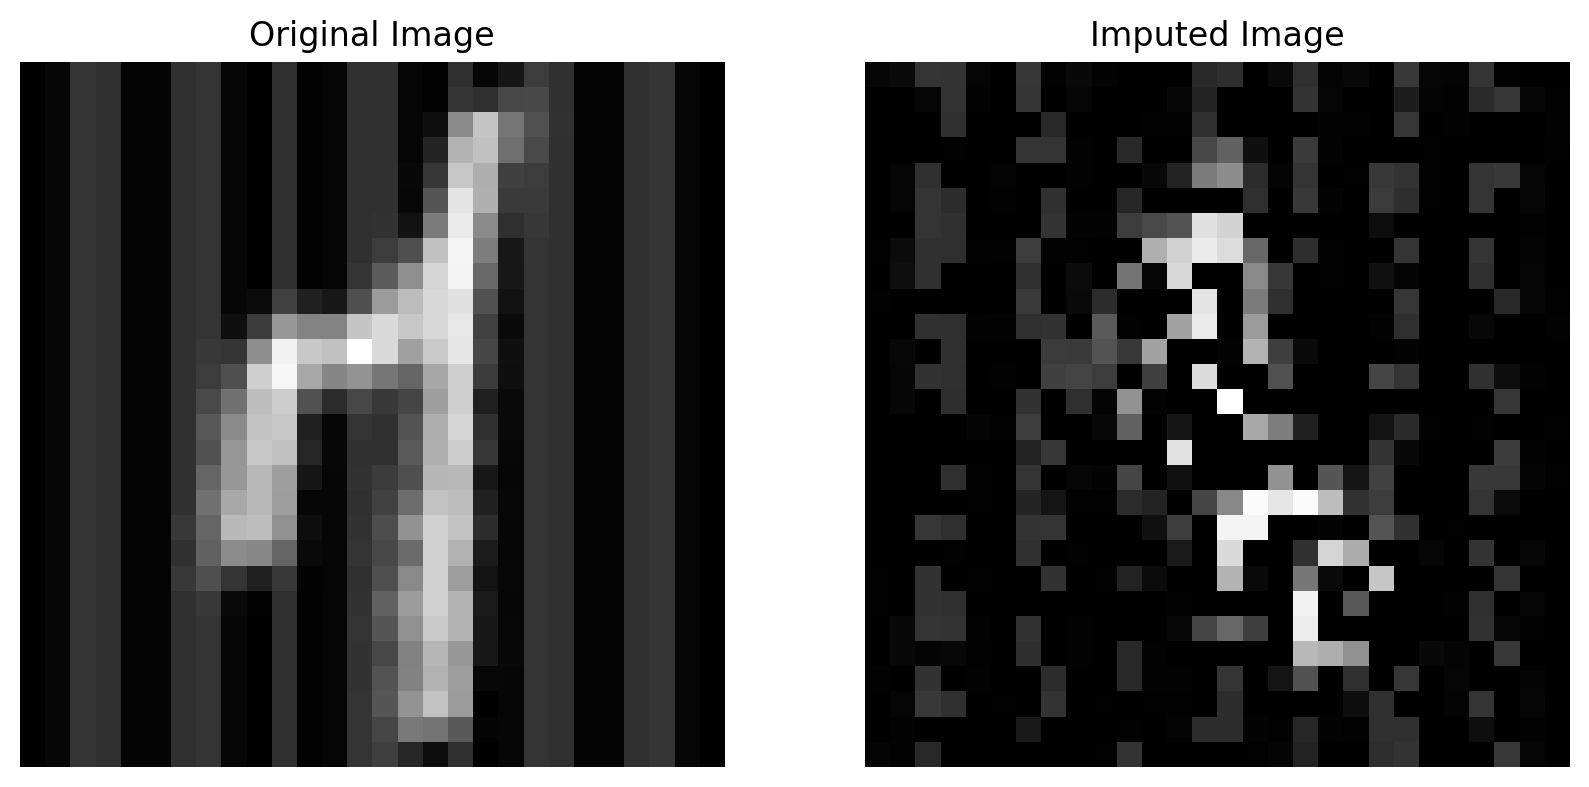


Sample 3:
Mean Squared Error (MSE): 0.0886
Structural Similarity Index (SSIM): 0.2031
Peak Signal-to-Noise Ratio (PSNR): 58.6541 dB


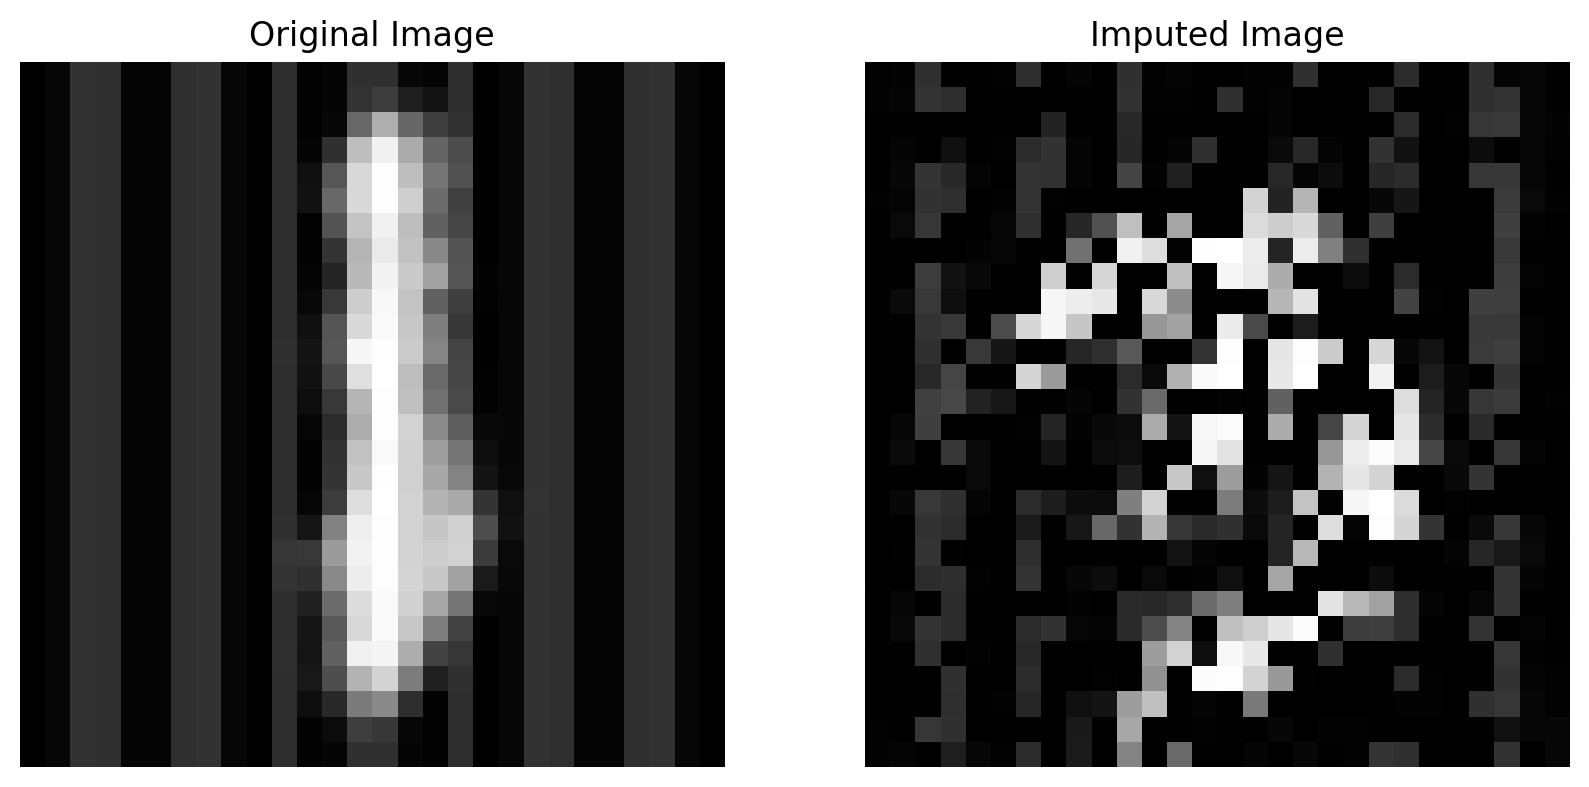


Sample 4:
Mean Squared Error (MSE): 0.1422
Structural Similarity Index (SSIM): 0.1194
Peak Signal-to-Noise Ratio (PSNR): 56.6030 dB


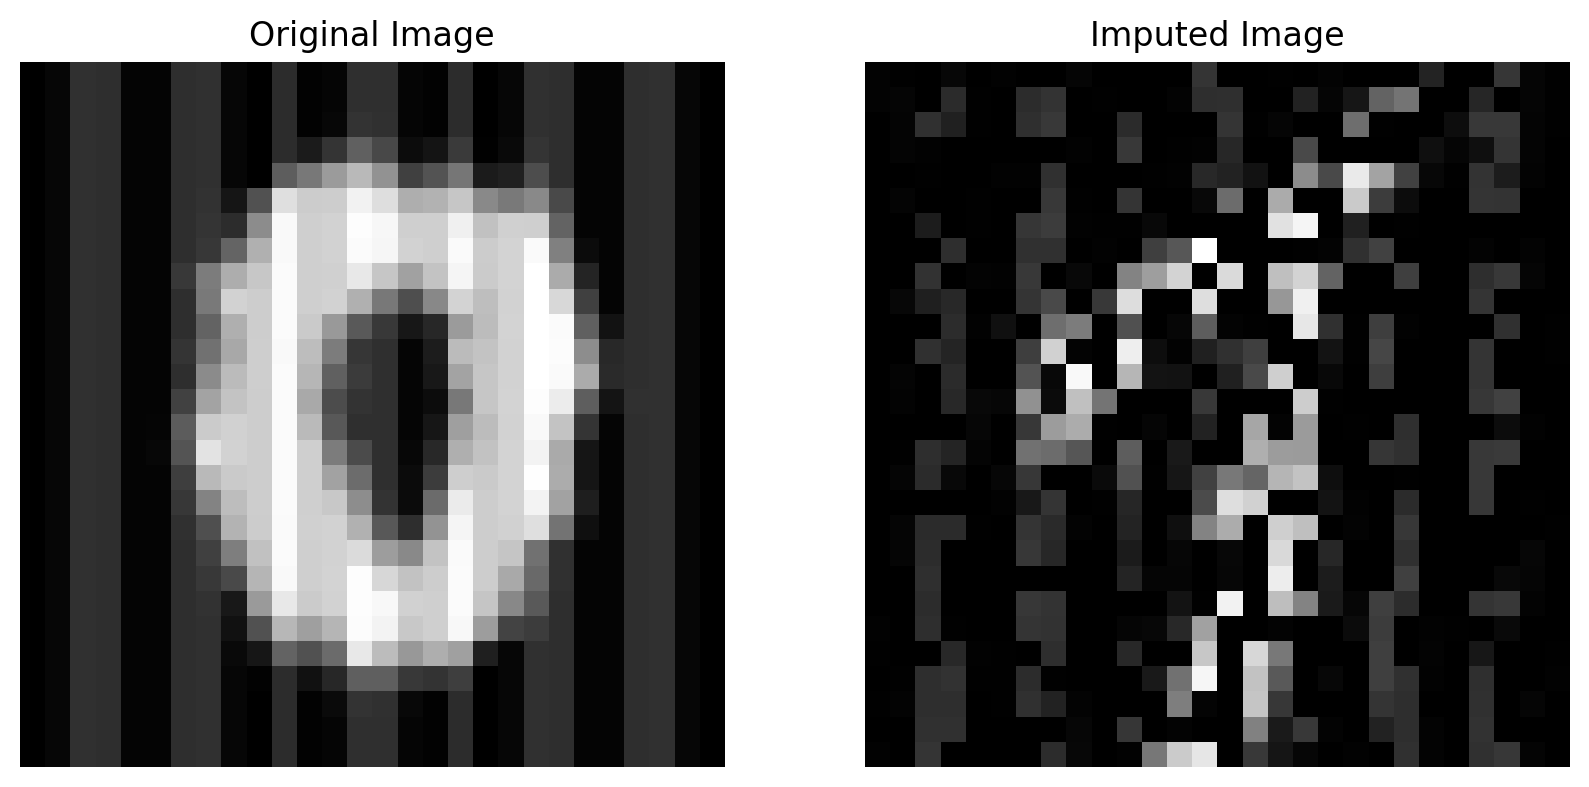


Sample 5:
Mean Squared Error (MSE): 0.0736
Structural Similarity Index (SSIM): 0.1548
Peak Signal-to-Noise Ratio (PSNR): 59.4637 dB


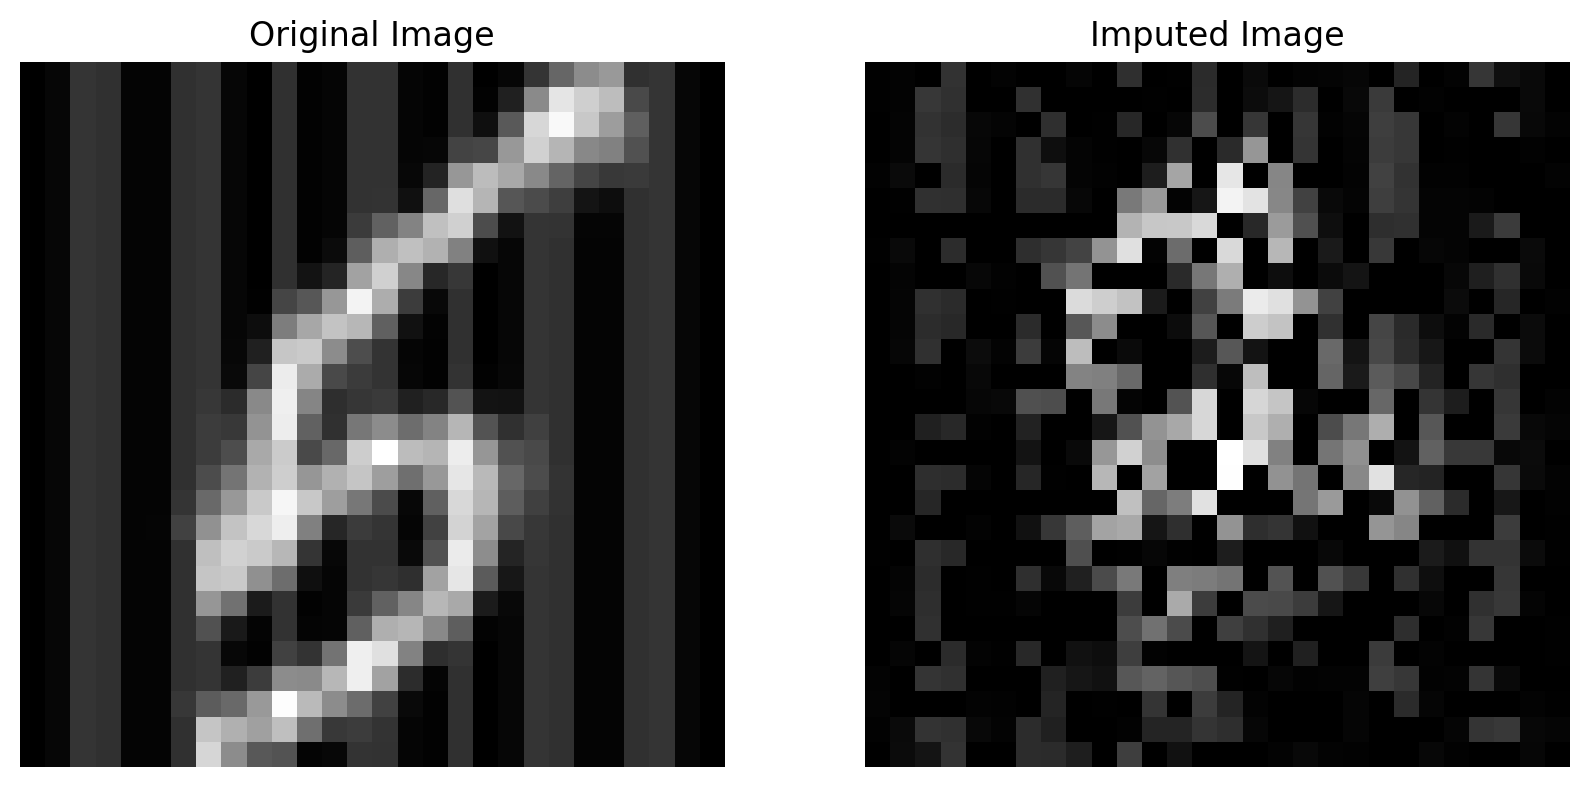

Epoch: 99


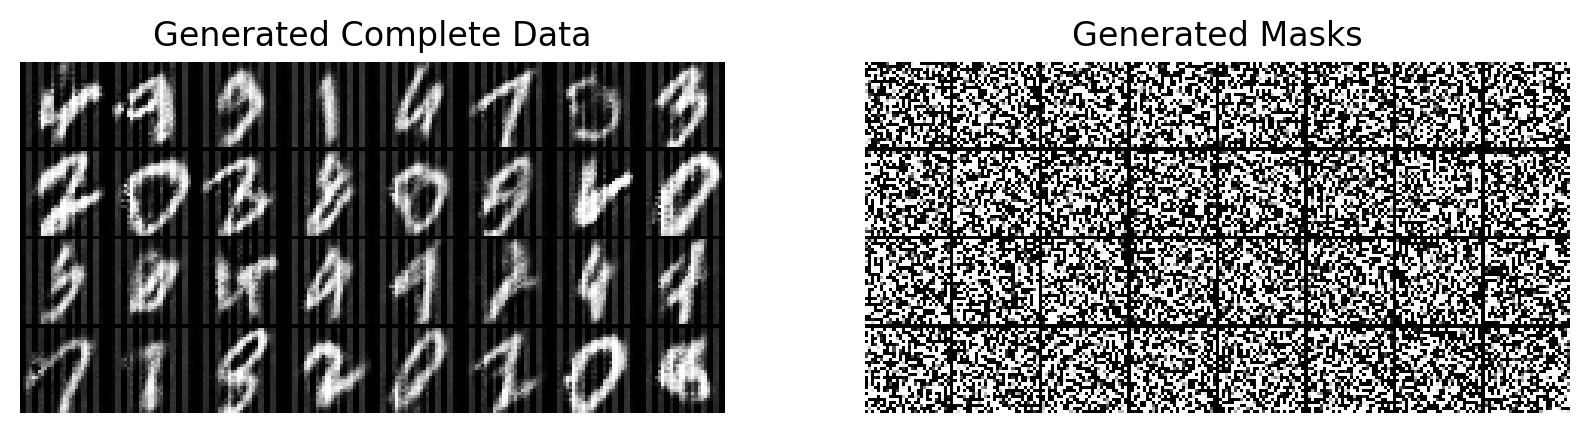


Sample 1:
Mean Squared Error (MSE): 0.1271
Structural Similarity Index (SSIM): 0.0913
Peak Signal-to-Noise Ratio (PSNR): 57.0895 dB


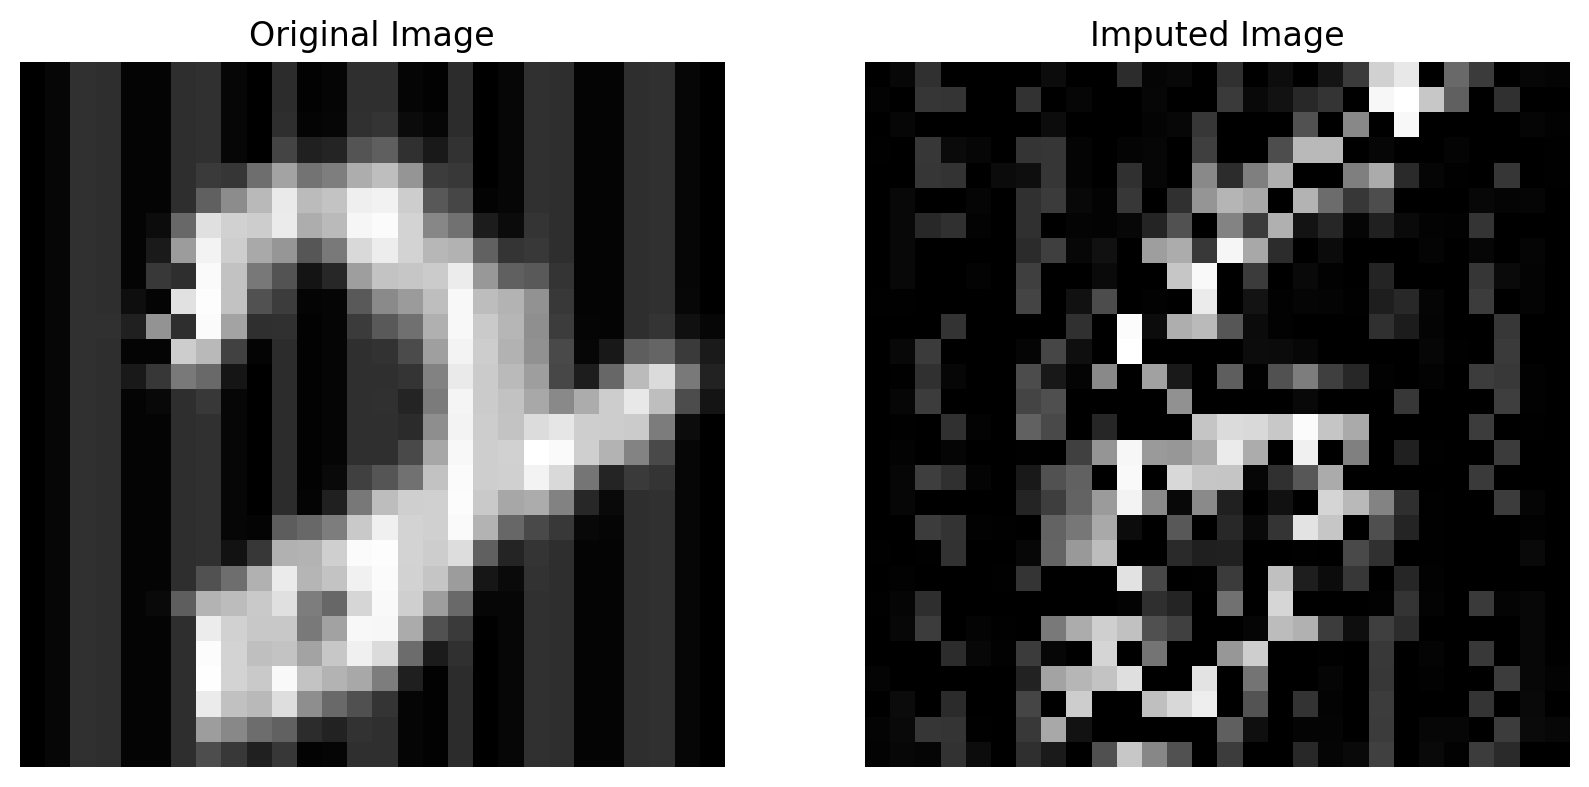


Sample 2:
Mean Squared Error (MSE): 0.0825
Structural Similarity Index (SSIM): 0.1242
Peak Signal-to-Noise Ratio (PSNR): 58.9681 dB


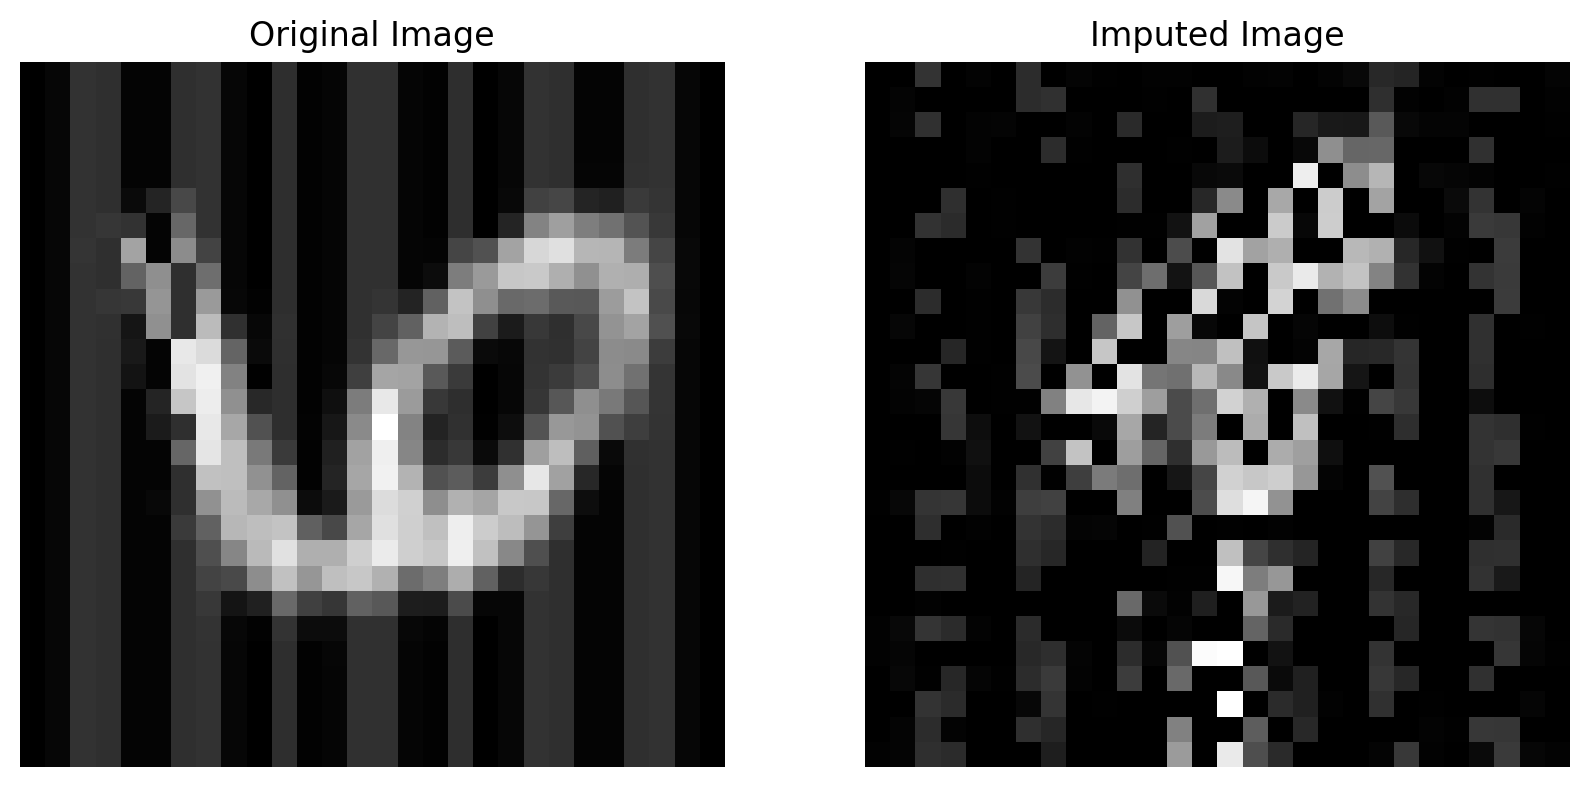


Sample 3:
Mean Squared Error (MSE): 0.0739
Structural Similarity Index (SSIM): 0.2081
Peak Signal-to-Noise Ratio (PSNR): 59.4420 dB


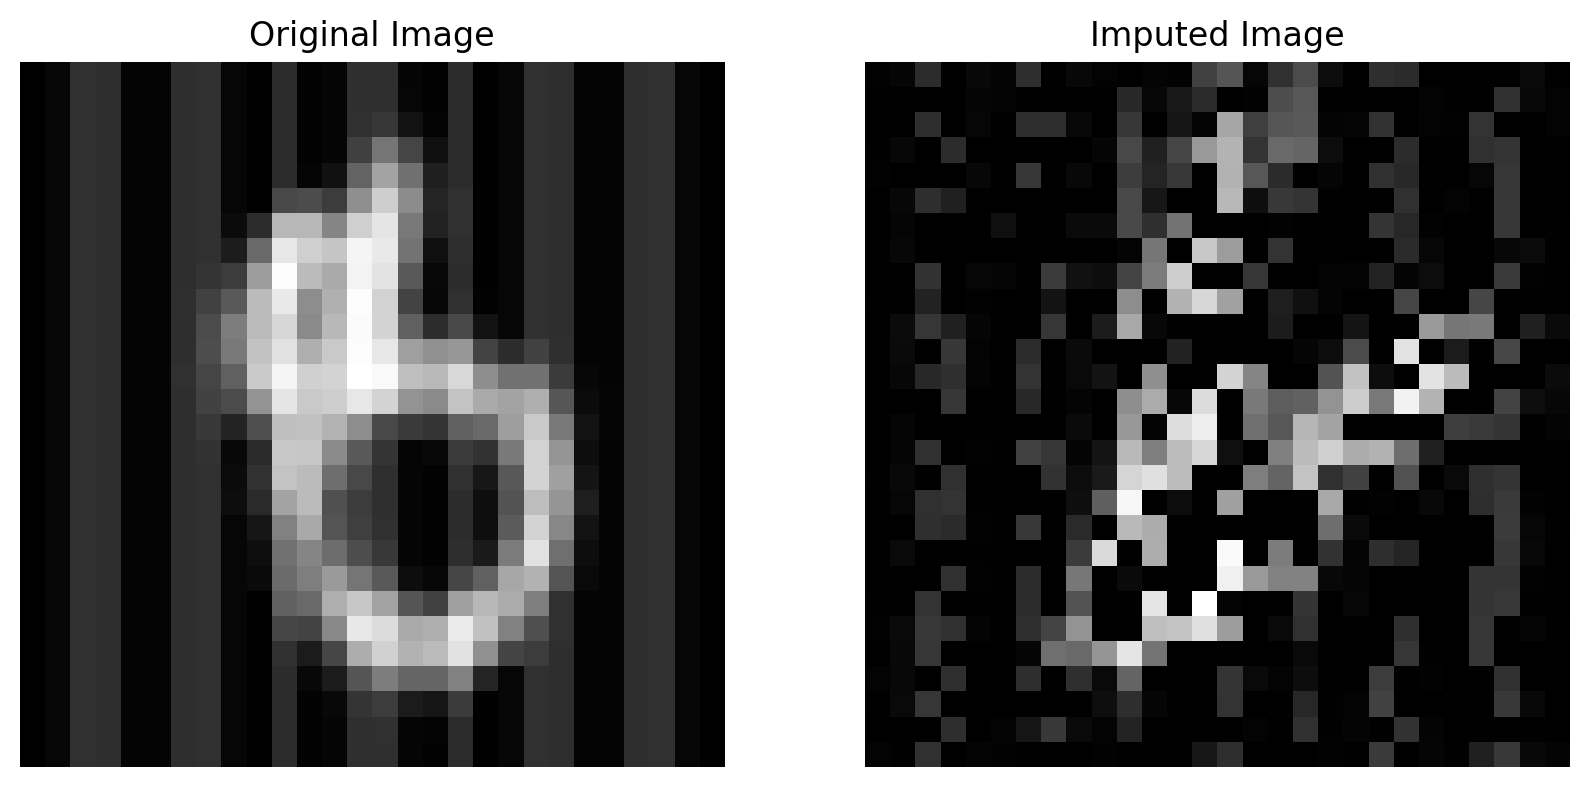


Sample 4:
Mean Squared Error (MSE): 0.0986
Structural Similarity Index (SSIM): 0.1644
Peak Signal-to-Noise Ratio (PSNR): 58.1927 dB


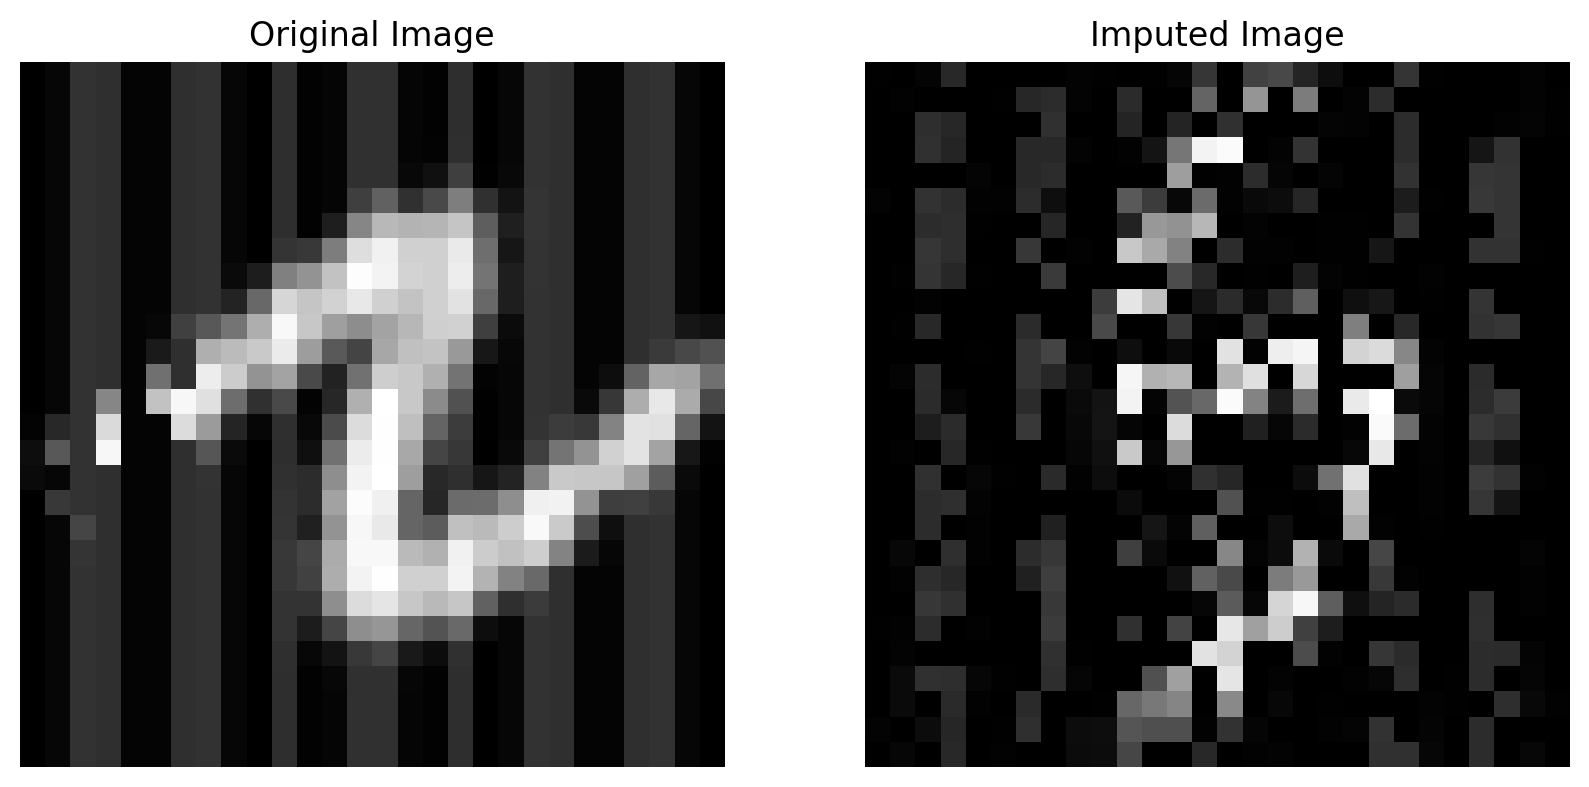


Sample 5:
Mean Squared Error (MSE): 0.0851
Structural Similarity Index (SSIM): 0.1463
Peak Signal-to-Noise Ratio (PSNR): 58.8317 dB


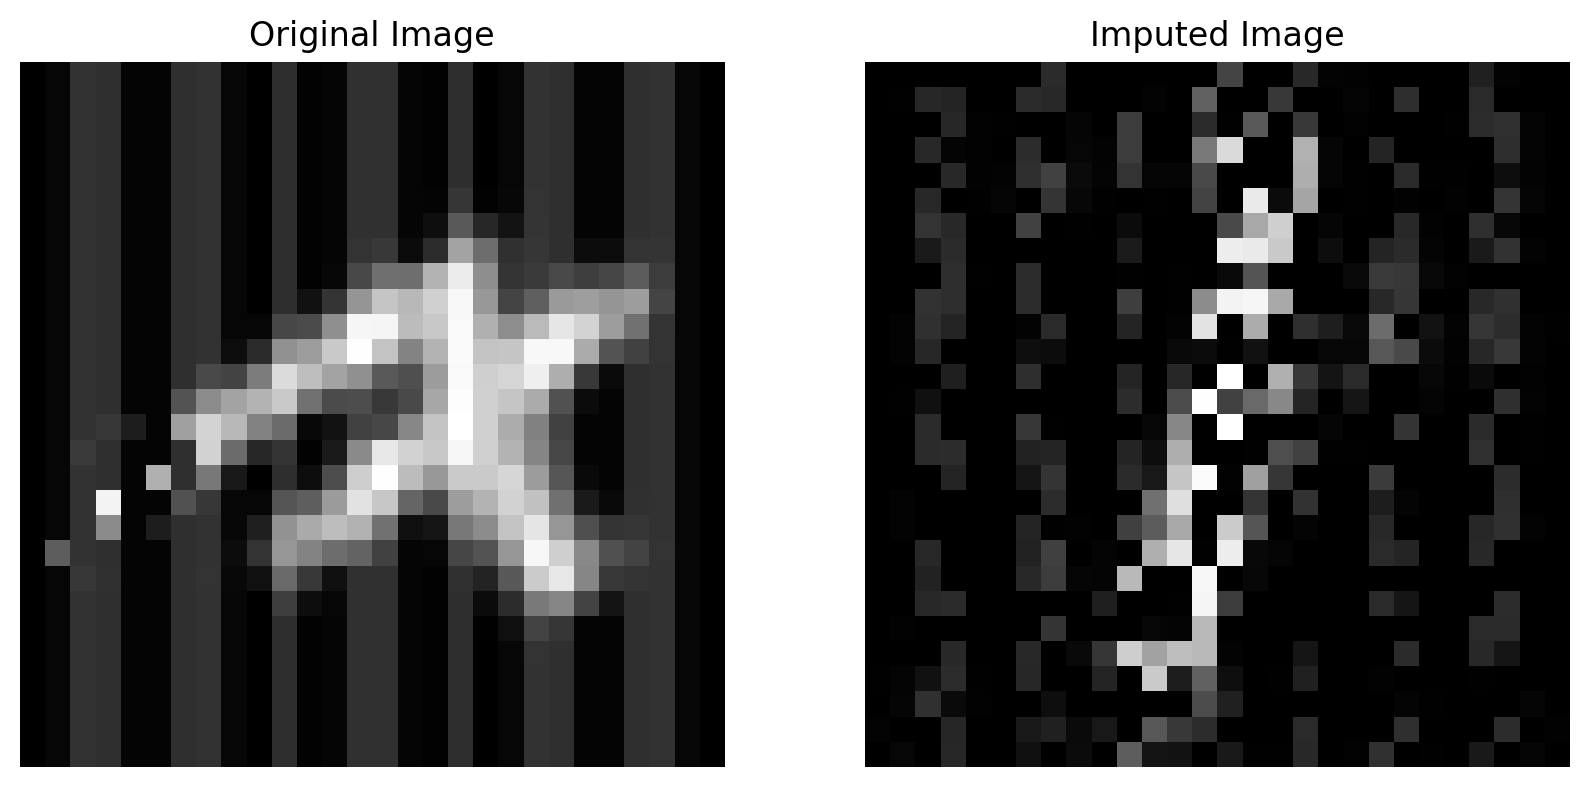

Epoch: 119


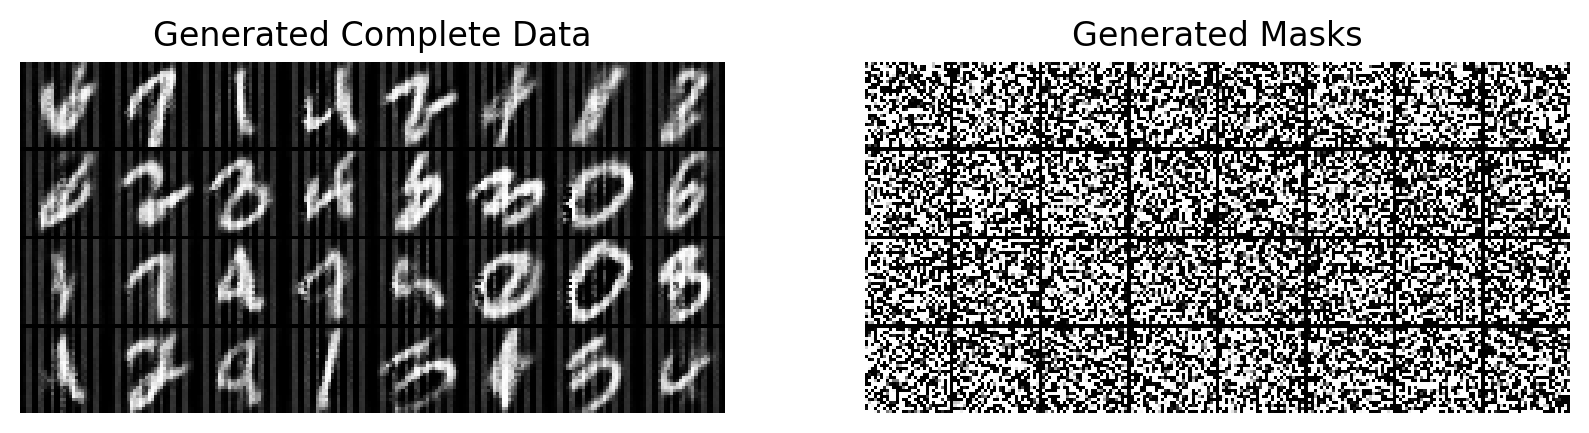


Sample 1:
Mean Squared Error (MSE): 0.0919
Structural Similarity Index (SSIM): 0.0980
Peak Signal-to-Noise Ratio (PSNR): 58.4975 dB


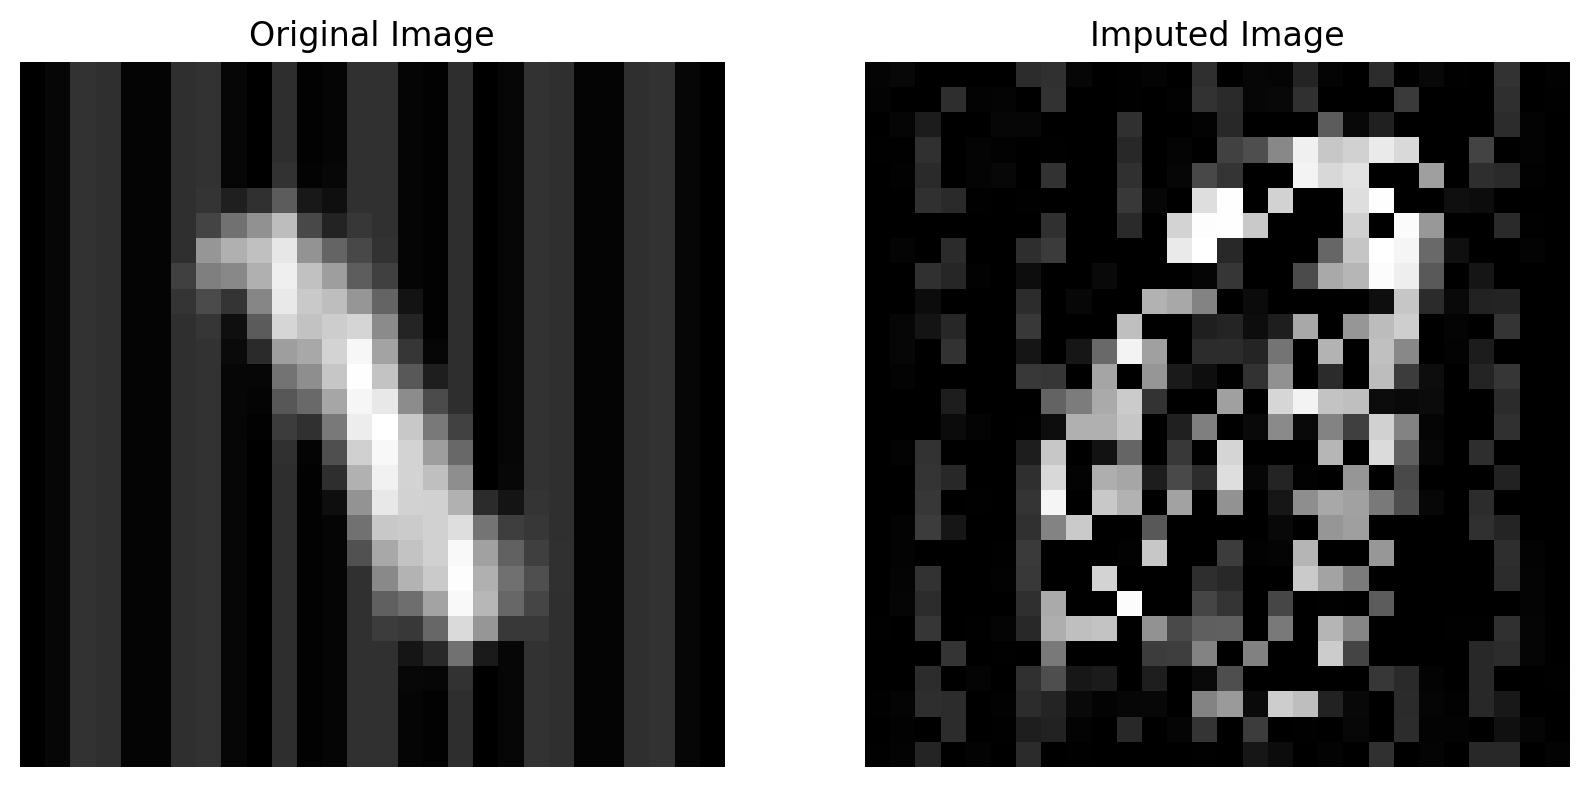


Sample 2:
Mean Squared Error (MSE): 0.0873
Structural Similarity Index (SSIM): 0.2851
Peak Signal-to-Noise Ratio (PSNR): 58.7192 dB


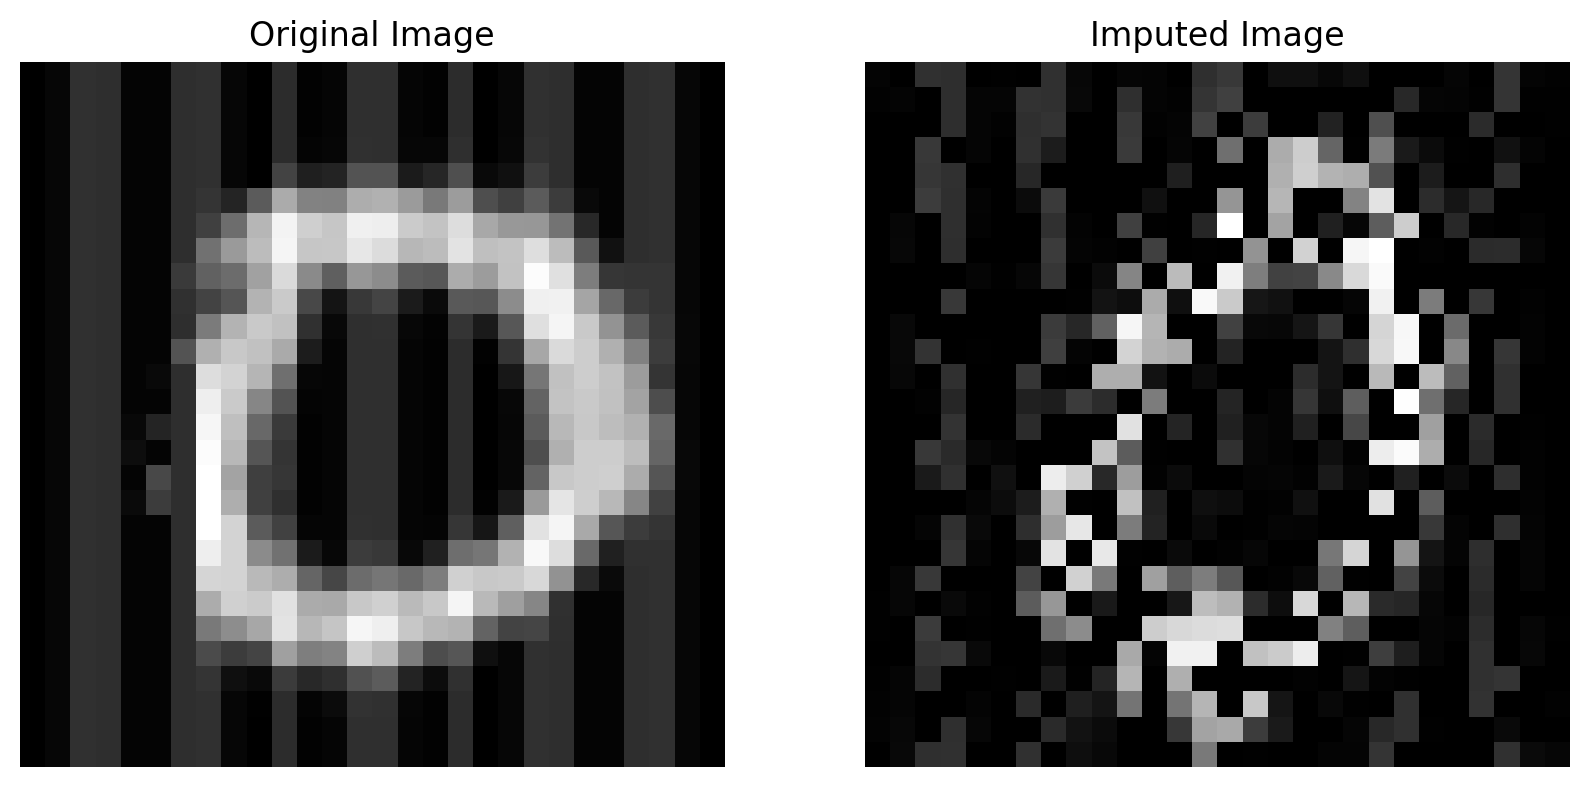


Sample 3:
Mean Squared Error (MSE): 0.1176
Structural Similarity Index (SSIM): 0.1190
Peak Signal-to-Noise Ratio (PSNR): 57.4271 dB


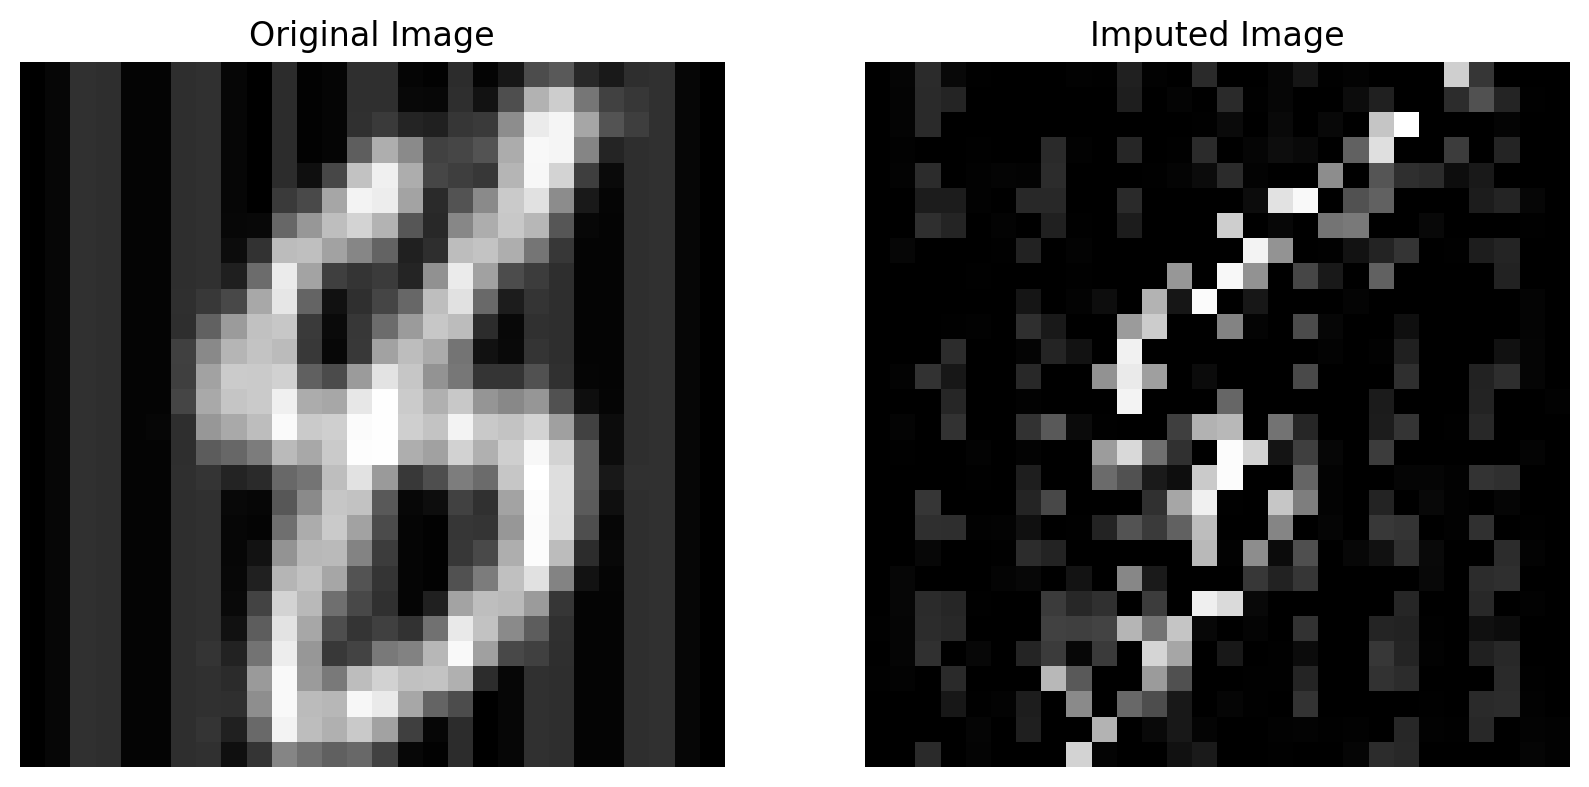


Sample 4:
Mean Squared Error (MSE): 0.0805
Structural Similarity Index (SSIM): 0.0577
Peak Signal-to-Noise Ratio (PSNR): 59.0733 dB


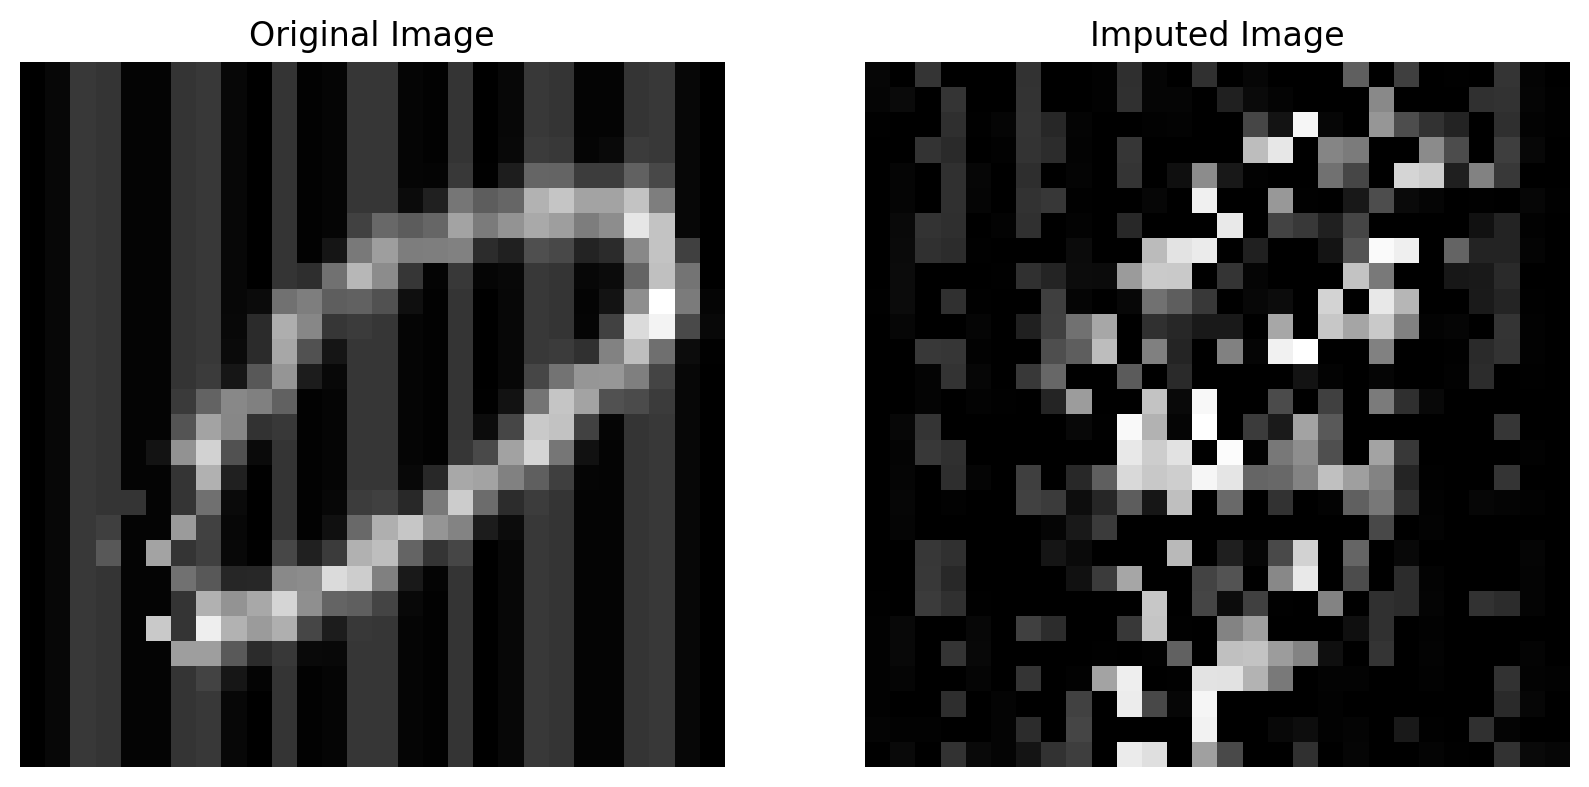


Sample 5:
Mean Squared Error (MSE): 0.1246
Structural Similarity Index (SSIM): 0.1447
Peak Signal-to-Noise Ratio (PSNR): 57.1756 dB


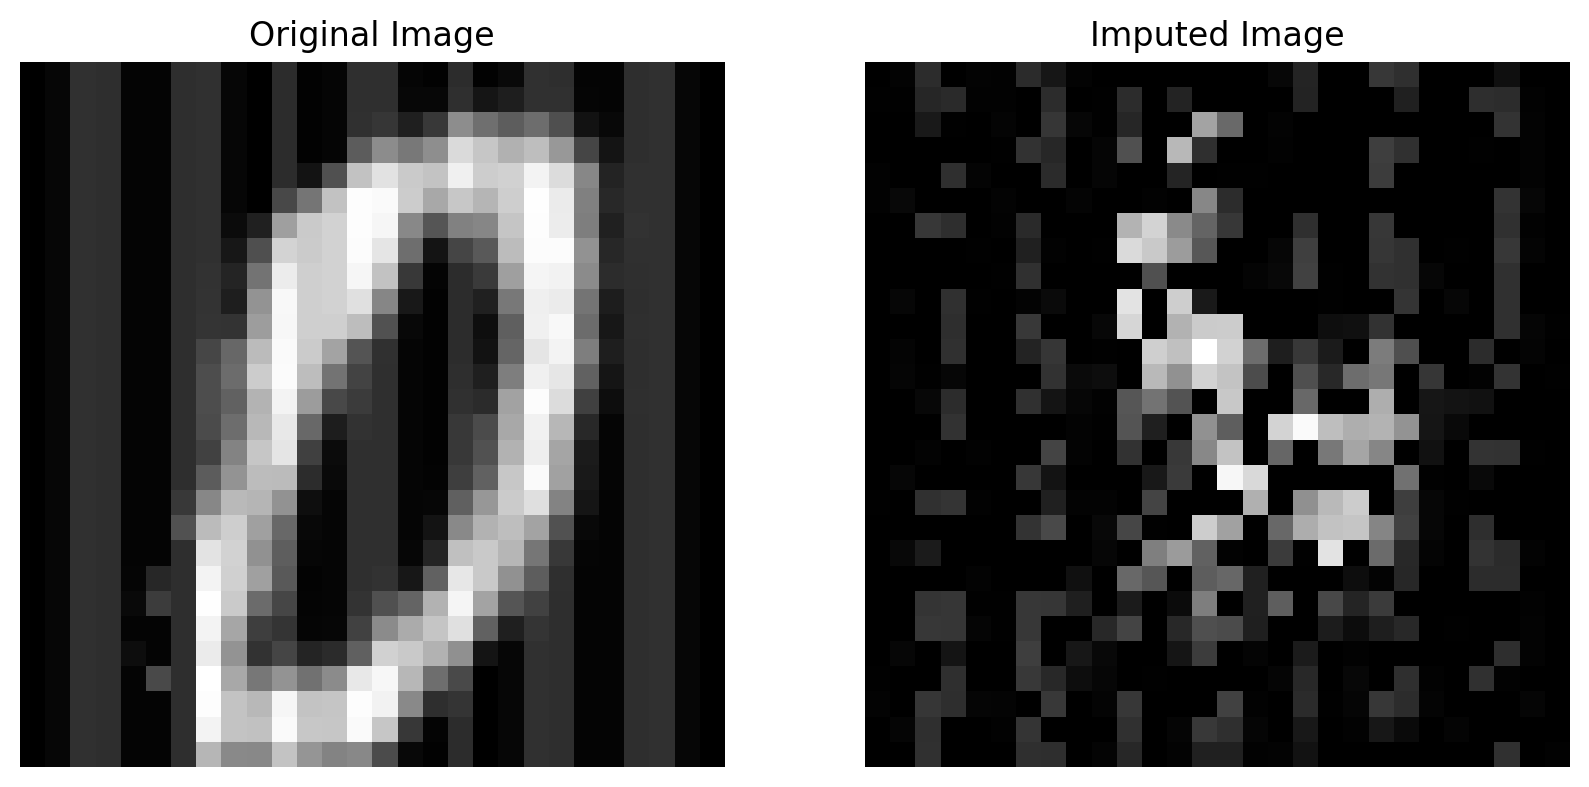

Epoch: 139


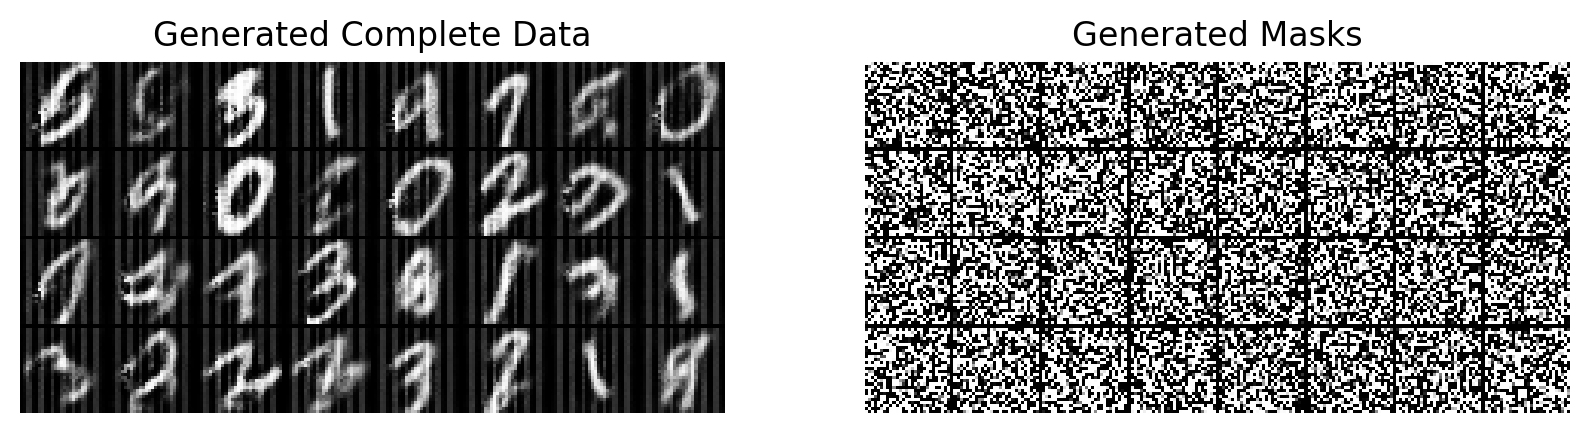


Sample 1:
Mean Squared Error (MSE): 0.0797
Structural Similarity Index (SSIM): 0.1417
Peak Signal-to-Noise Ratio (PSNR): 59.1160 dB


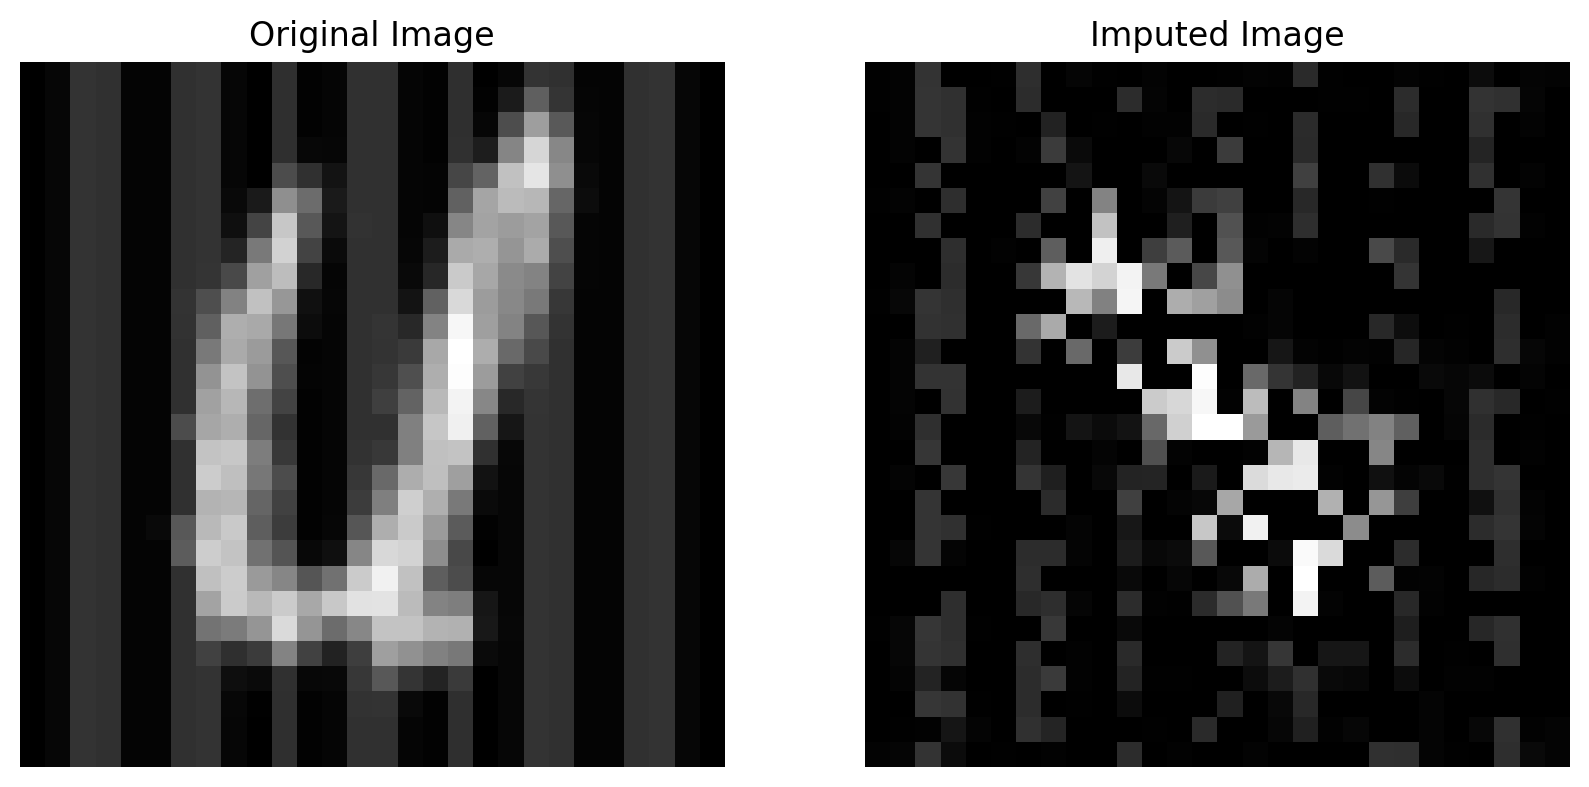


Sample 2:
Mean Squared Error (MSE): 0.1106
Structural Similarity Index (SSIM): 0.1470
Peak Signal-to-Noise Ratio (PSNR): 57.6925 dB


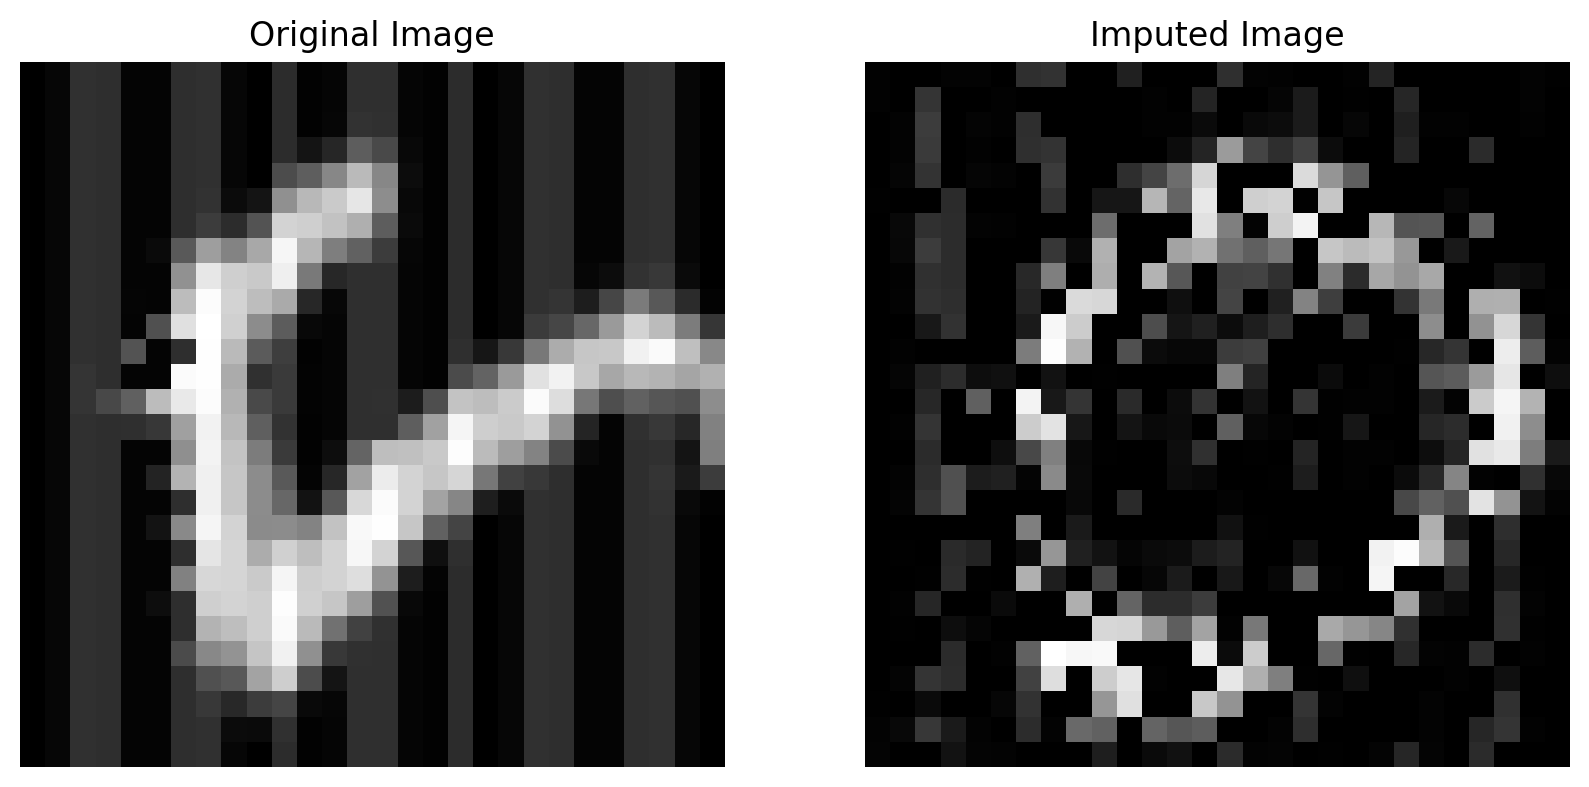


Sample 3:
Mean Squared Error (MSE): 0.0639
Structural Similarity Index (SSIM): 0.2085
Peak Signal-to-Noise Ratio (PSNR): 60.0788 dB


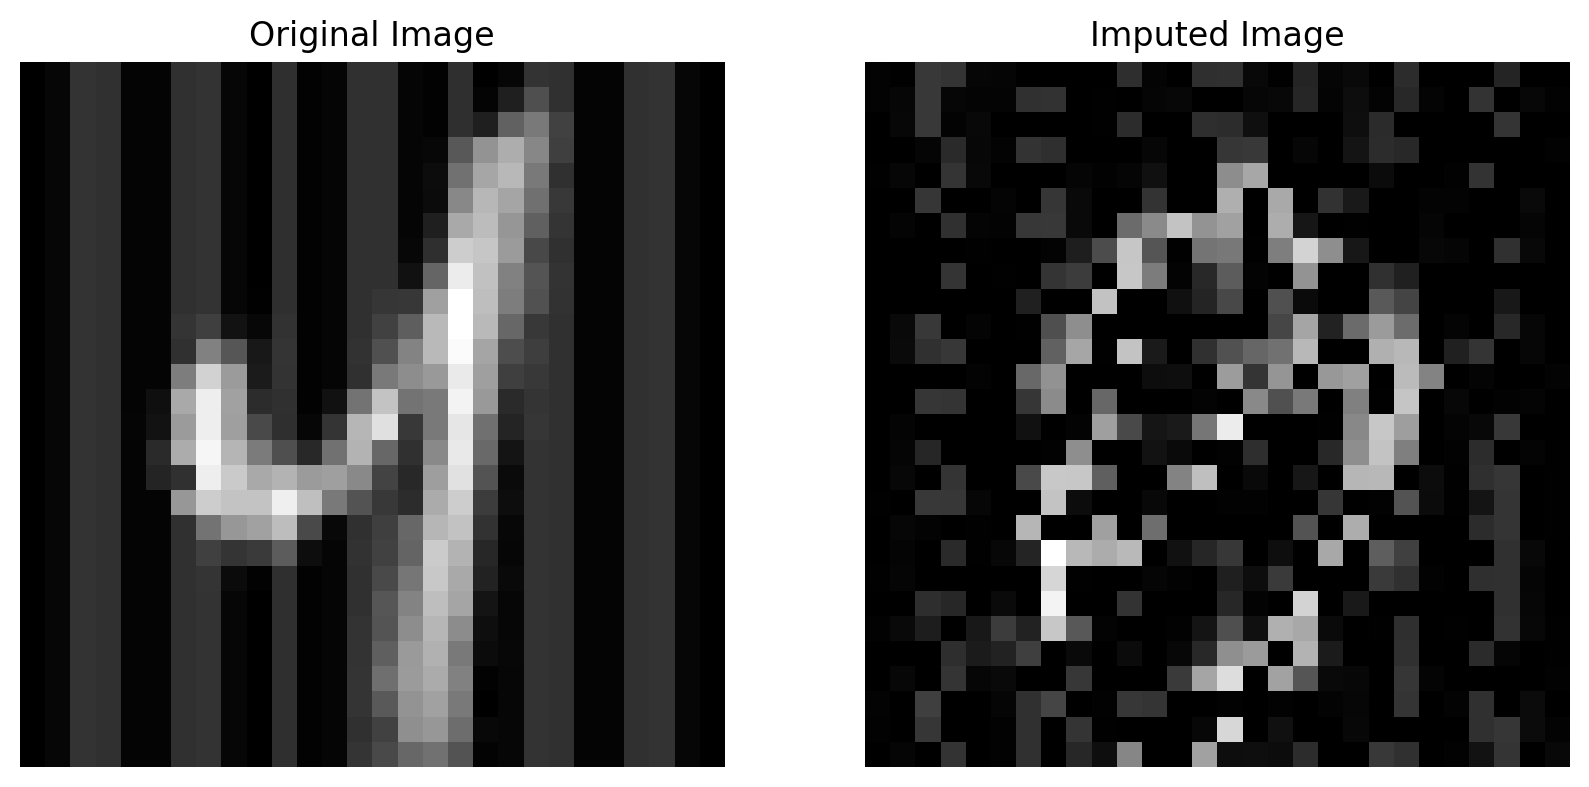


Sample 4:
Mean Squared Error (MSE): 0.1206
Structural Similarity Index (SSIM): 0.2216
Peak Signal-to-Noise Ratio (PSNR): 57.3173 dB


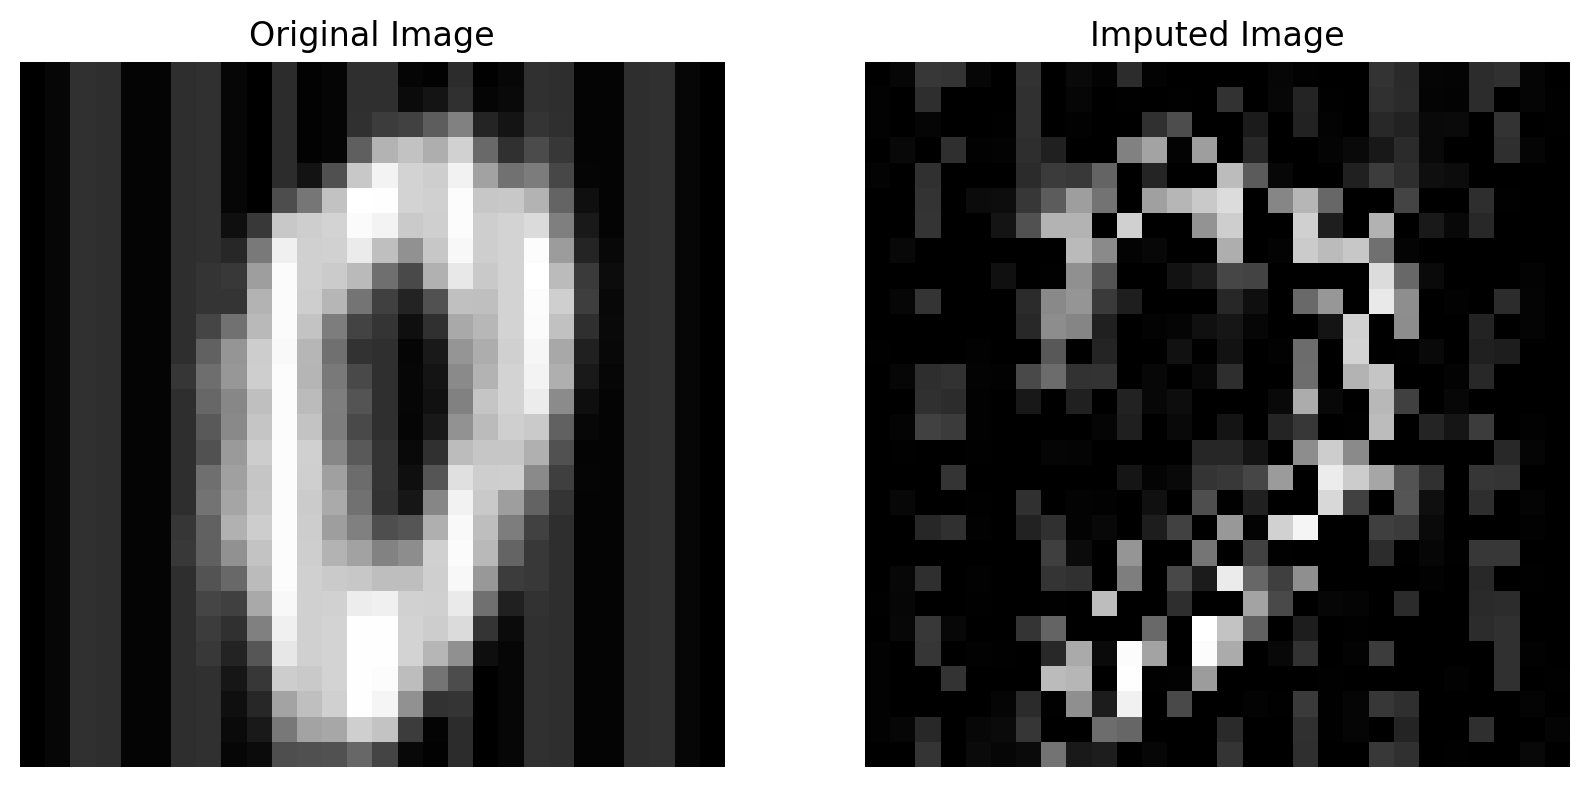


Sample 5:
Mean Squared Error (MSE): 0.0880
Structural Similarity Index (SSIM): 0.1036
Peak Signal-to-Noise Ratio (PSNR): 58.6853 dB


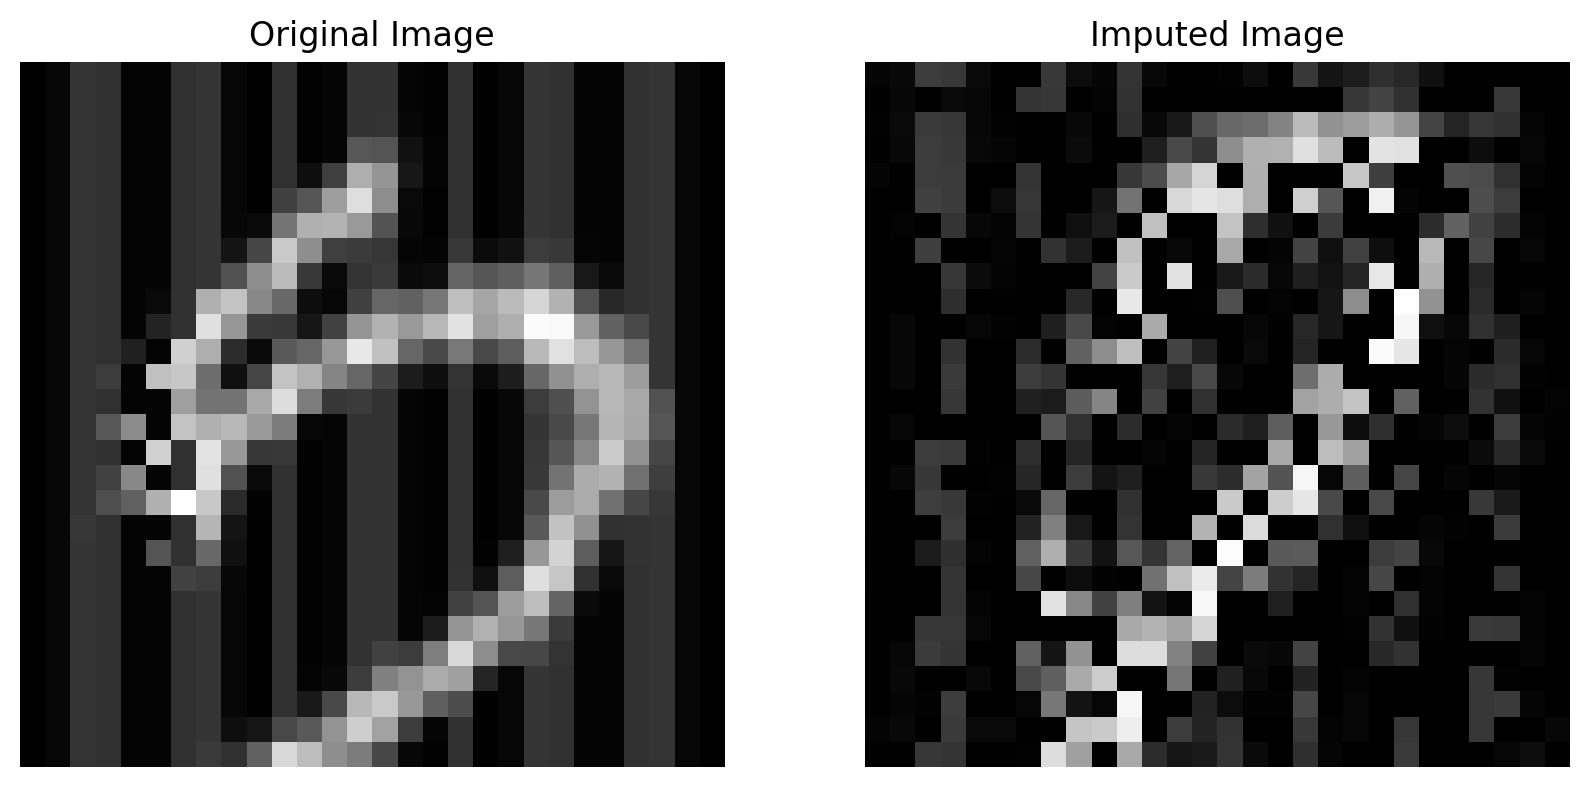

Epoch: 159


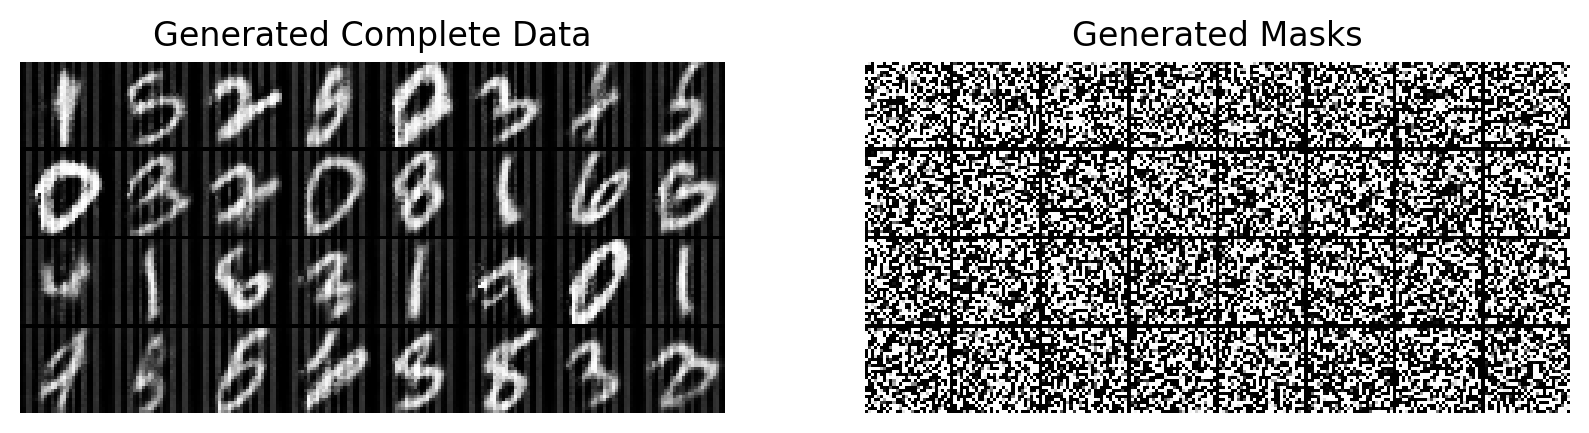


Sample 1:
Mean Squared Error (MSE): 0.0837
Structural Similarity Index (SSIM): 0.0980
Peak Signal-to-Noise Ratio (PSNR): 58.9014 dB


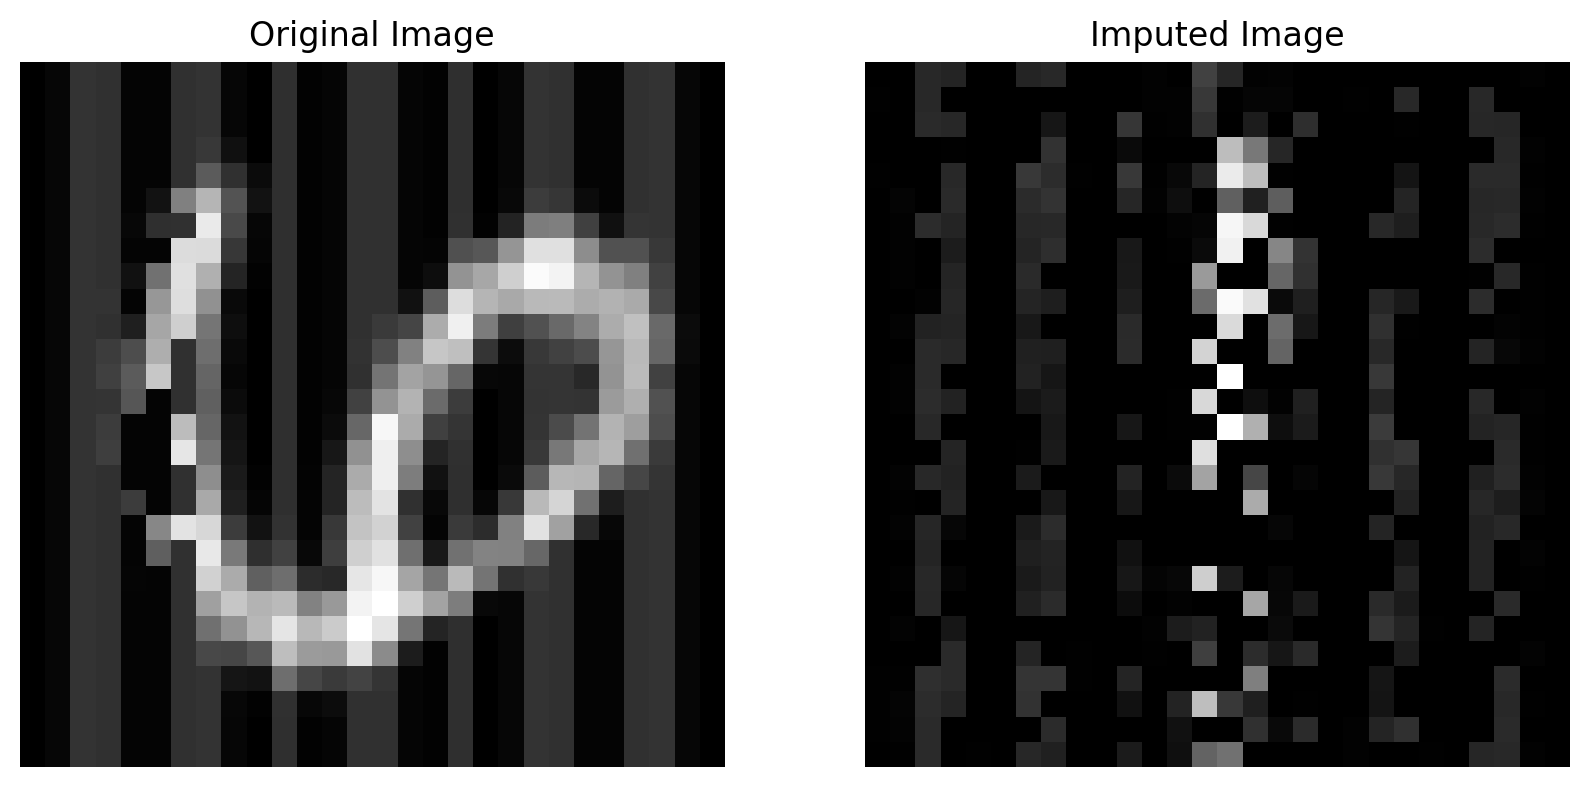


Sample 2:
Mean Squared Error (MSE): 0.0653
Structural Similarity Index (SSIM): 0.1935
Peak Signal-to-Noise Ratio (PSNR): 59.9813 dB


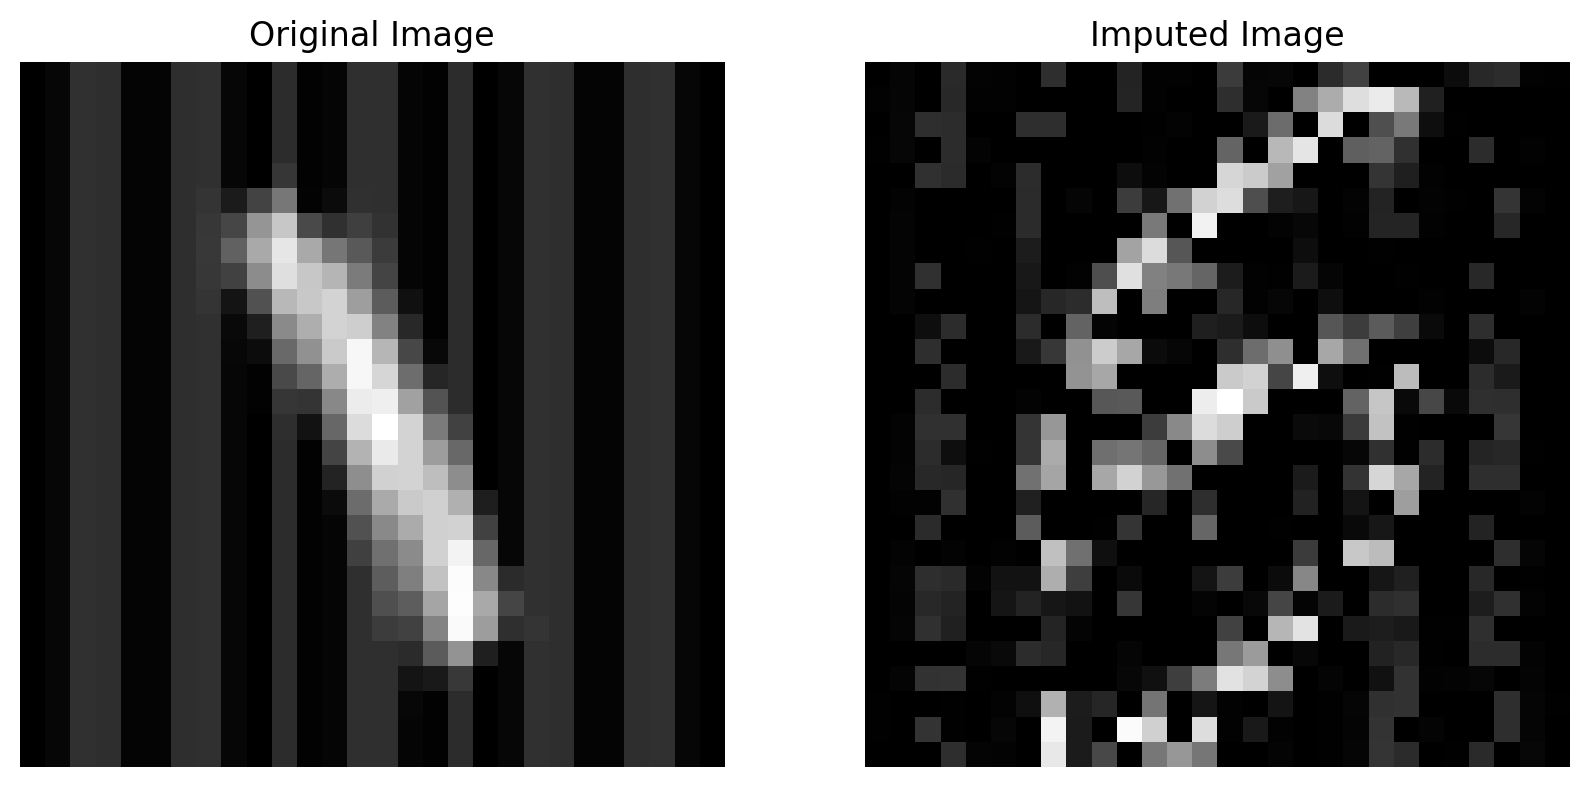


Sample 3:
Mean Squared Error (MSE): 0.1127
Structural Similarity Index (SSIM): 0.1598
Peak Signal-to-Noise Ratio (PSNR): 57.6120 dB


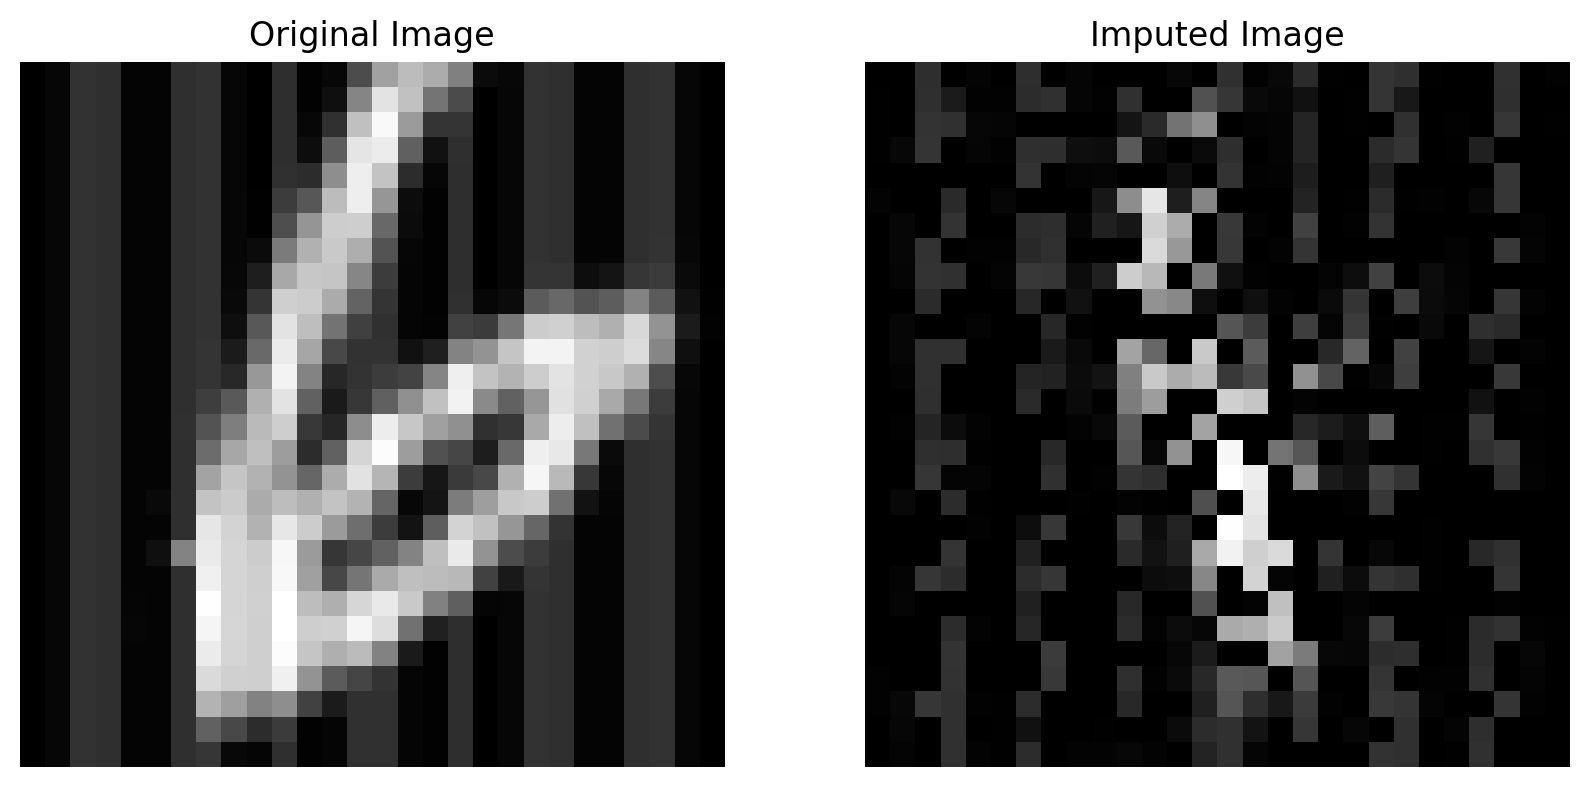


Sample 4:
Mean Squared Error (MSE): 0.0896
Structural Similarity Index (SSIM): 0.1671
Peak Signal-to-Noise Ratio (PSNR): 58.6072 dB


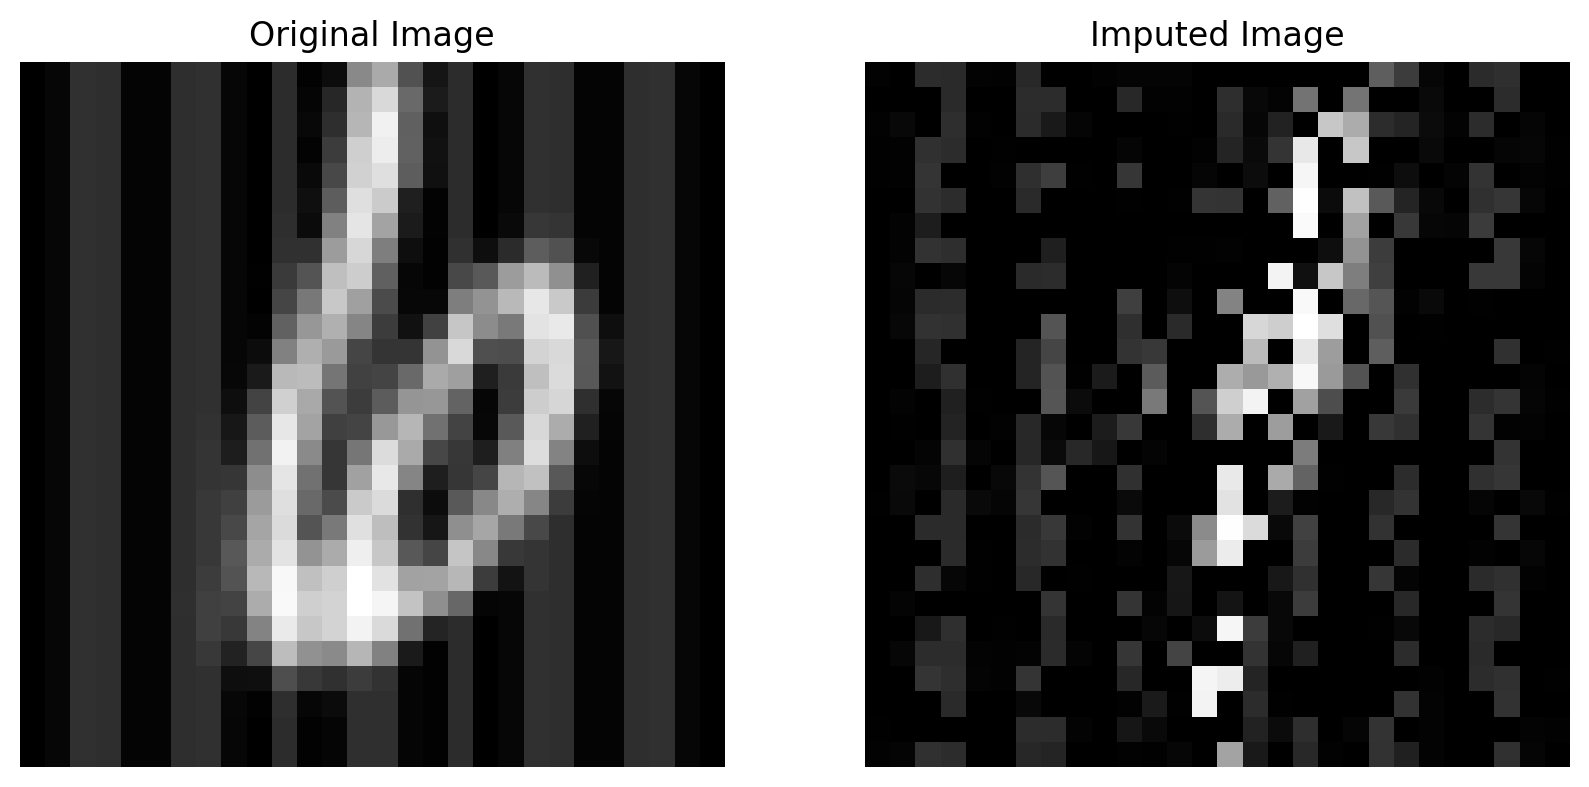


Sample 5:
Mean Squared Error (MSE): 0.0658
Structural Similarity Index (SSIM): 0.1870
Peak Signal-to-Noise Ratio (PSNR): 59.9472 dB


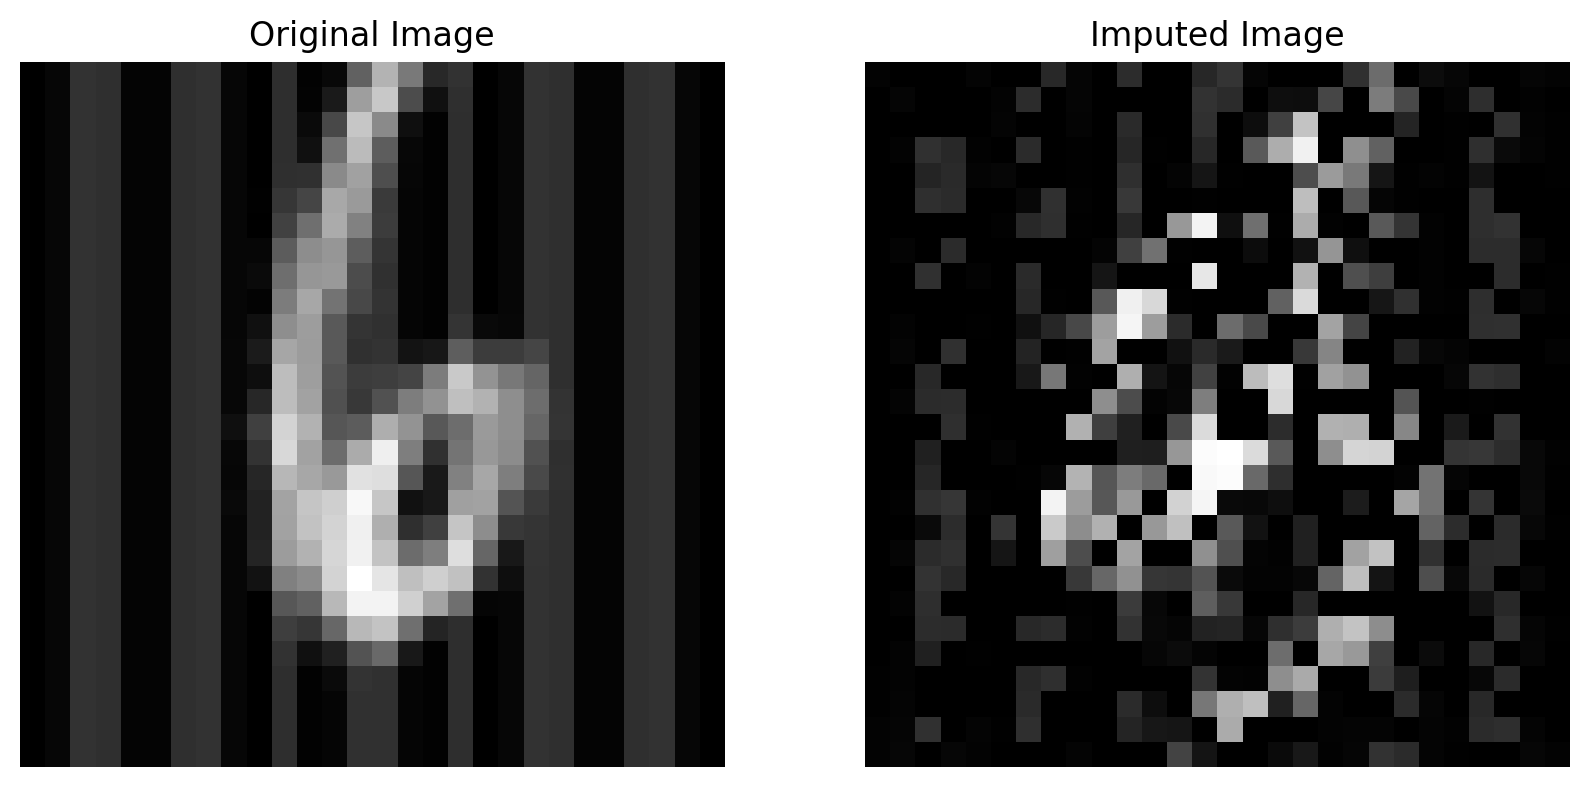

Epoch: 179


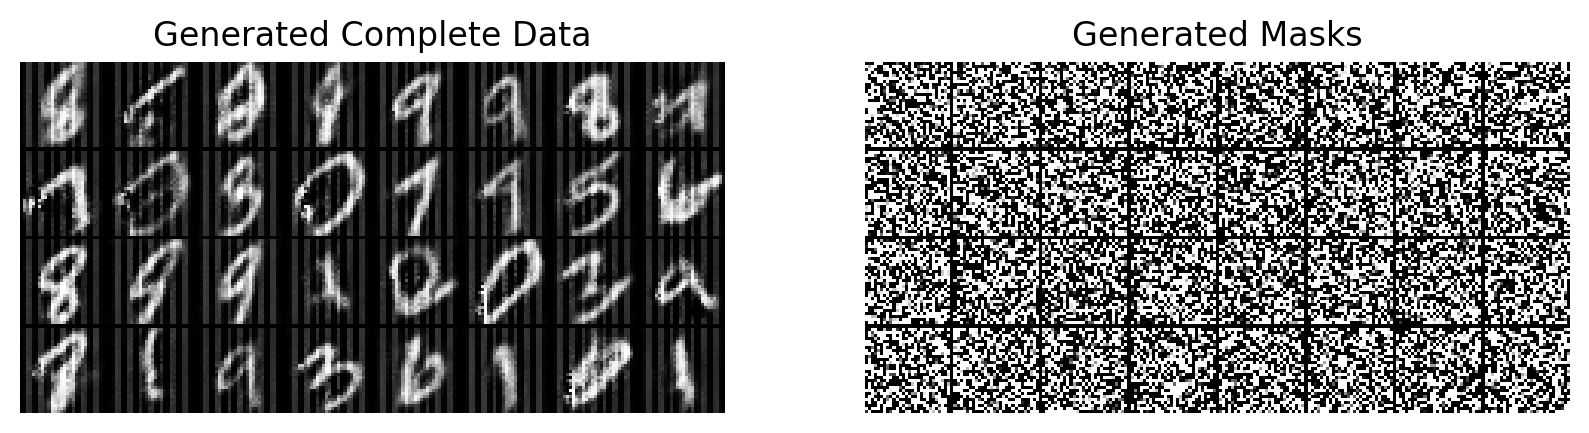


Sample 1:
Mean Squared Error (MSE): 0.0488
Structural Similarity Index (SSIM): 0.2715
Peak Signal-to-Noise Ratio (PSNR): 61.2486 dB


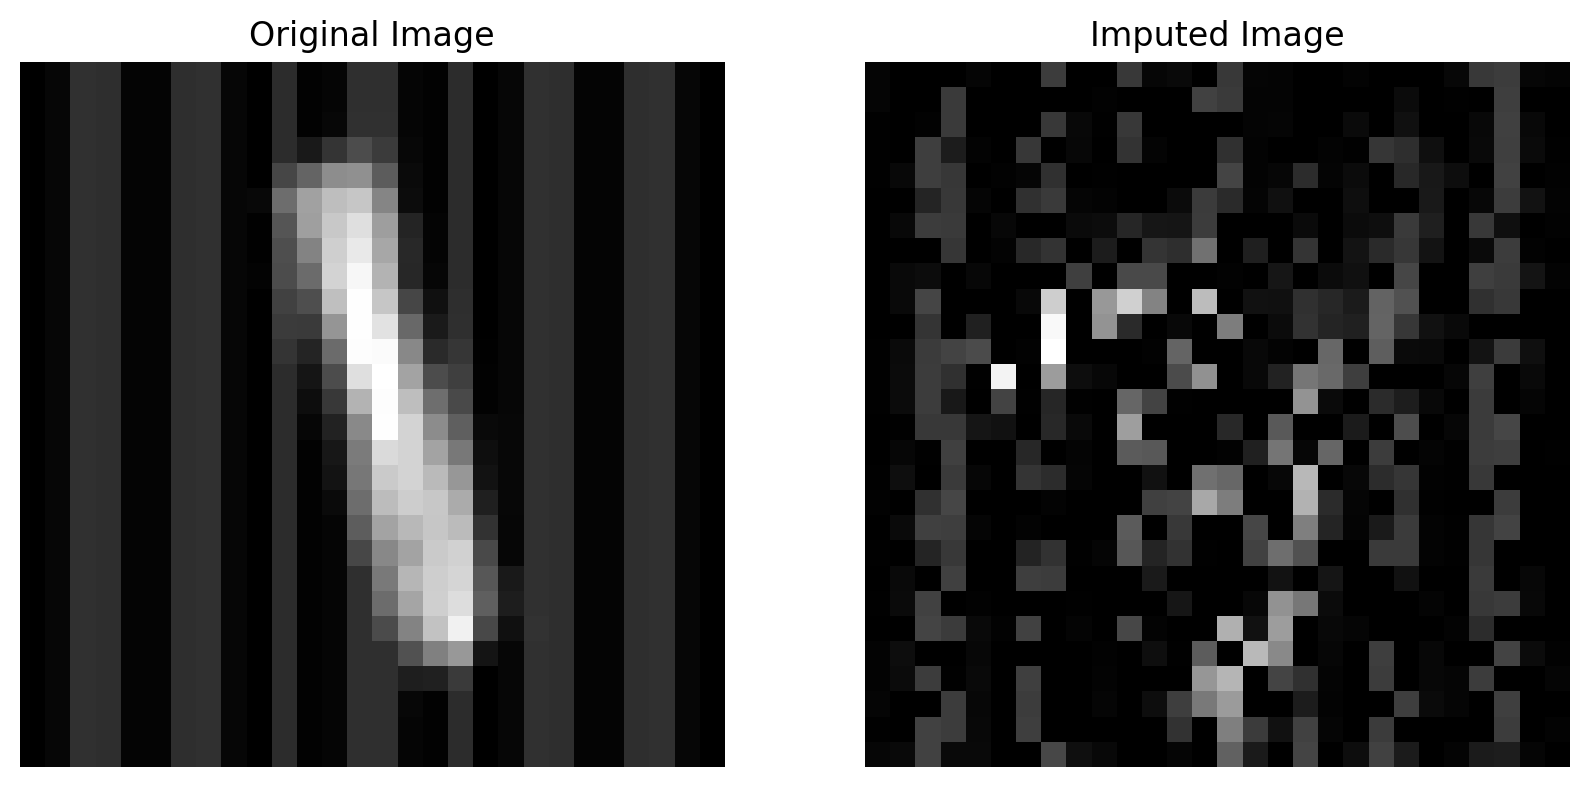


Sample 2:
Mean Squared Error (MSE): 0.0562
Structural Similarity Index (SSIM): 0.1286
Peak Signal-to-Noise Ratio (PSNR): 60.6320 dB


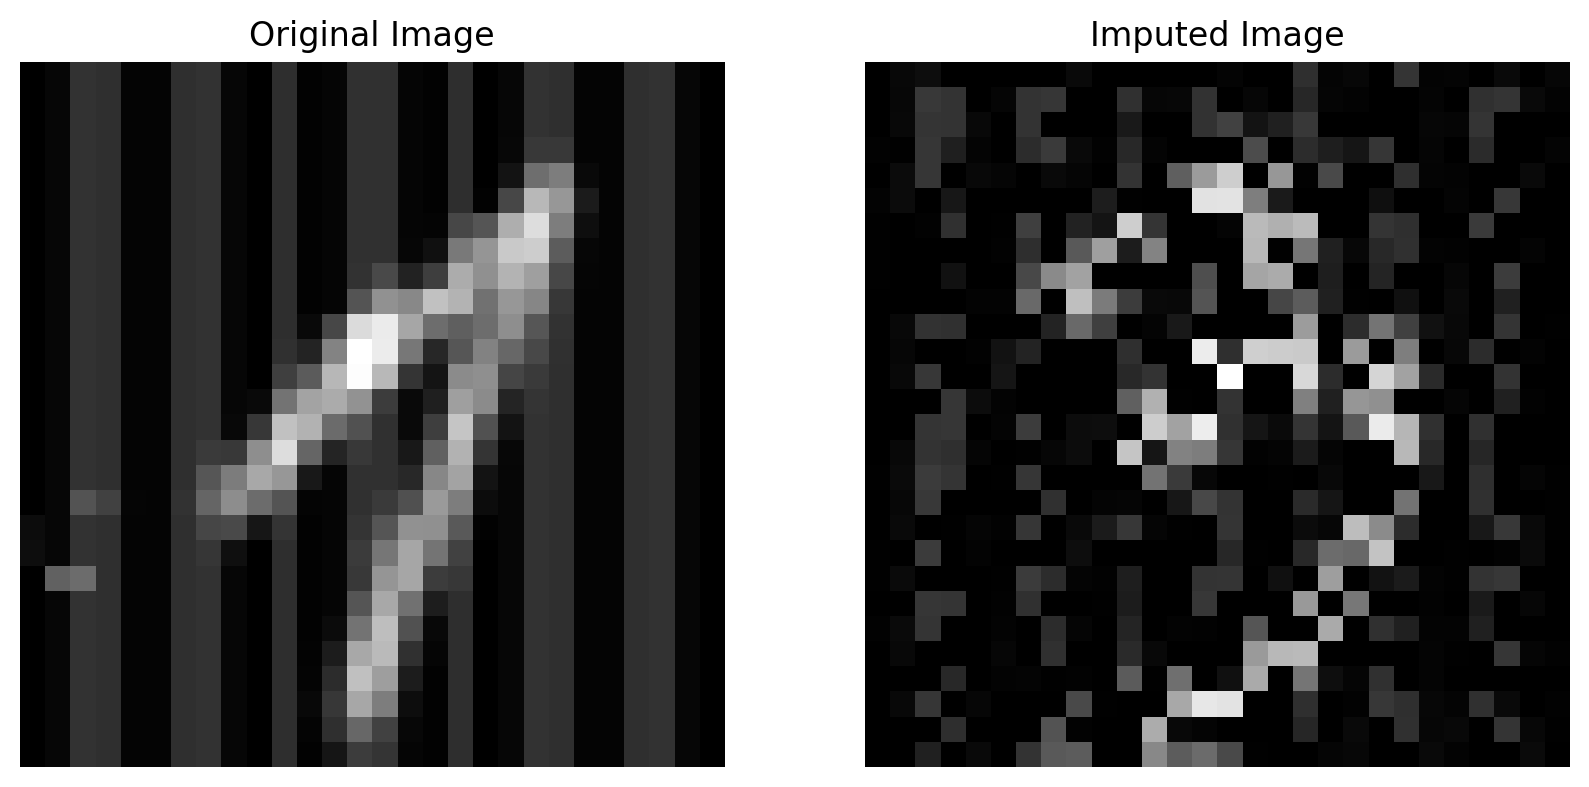


Sample 3:
Mean Squared Error (MSE): 0.0922
Structural Similarity Index (SSIM): 0.0977
Peak Signal-to-Noise Ratio (PSNR): 58.4833 dB


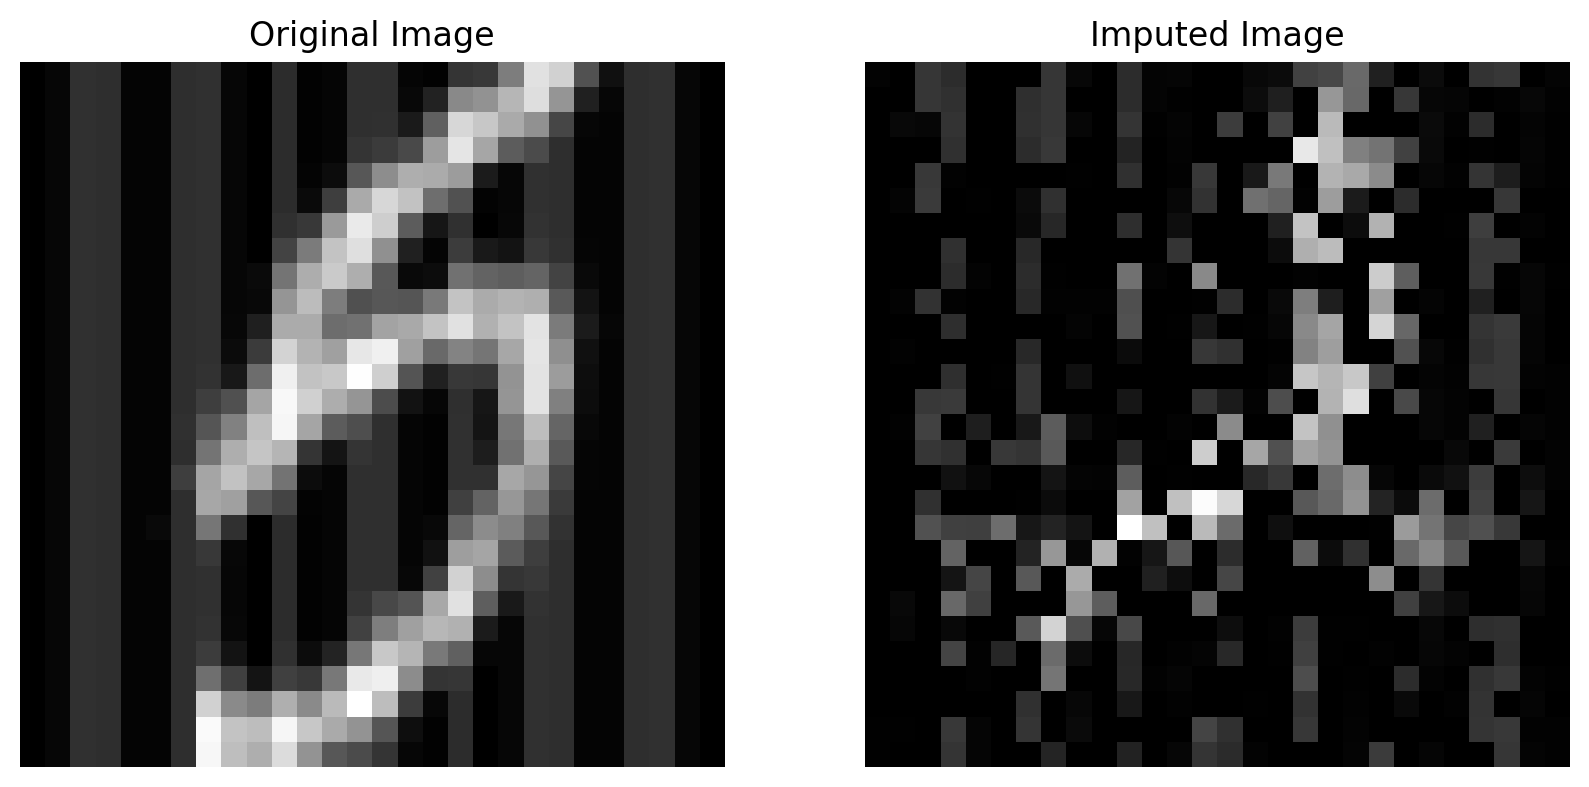


Sample 4:
Mean Squared Error (MSE): 0.1287
Structural Similarity Index (SSIM): 0.0622
Peak Signal-to-Noise Ratio (PSNR): 57.0355 dB


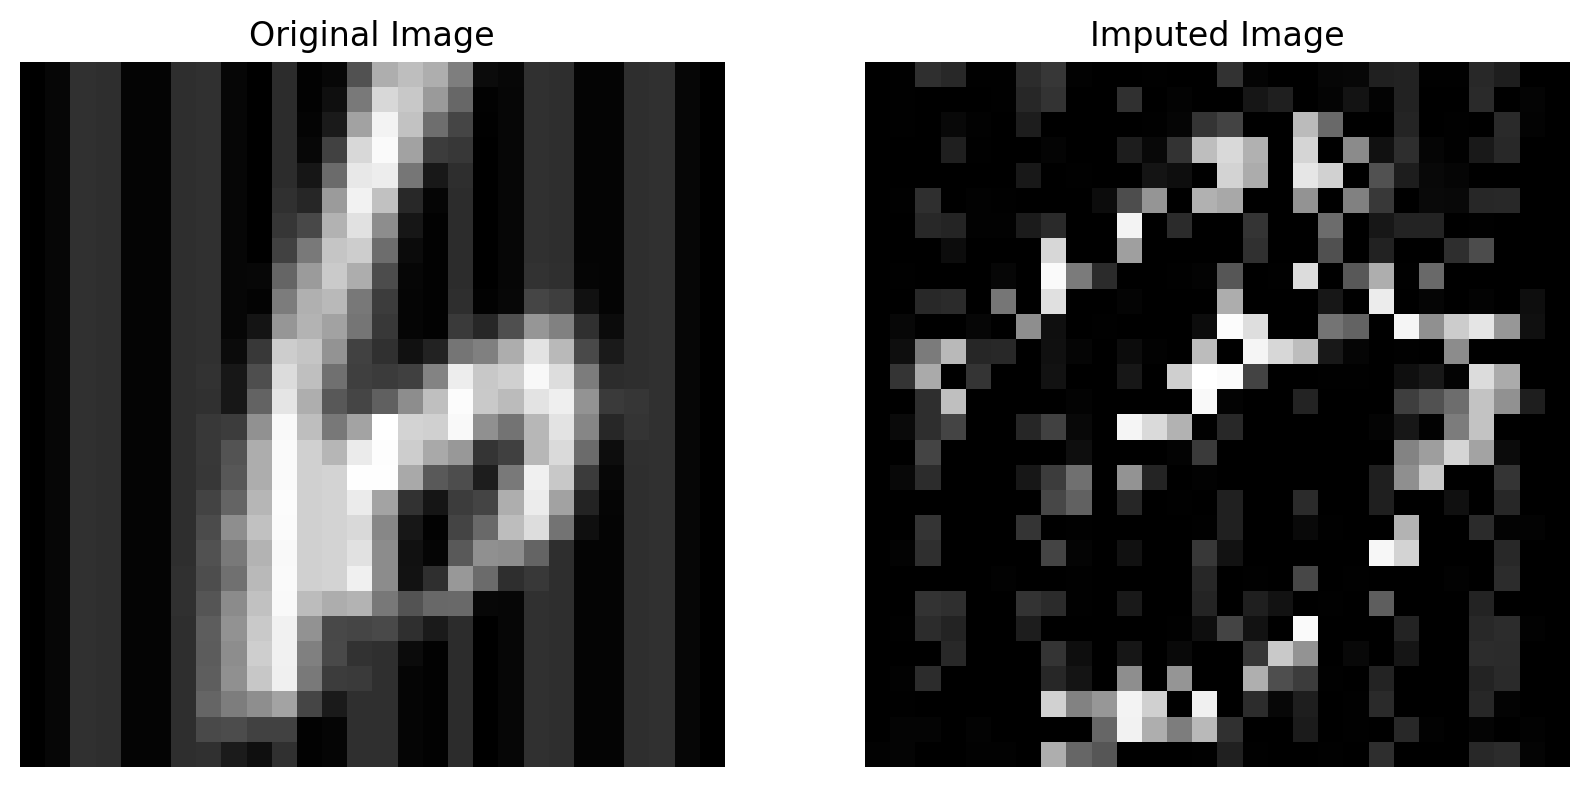


Sample 5:
Mean Squared Error (MSE): 0.0913
Structural Similarity Index (SSIM): 0.2292
Peak Signal-to-Noise Ratio (PSNR): 58.5250 dB


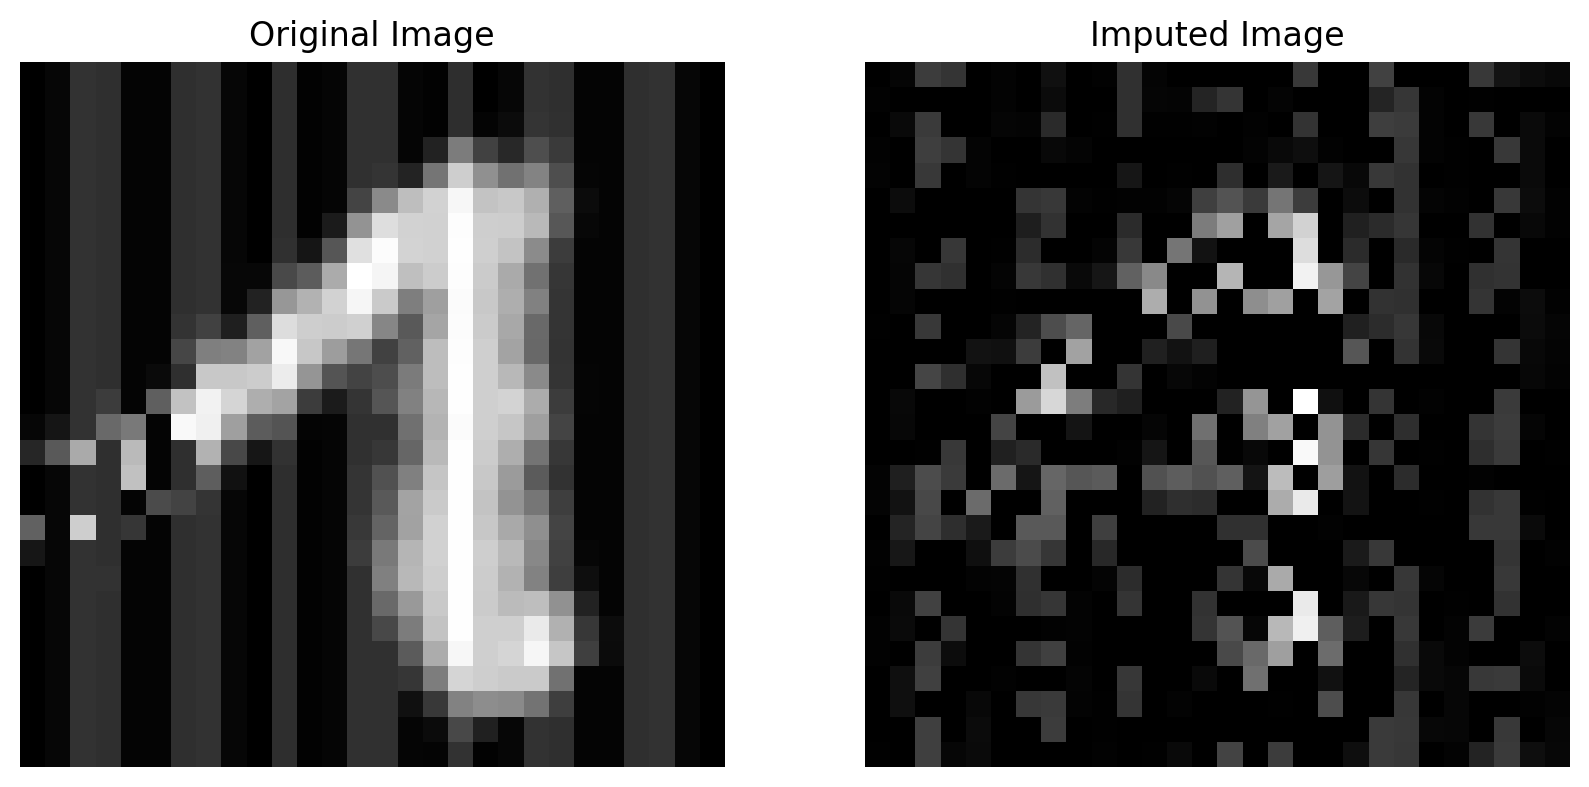

Epoch: 199


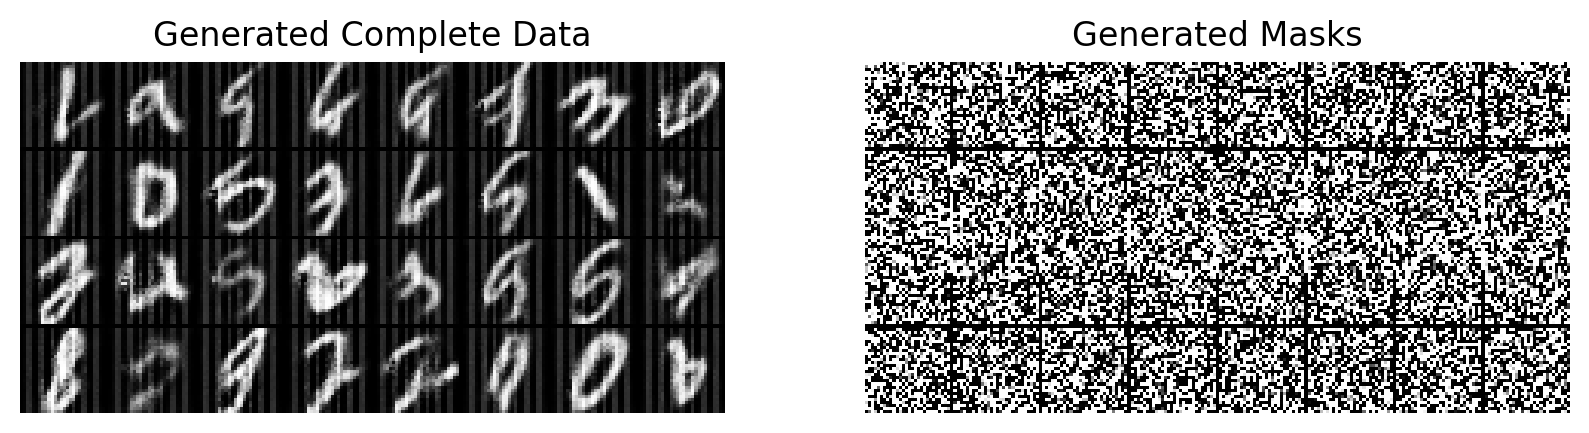


Sample 1:
Mean Squared Error (MSE): 0.0924
Structural Similarity Index (SSIM): 0.1559
Peak Signal-to-Noise Ratio (PSNR): 58.4718 dB


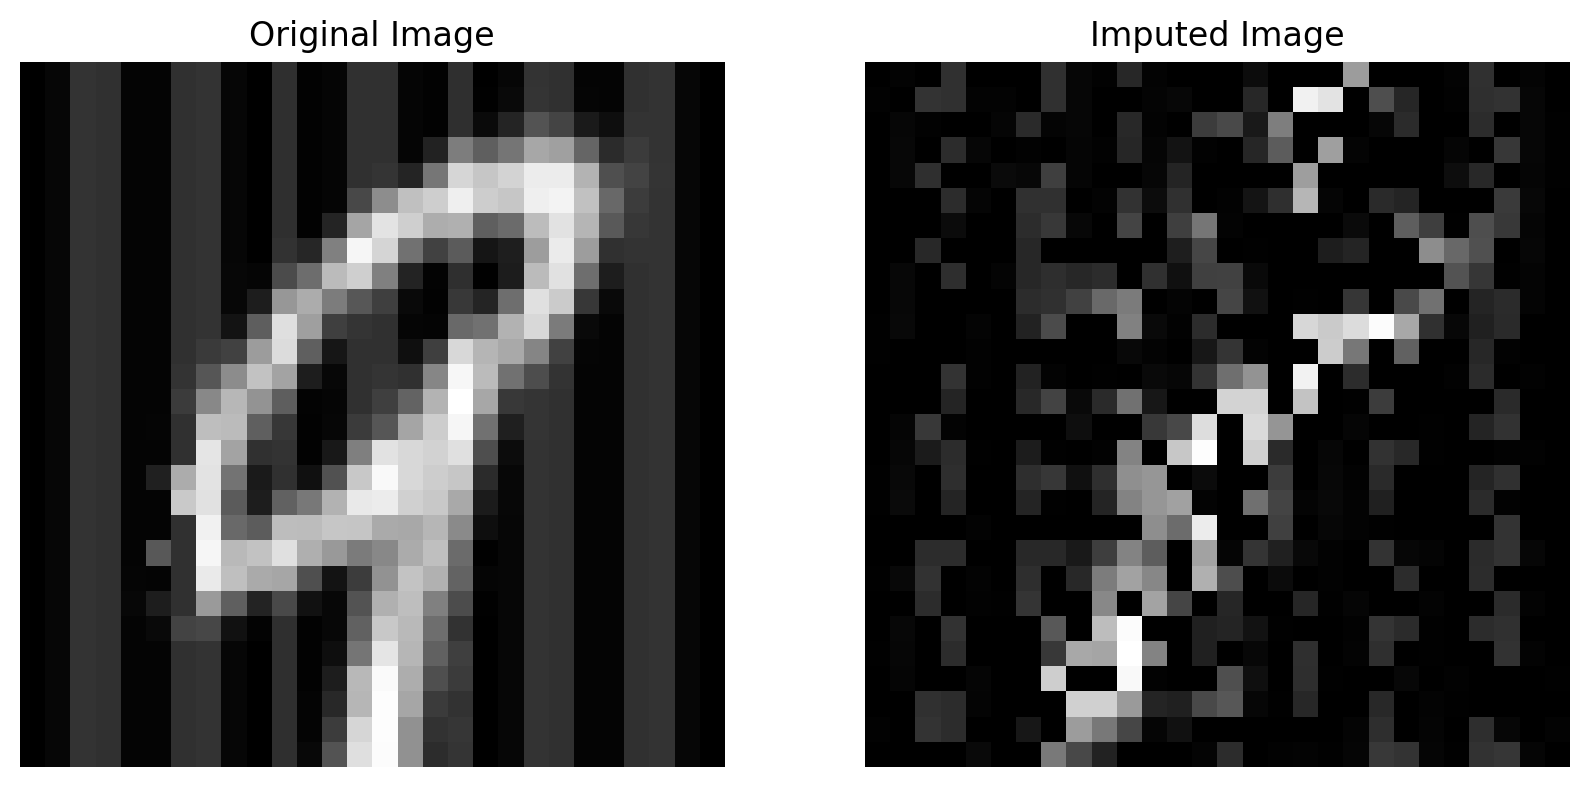


Sample 2:
Mean Squared Error (MSE): 0.1004
Structural Similarity Index (SSIM): 0.1298
Peak Signal-to-Noise Ratio (PSNR): 58.1121 dB


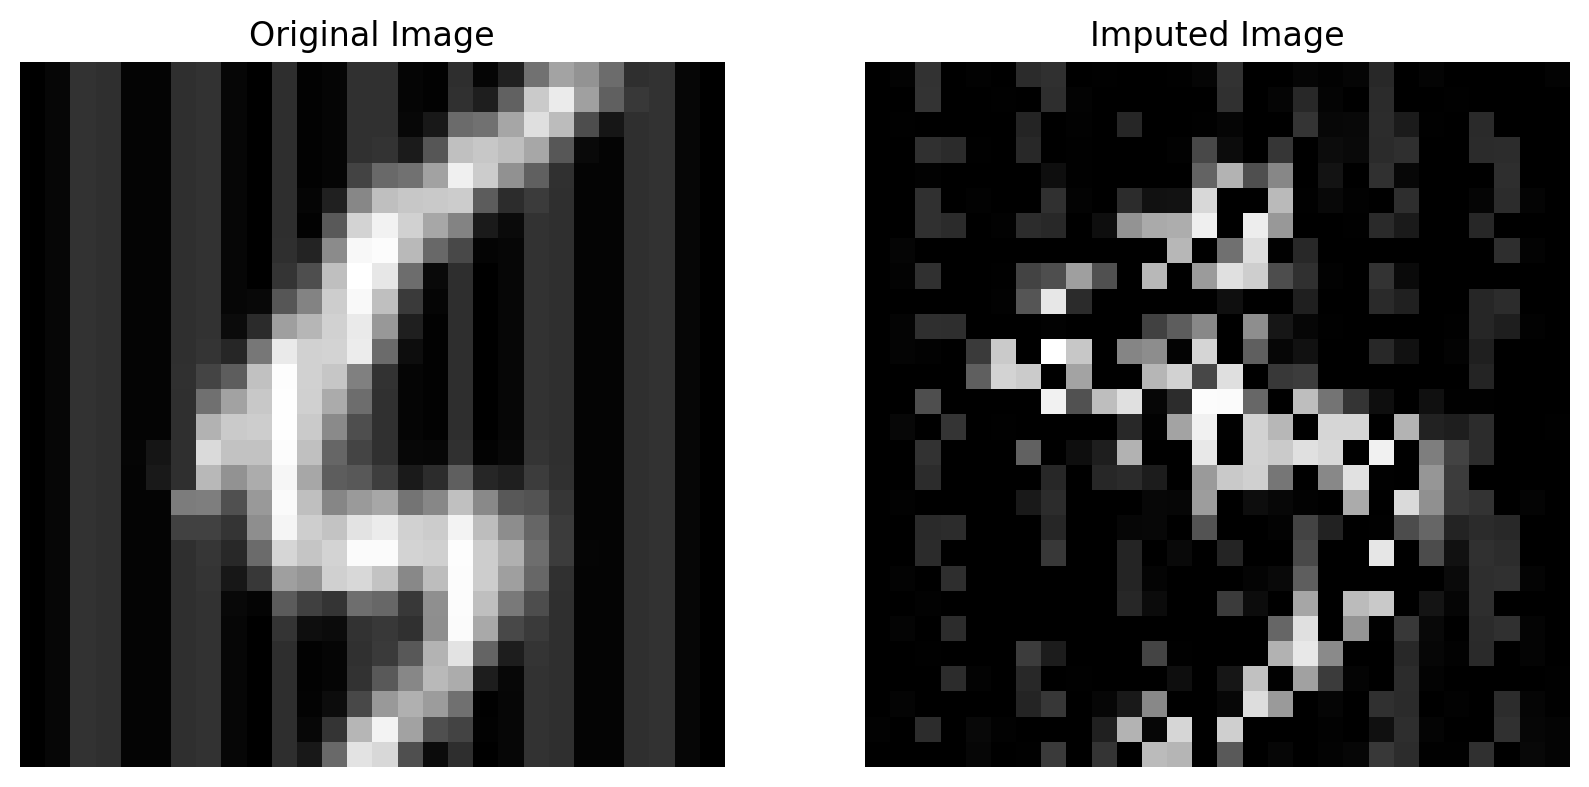


Sample 3:
Mean Squared Error (MSE): 0.0785
Structural Similarity Index (SSIM): 0.2993
Peak Signal-to-Noise Ratio (PSNR): 59.1810 dB


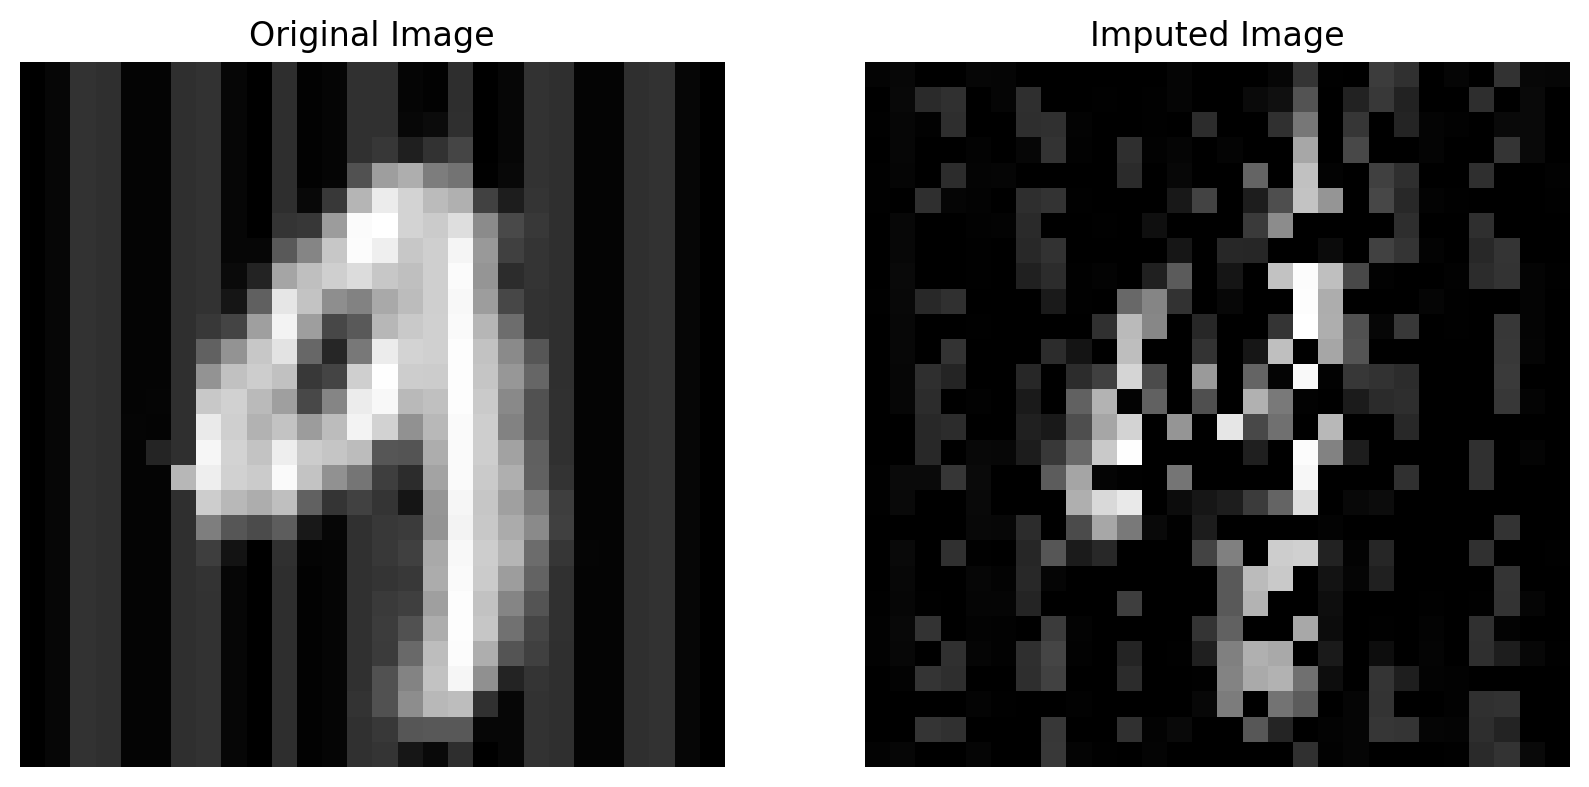


Sample 4:
Mean Squared Error (MSE): 0.0509
Structural Similarity Index (SSIM): 0.2434
Peak Signal-to-Noise Ratio (PSNR): 61.0659 dB


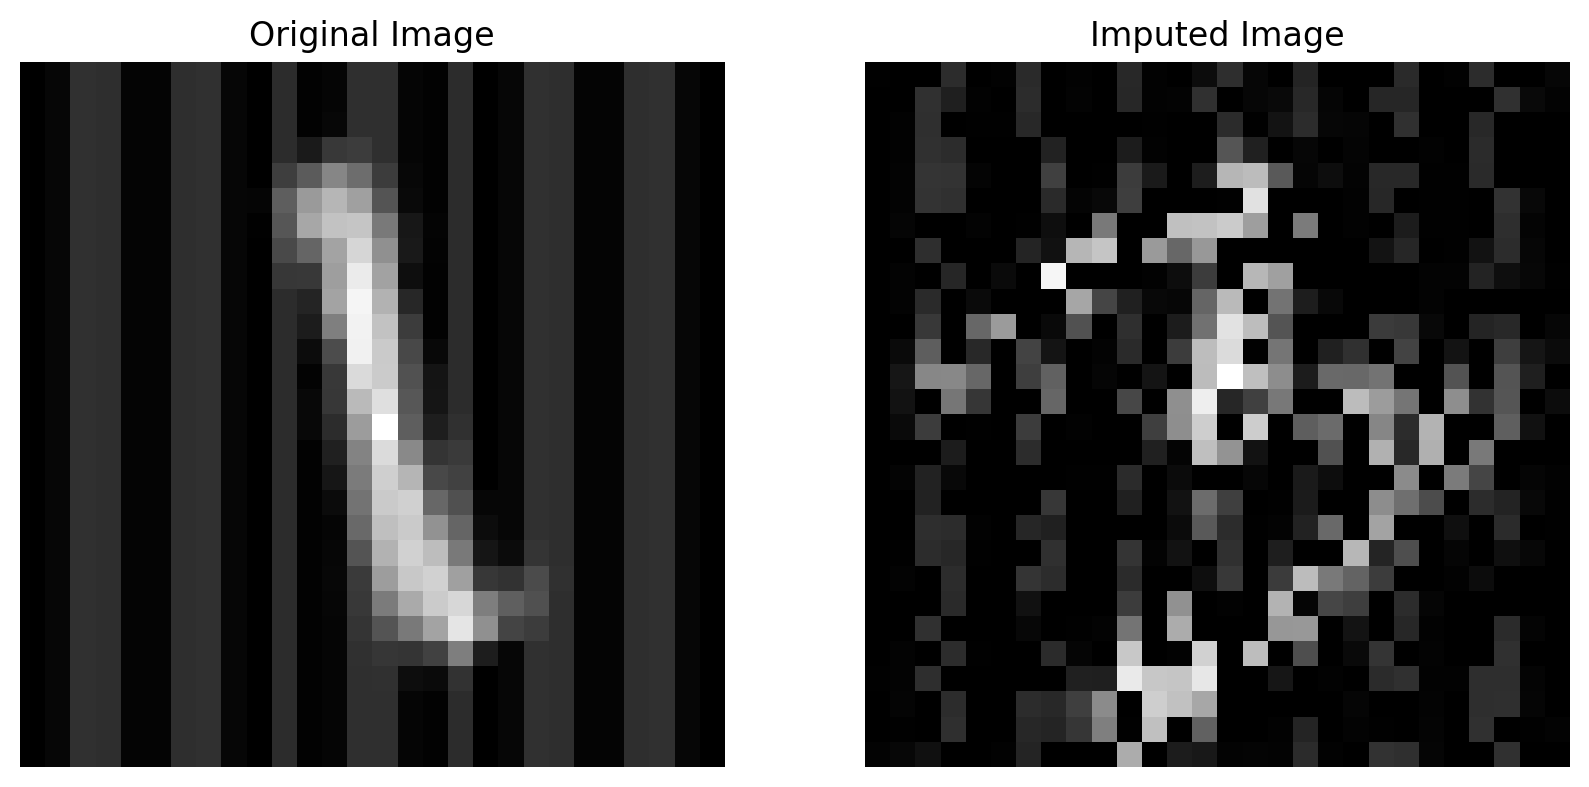


Sample 5:
Mean Squared Error (MSE): 0.1462
Structural Similarity Index (SSIM): 0.0561
Peak Signal-to-Noise Ratio (PSNR): 56.4818 dB


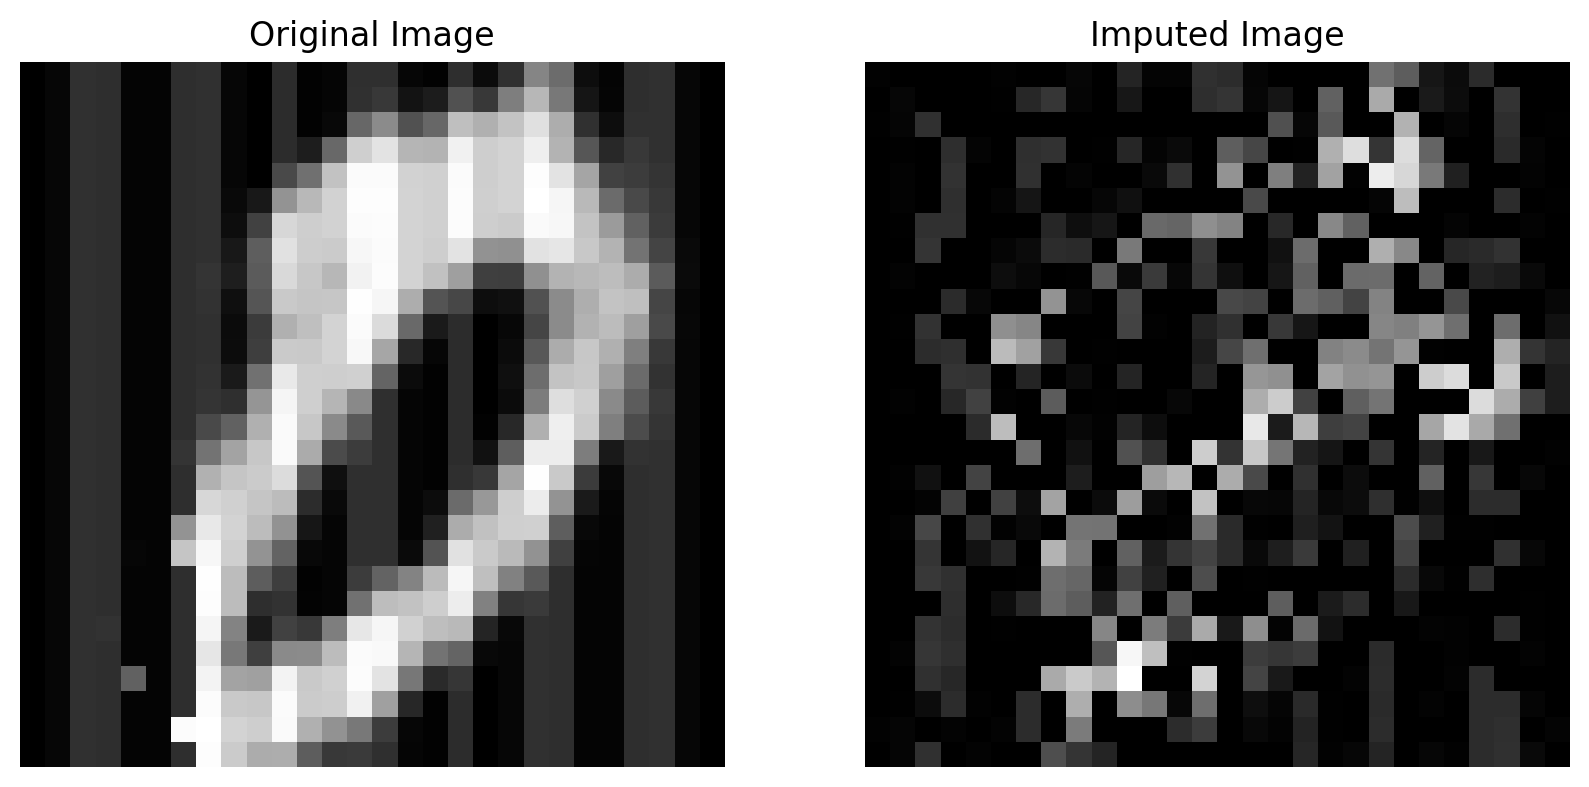

Epoch: 219


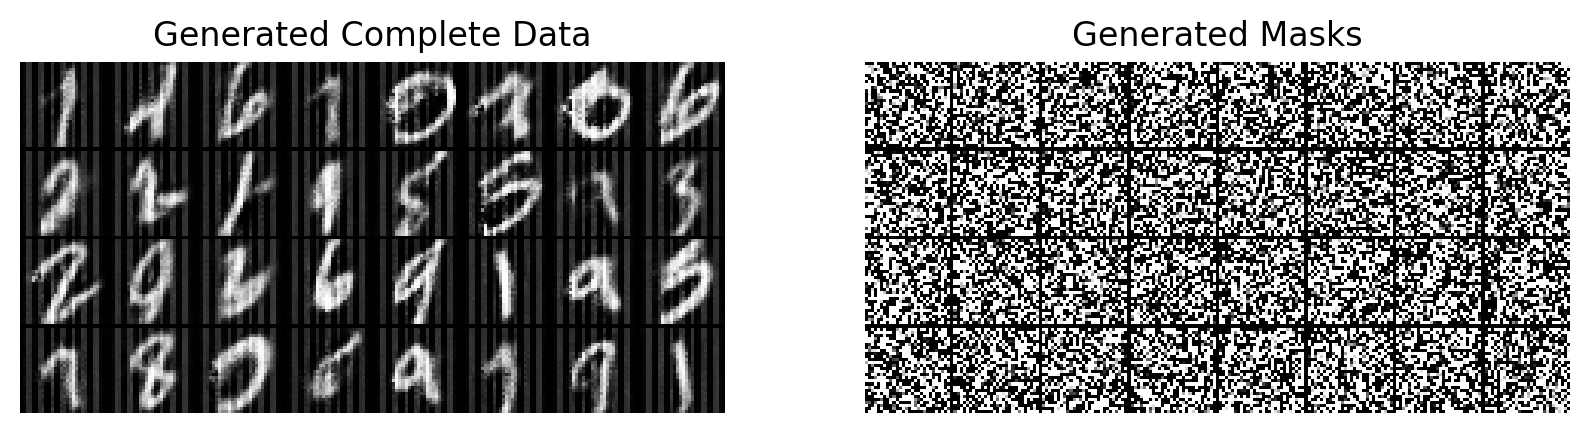


Sample 1:
Mean Squared Error (MSE): 0.0947
Structural Similarity Index (SSIM): 0.1344
Peak Signal-to-Noise Ratio (PSNR): 58.3687 dB


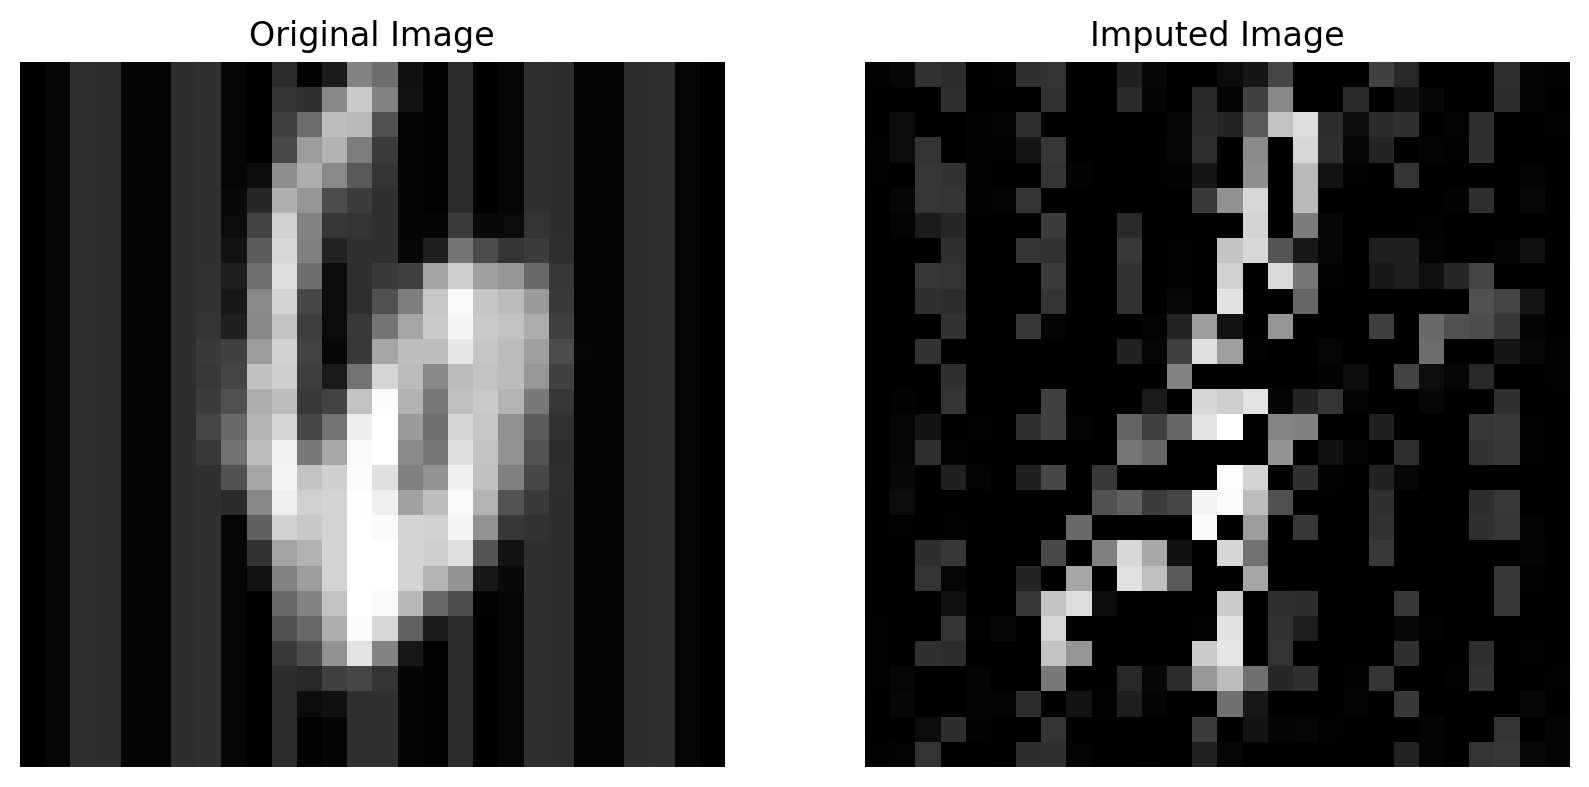


Sample 2:
Mean Squared Error (MSE): 0.0653
Structural Similarity Index (SSIM): 0.2008
Peak Signal-to-Noise Ratio (PSNR): 59.9793 dB


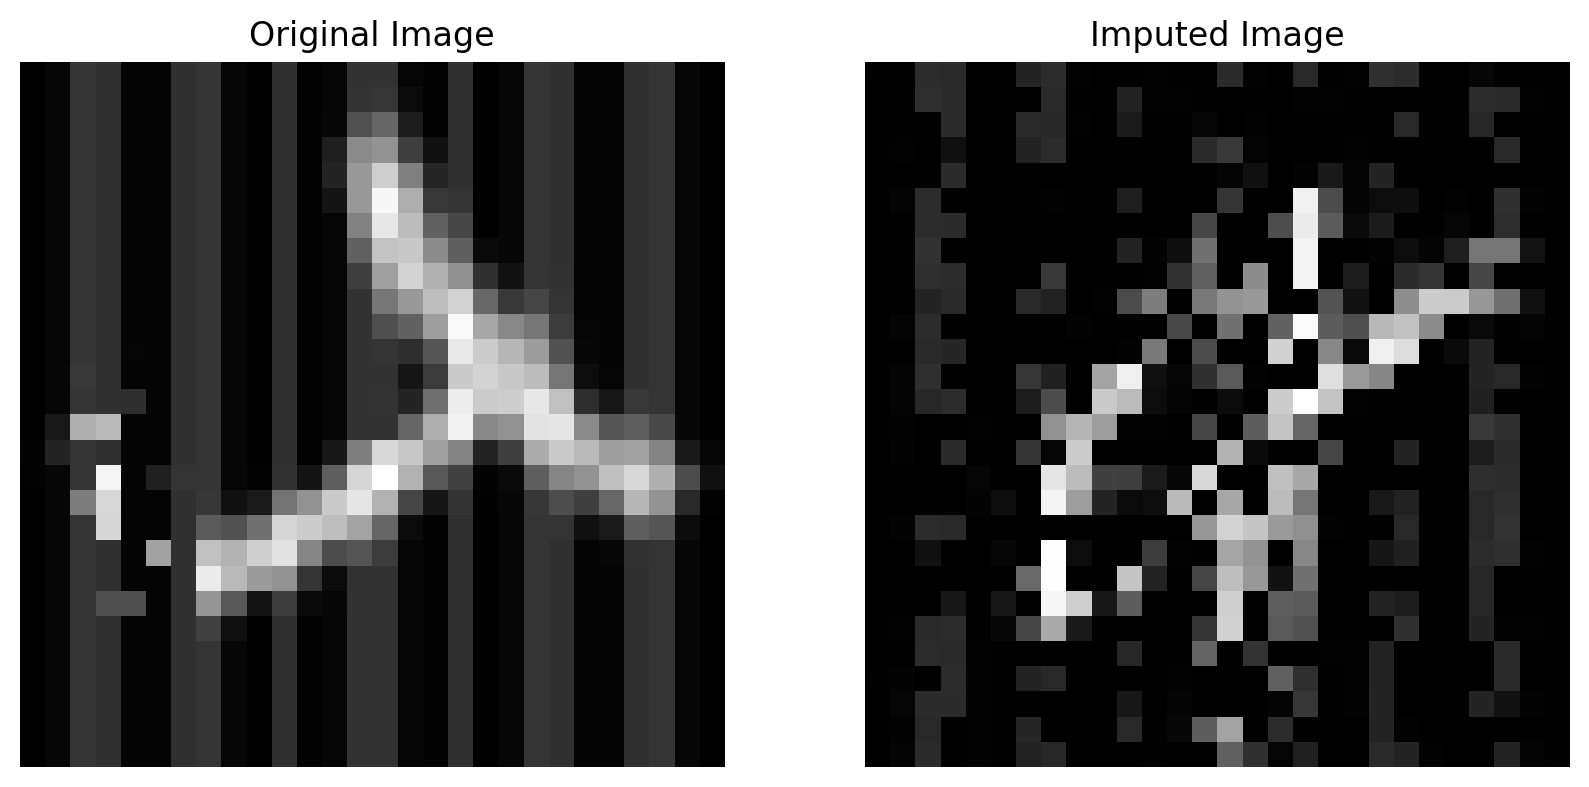


Sample 3:
Mean Squared Error (MSE): 0.1063
Structural Similarity Index (SSIM): 0.1689
Peak Signal-to-Noise Ratio (PSNR): 57.8654 dB


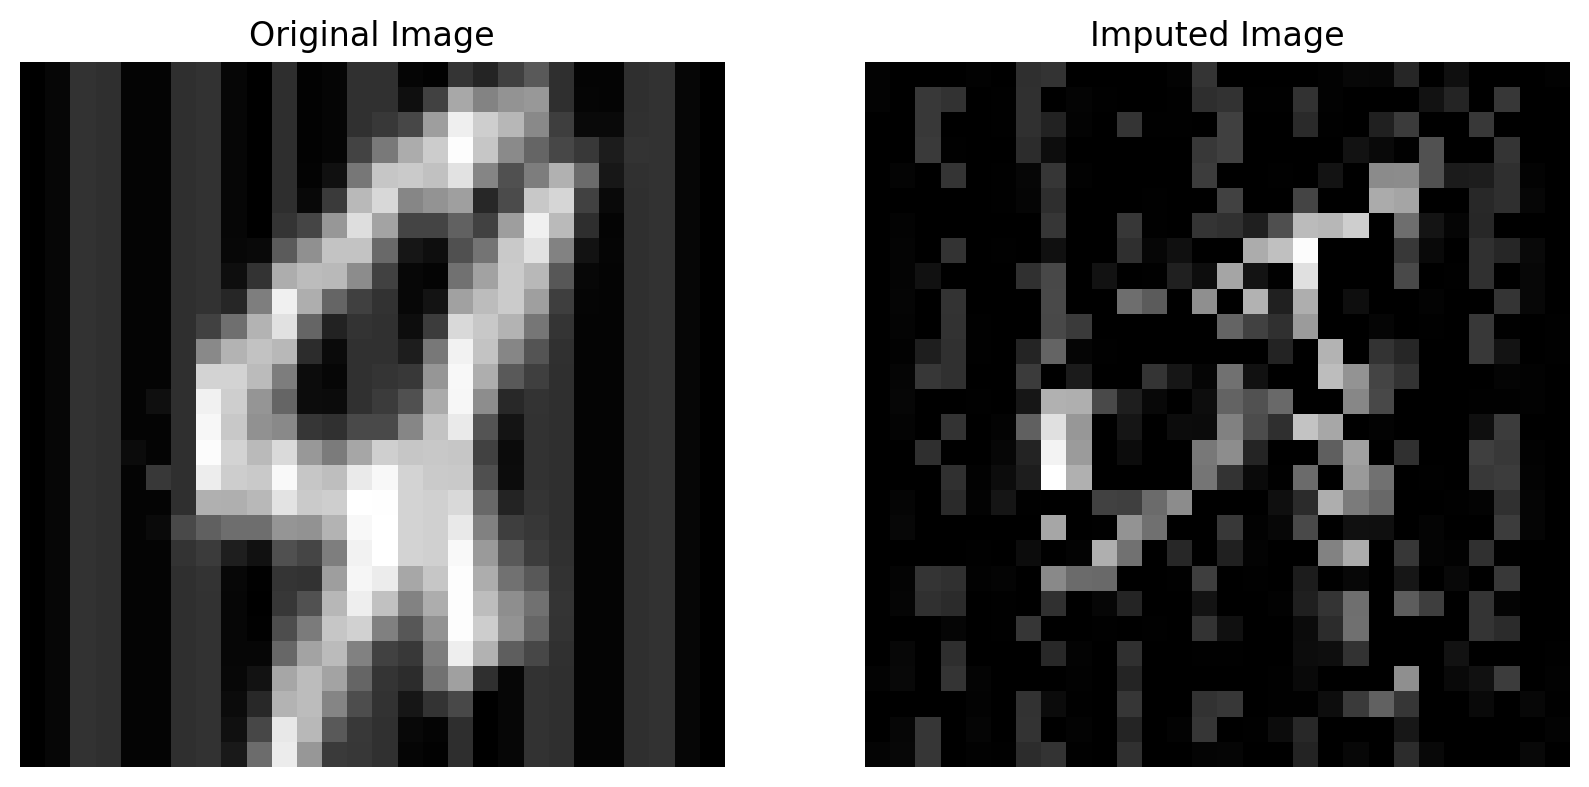


Sample 4:
Mean Squared Error (MSE): 0.1165
Structural Similarity Index (SSIM): 0.1128
Peak Signal-to-Noise Ratio (PSNR): 57.4663 dB


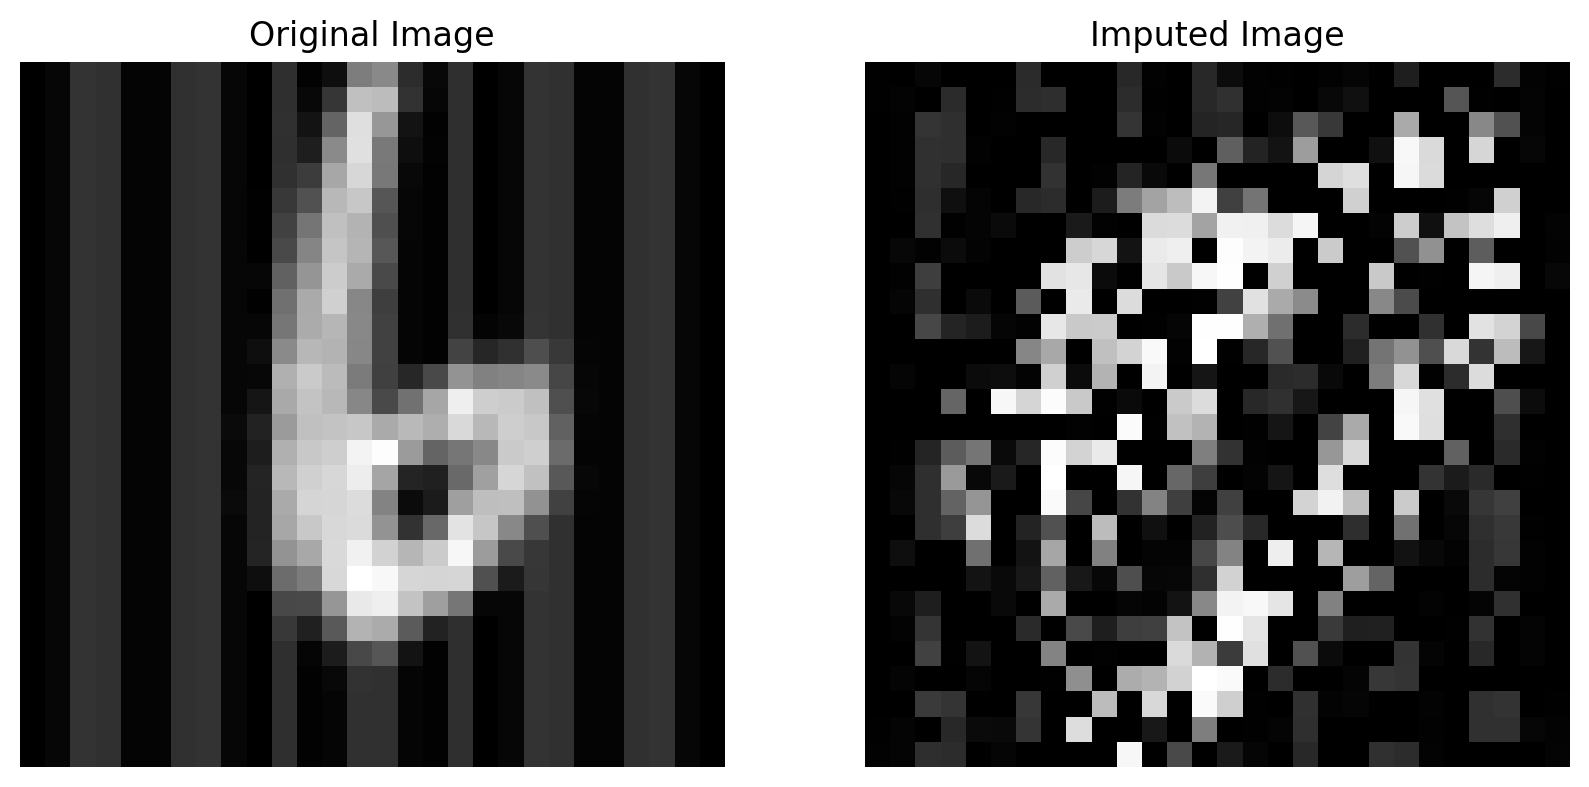


Sample 5:
Mean Squared Error (MSE): 0.0603
Structural Similarity Index (SSIM): 0.1756
Peak Signal-to-Noise Ratio (PSNR): 60.3301 dB


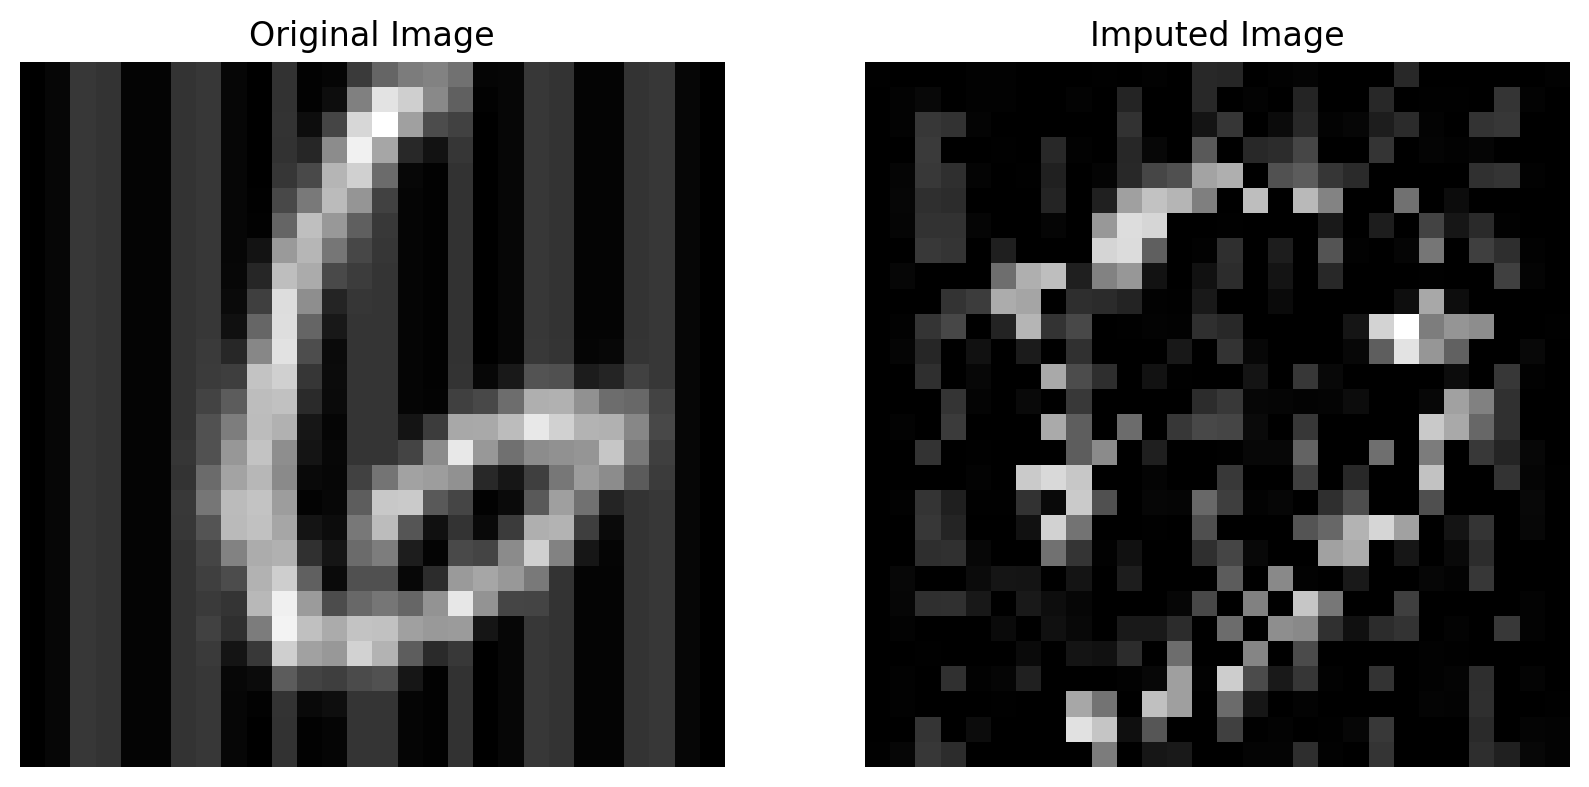

Epoch: 239


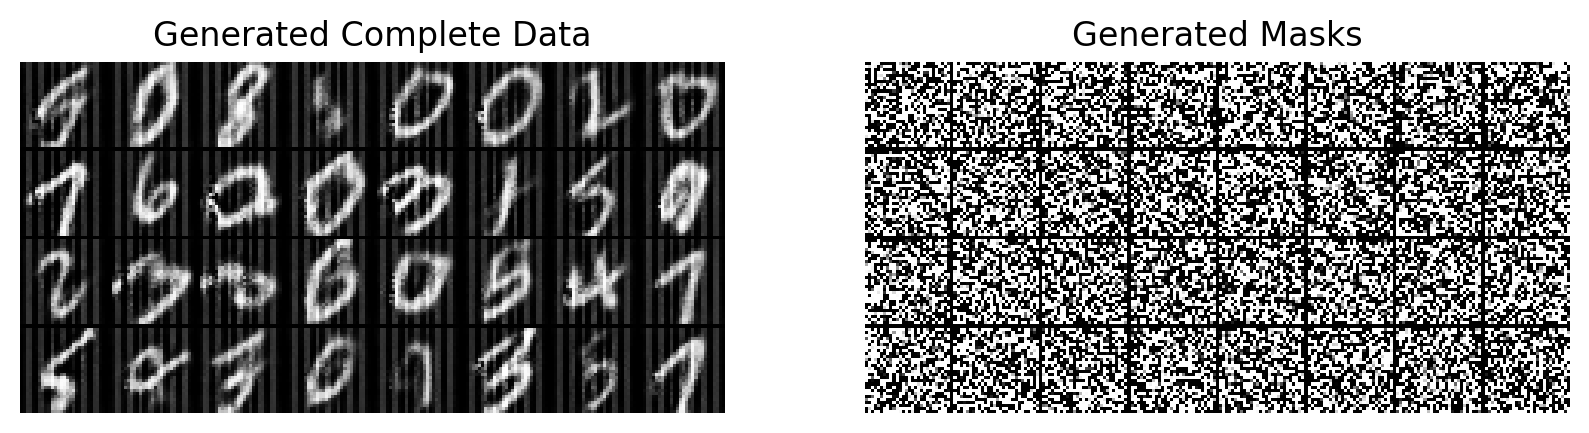


Sample 1:
Mean Squared Error (MSE): 0.1005
Structural Similarity Index (SSIM): 0.1641
Peak Signal-to-Noise Ratio (PSNR): 58.1076 dB


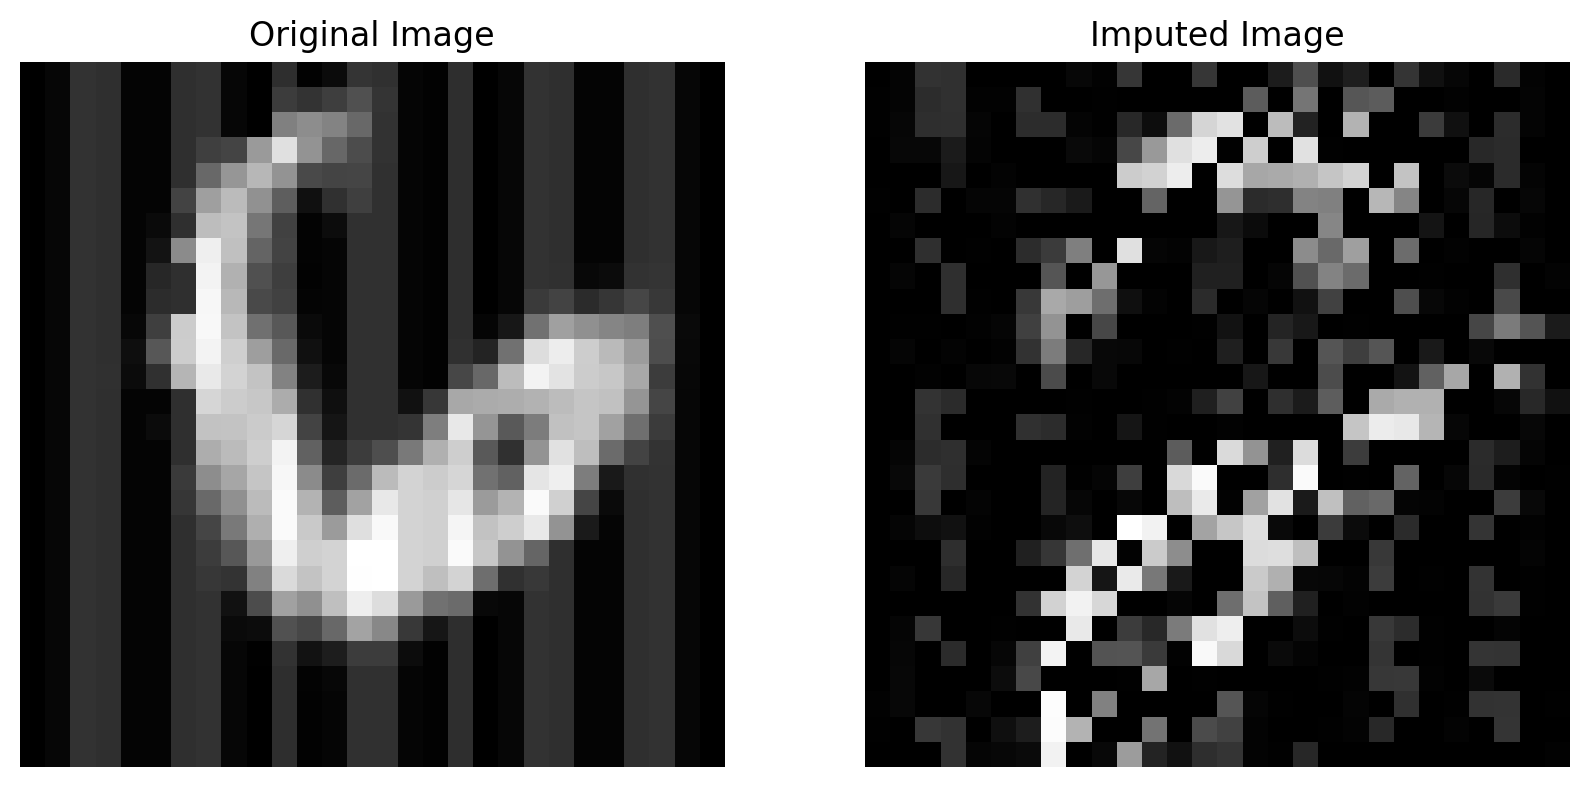


Sample 2:
Mean Squared Error (MSE): 0.0602
Structural Similarity Index (SSIM): 0.2356
Peak Signal-to-Noise Ratio (PSNR): 60.3353 dB


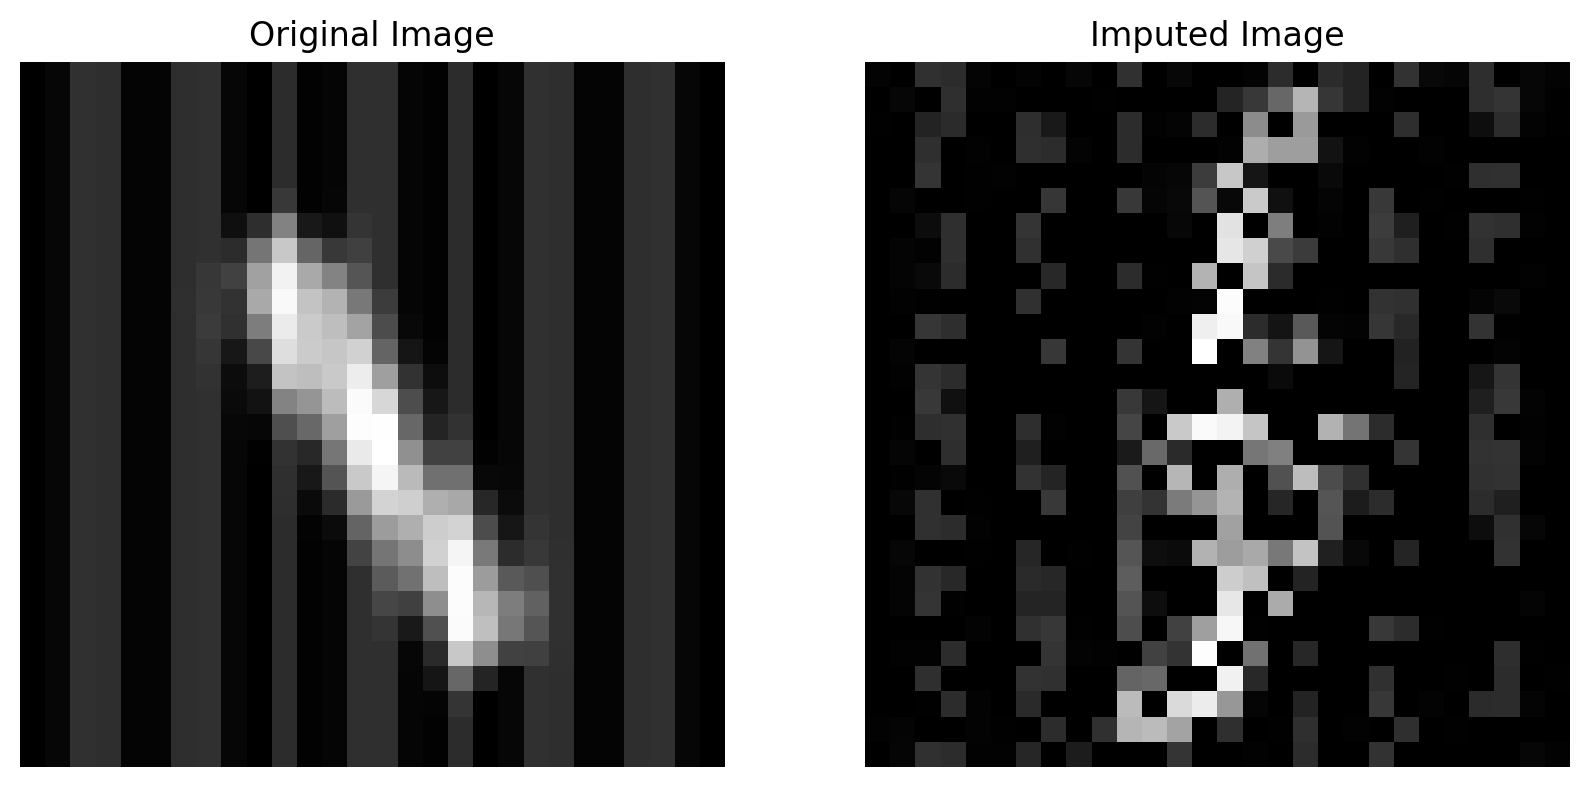


Sample 3:
Mean Squared Error (MSE): 0.1231
Structural Similarity Index (SSIM): 0.1753
Peak Signal-to-Noise Ratio (PSNR): 57.2288 dB


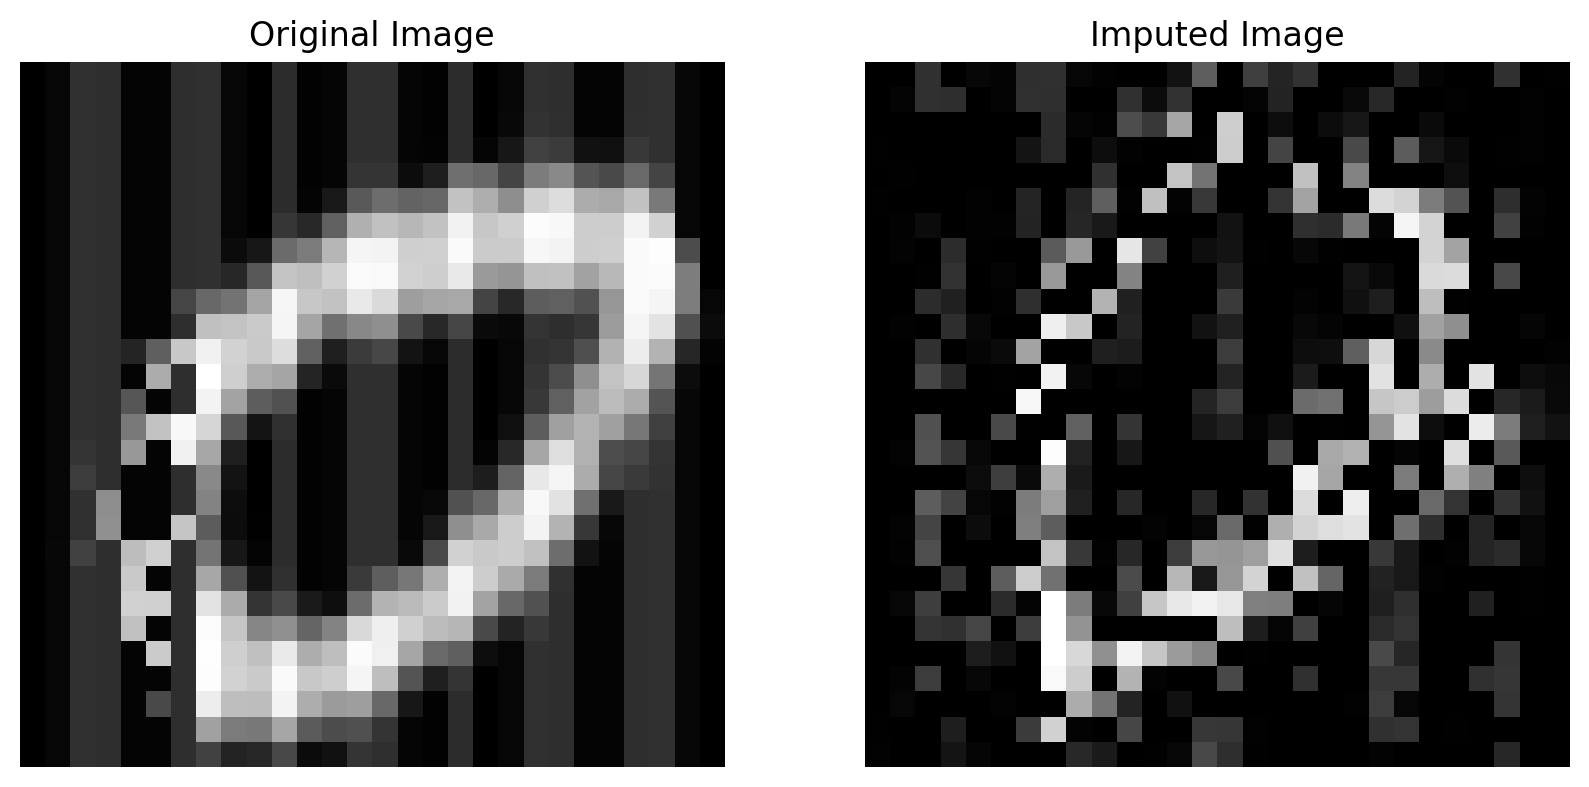


Sample 4:
Mean Squared Error (MSE): 0.0817
Structural Similarity Index (SSIM): 0.0563
Peak Signal-to-Noise Ratio (PSNR): 59.0071 dB


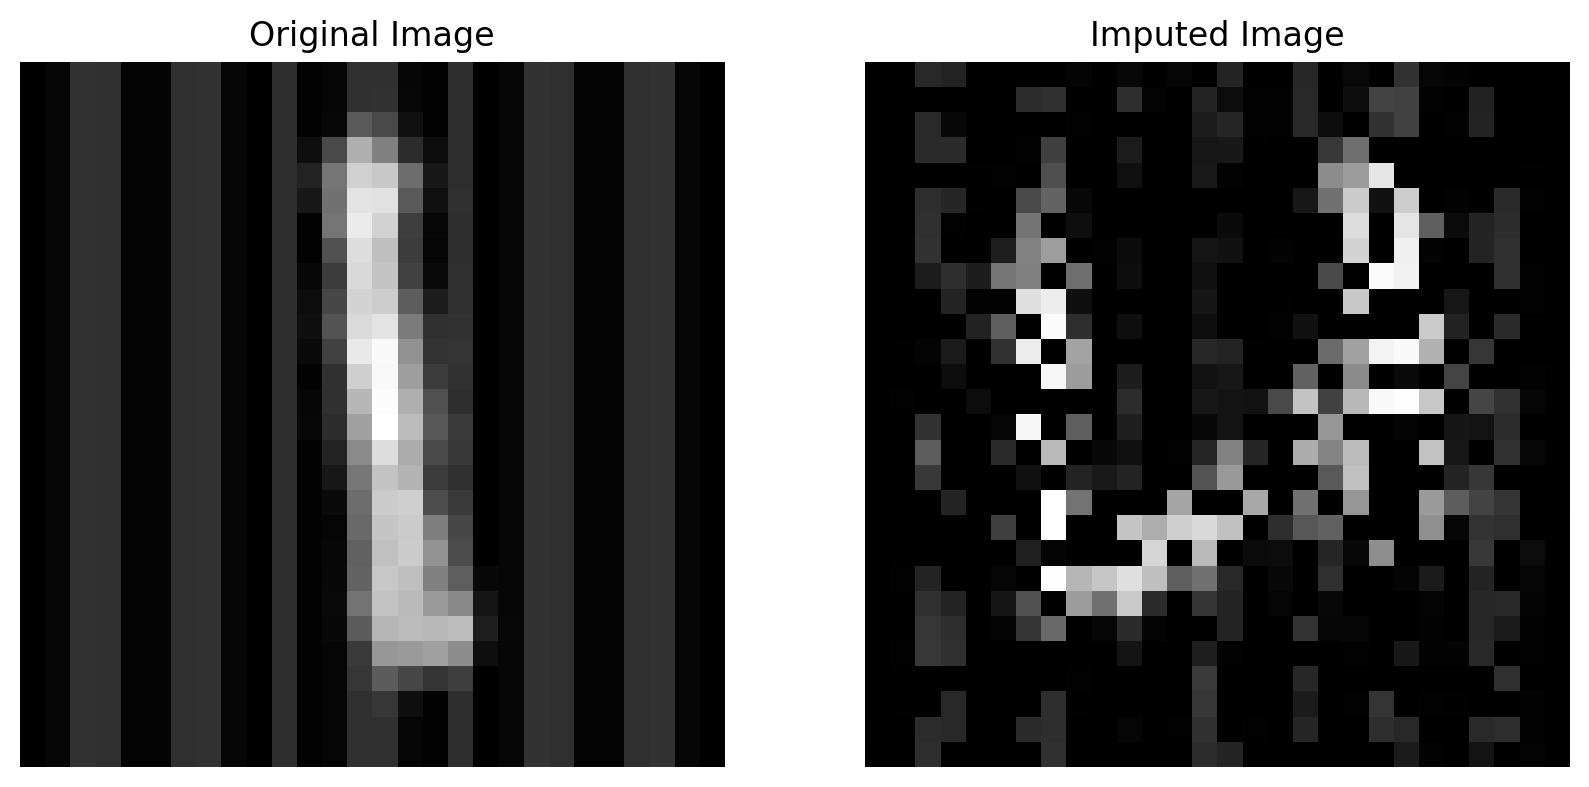


Sample 5:
Mean Squared Error (MSE): 0.0607
Structural Similarity Index (SSIM): 0.2797
Peak Signal-to-Noise Ratio (PSNR): 60.2995 dB


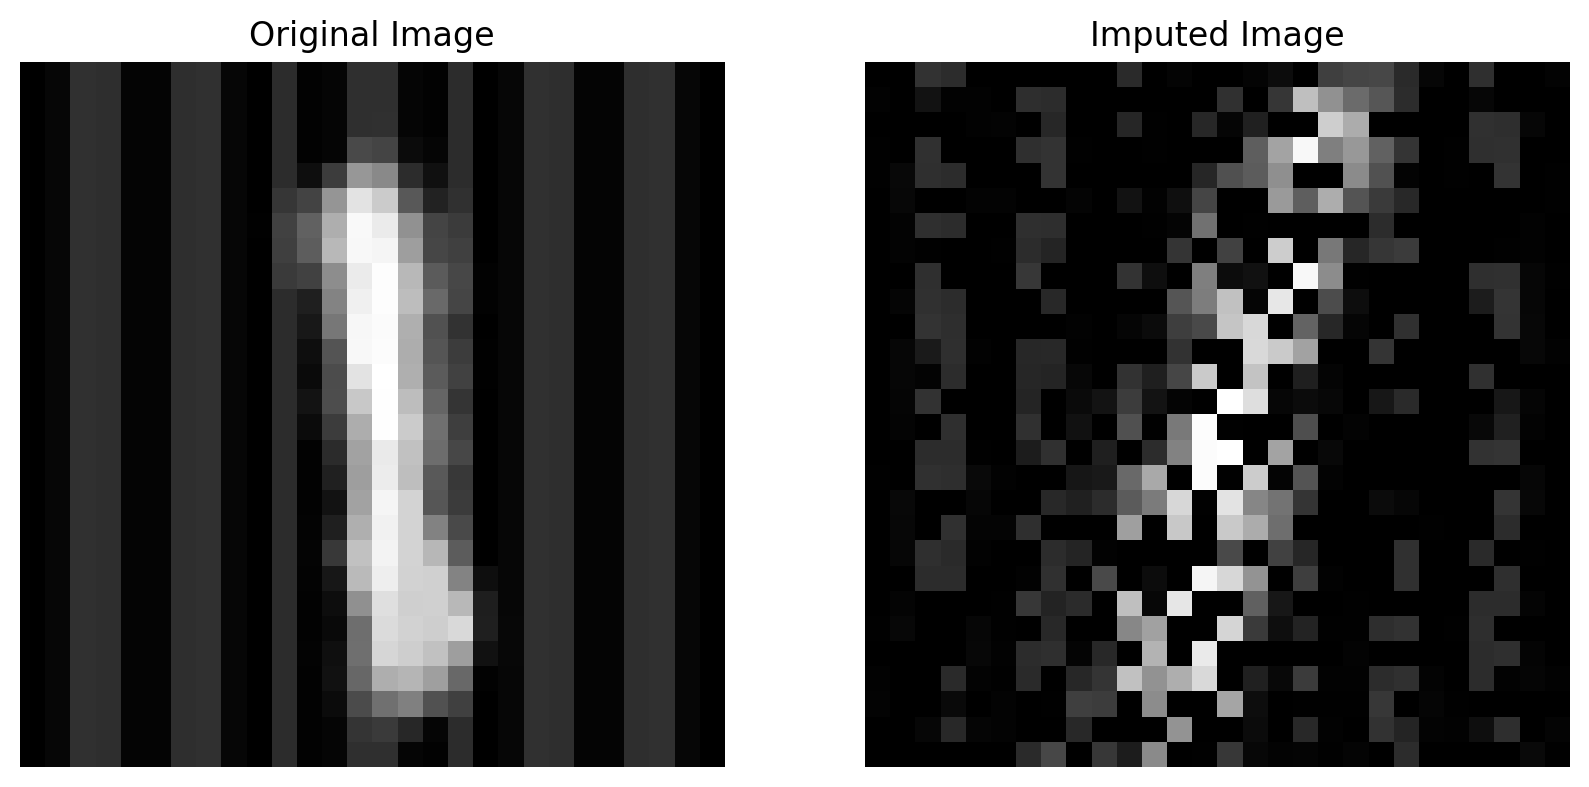

Epoch: 259


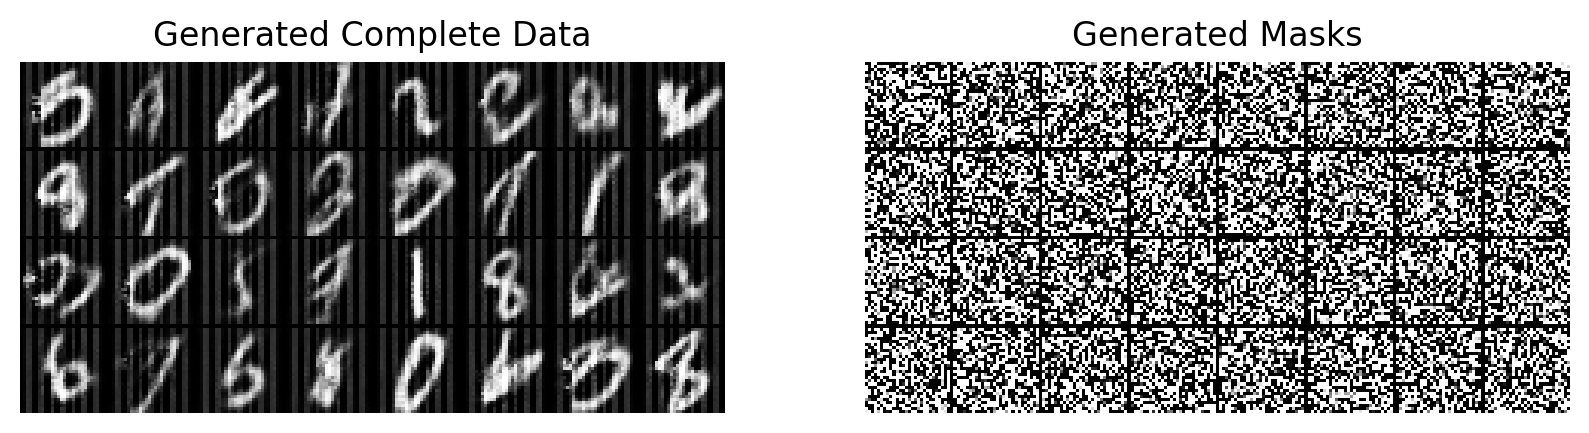


Sample 1:
Mean Squared Error (MSE): 0.0707
Structural Similarity Index (SSIM): 0.1884
Peak Signal-to-Noise Ratio (PSNR): 59.6342 dB


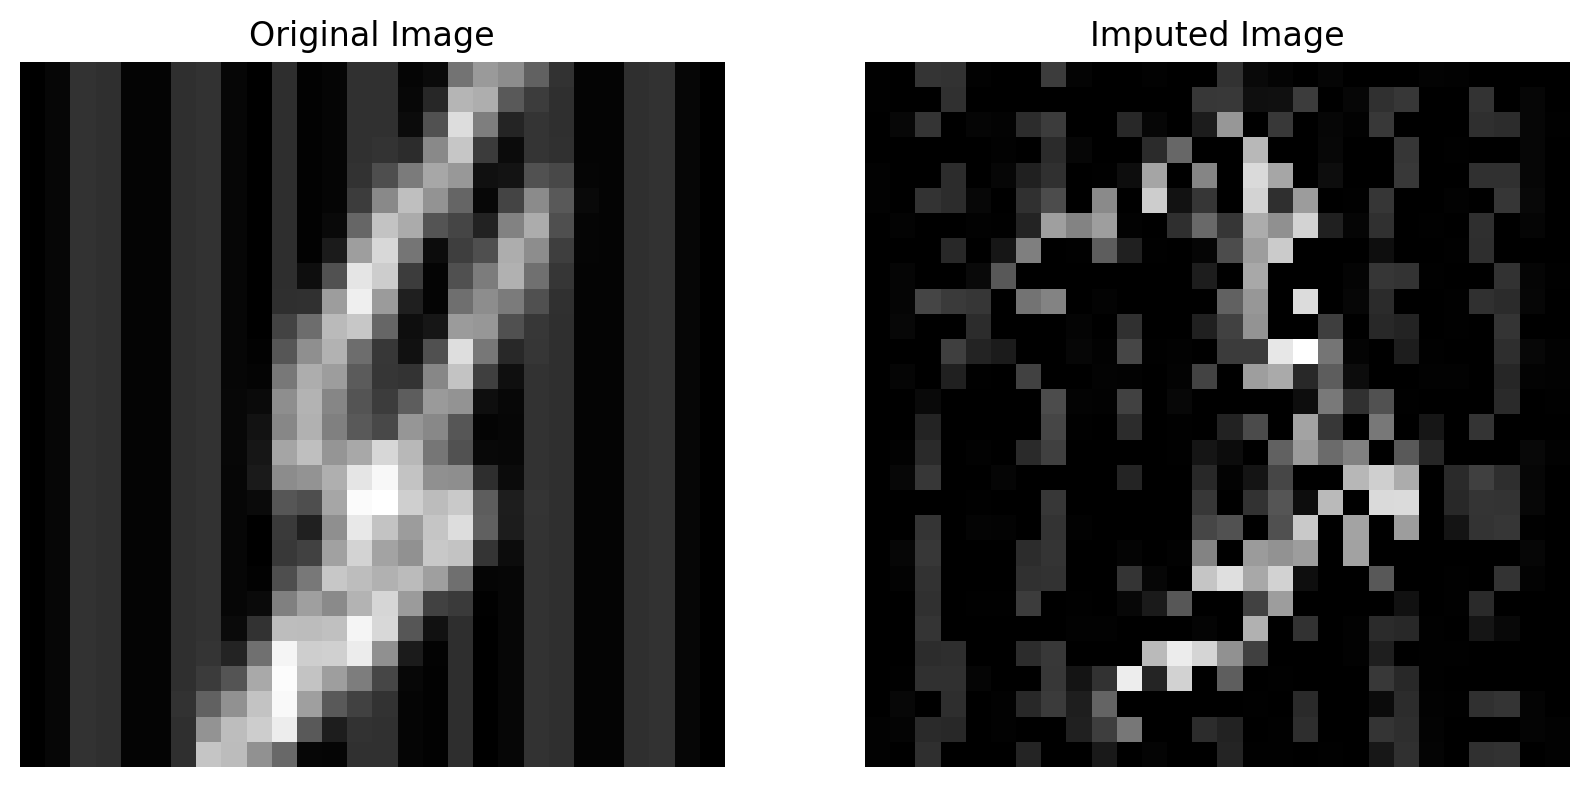


Sample 2:
Mean Squared Error (MSE): 0.1173
Structural Similarity Index (SSIM): 0.1063
Peak Signal-to-Noise Ratio (PSNR): 57.4388 dB


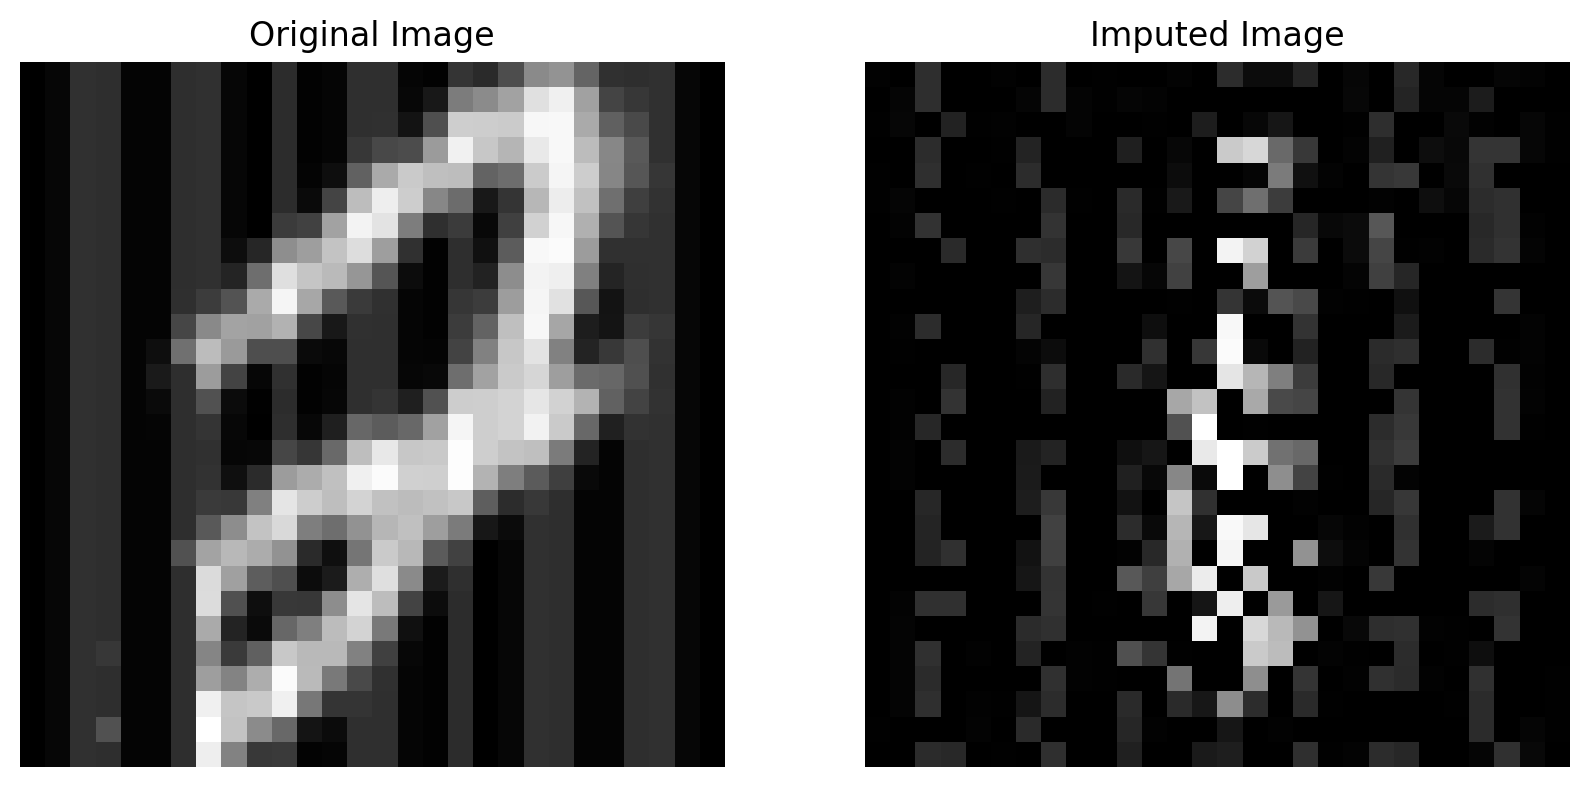


Sample 3:
Mean Squared Error (MSE): 0.1032
Structural Similarity Index (SSIM): 0.0604
Peak Signal-to-Noise Ratio (PSNR): 57.9921 dB


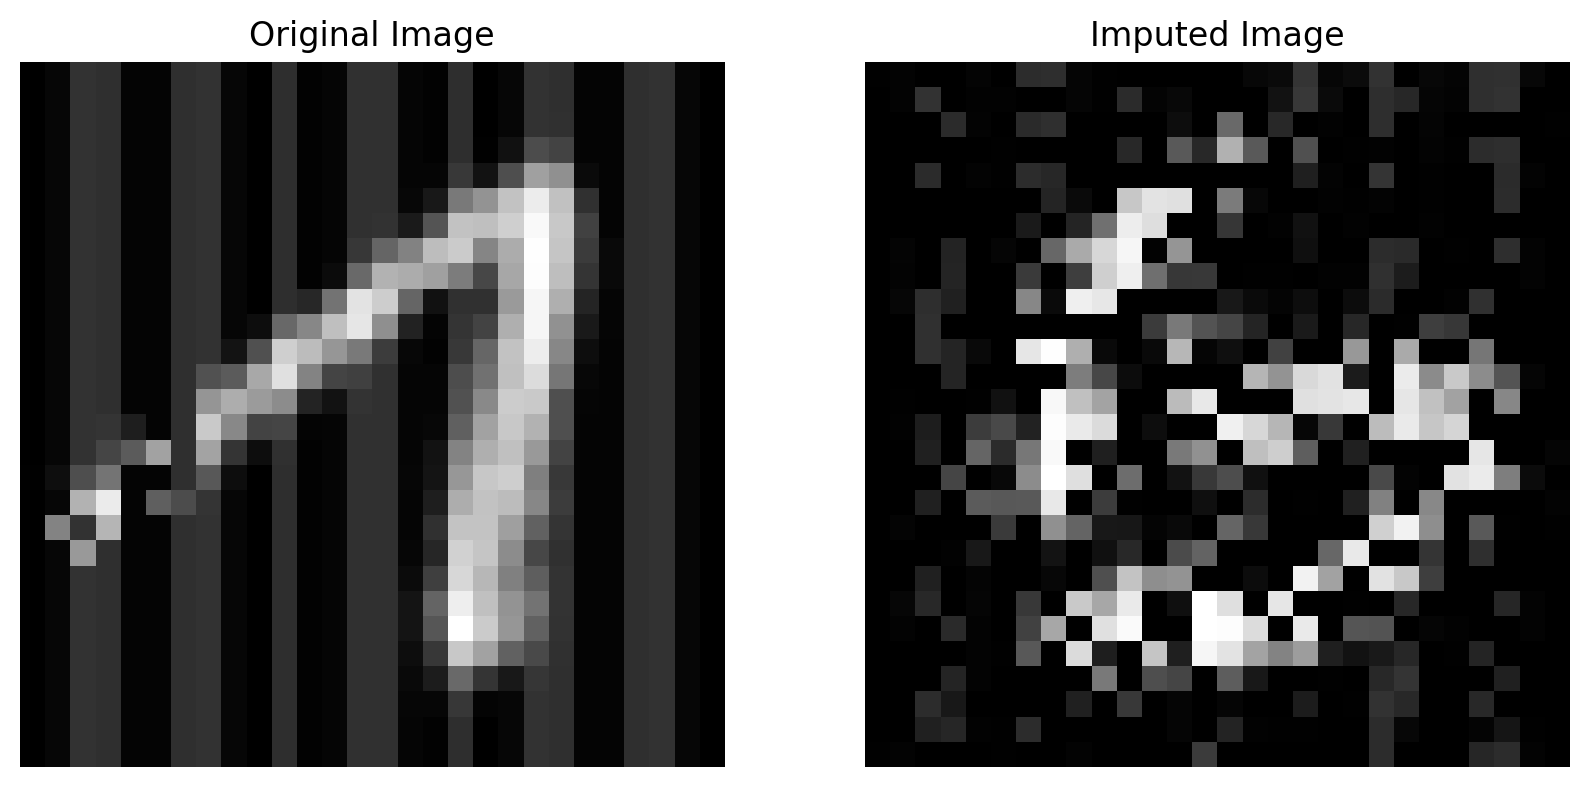


Sample 4:
Mean Squared Error (MSE): 0.0834
Structural Similarity Index (SSIM): 0.1787
Peak Signal-to-Noise Ratio (PSNR): 58.9183 dB


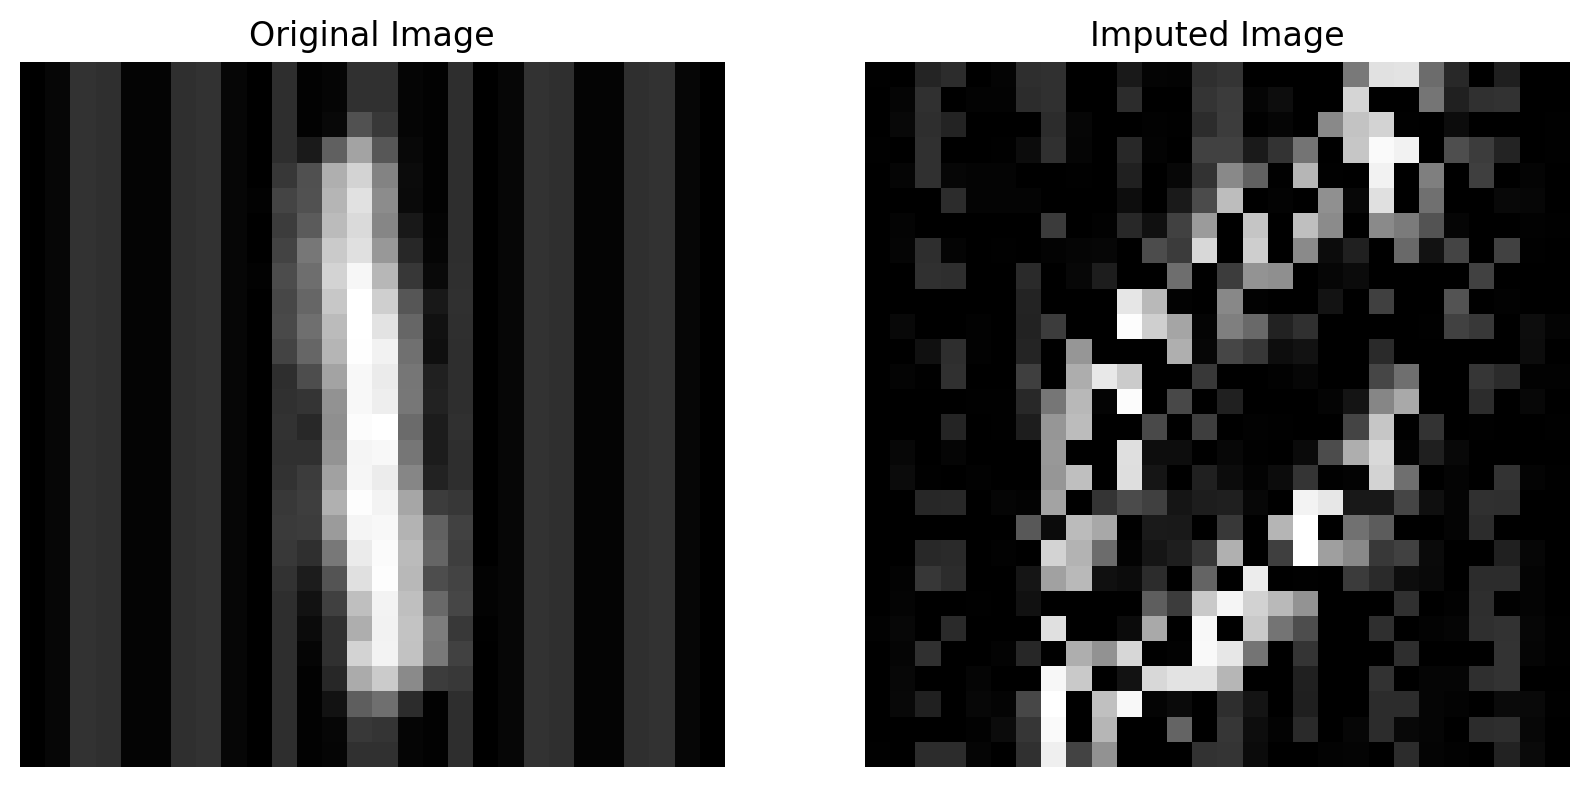


Sample 5:
Mean Squared Error (MSE): 0.0684
Structural Similarity Index (SSIM): 0.1712
Peak Signal-to-Noise Ratio (PSNR): 59.7790 dB


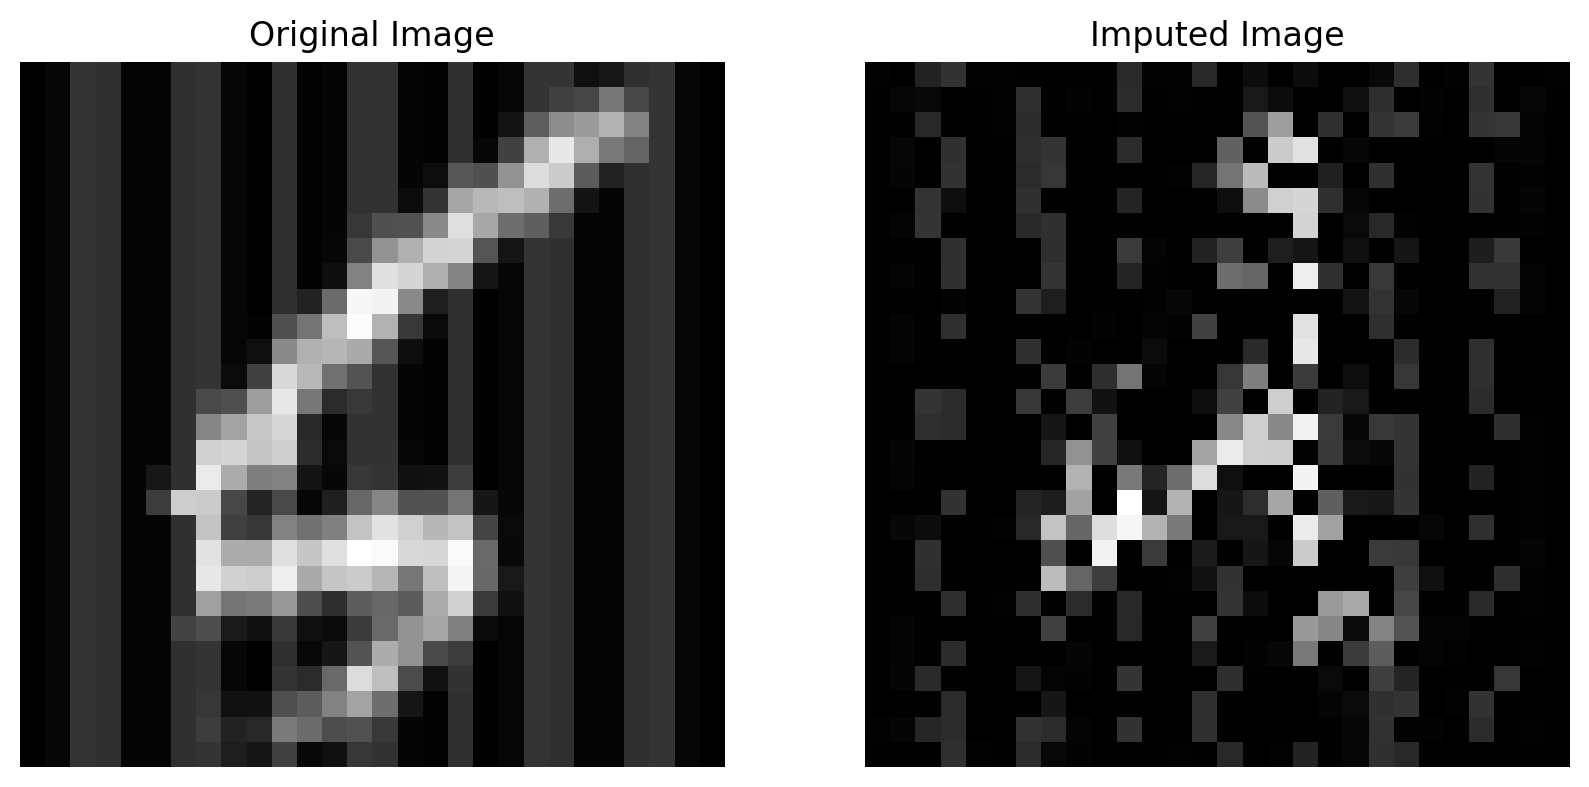

Epoch: 279


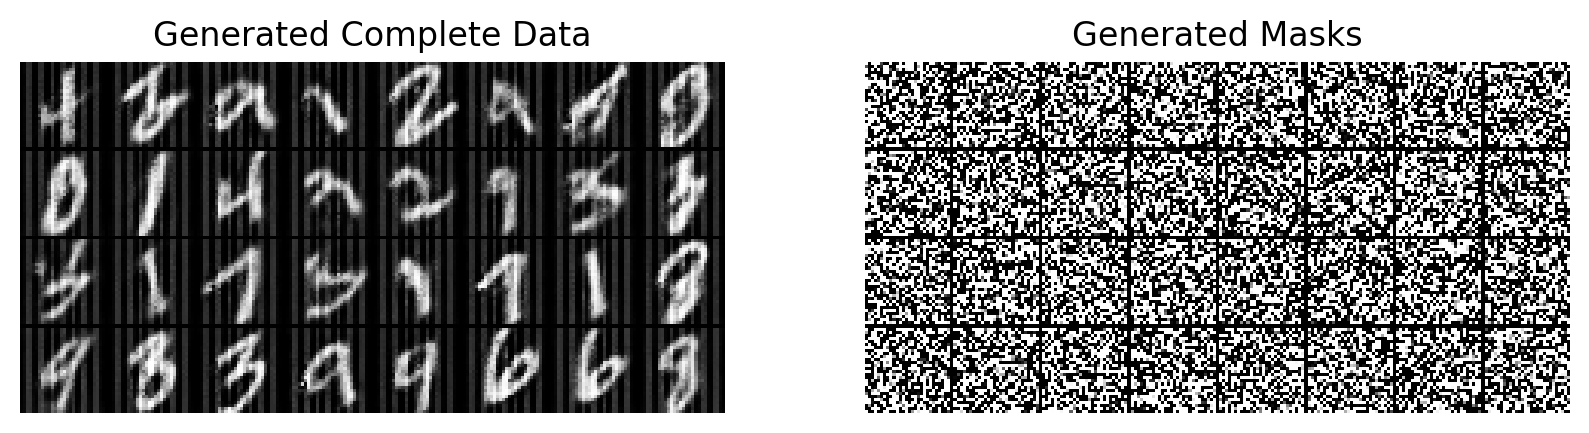


Sample 1:
Mean Squared Error (MSE): 0.0951
Structural Similarity Index (SSIM): 0.1279
Peak Signal-to-Noise Ratio (PSNR): 58.3507 dB


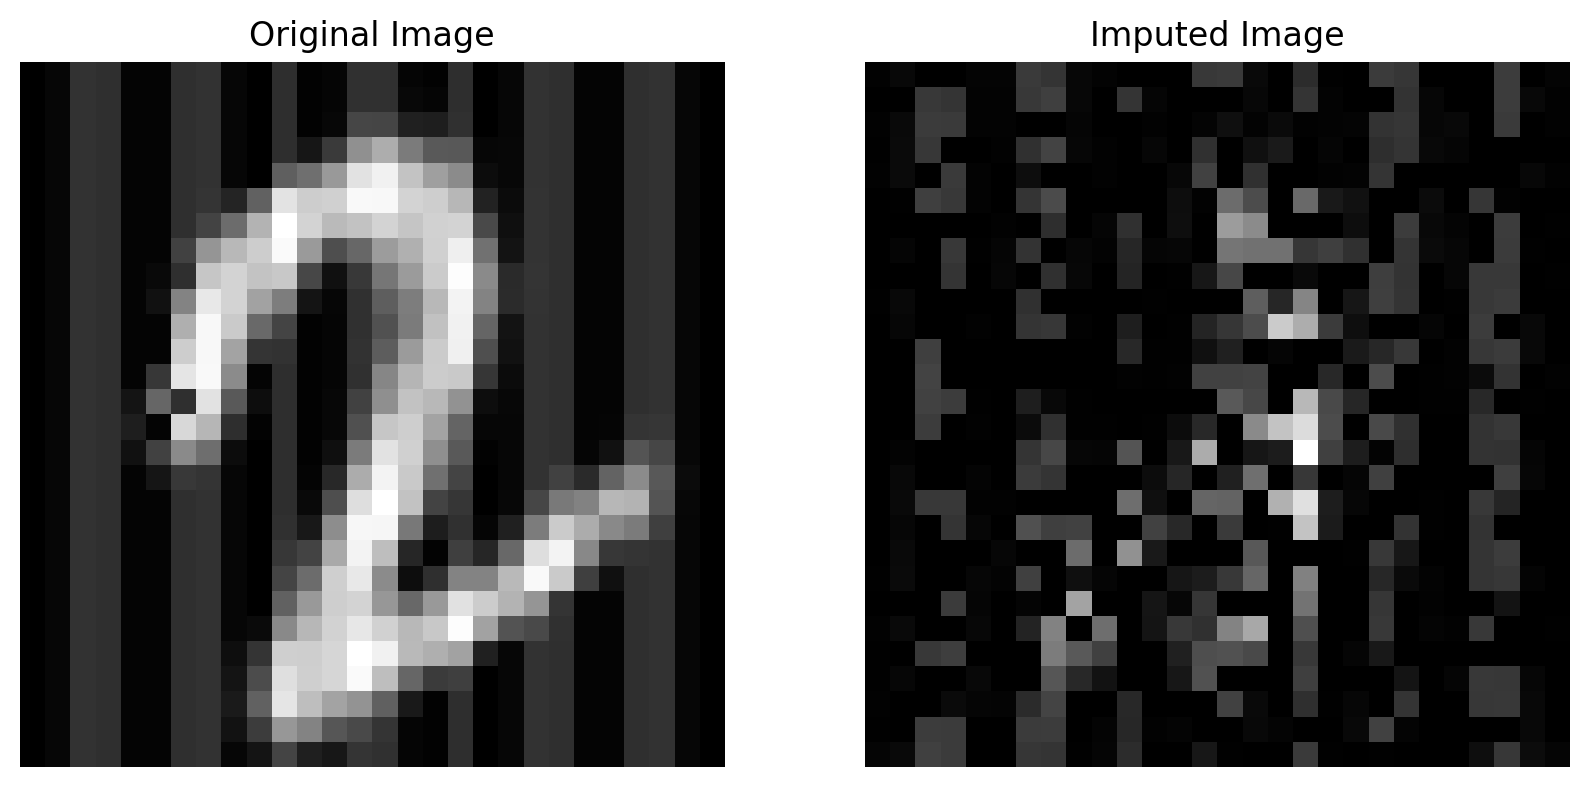


Sample 2:
Mean Squared Error (MSE): 0.1018
Structural Similarity Index (SSIM): 0.1671
Peak Signal-to-Noise Ratio (PSNR): 58.0533 dB


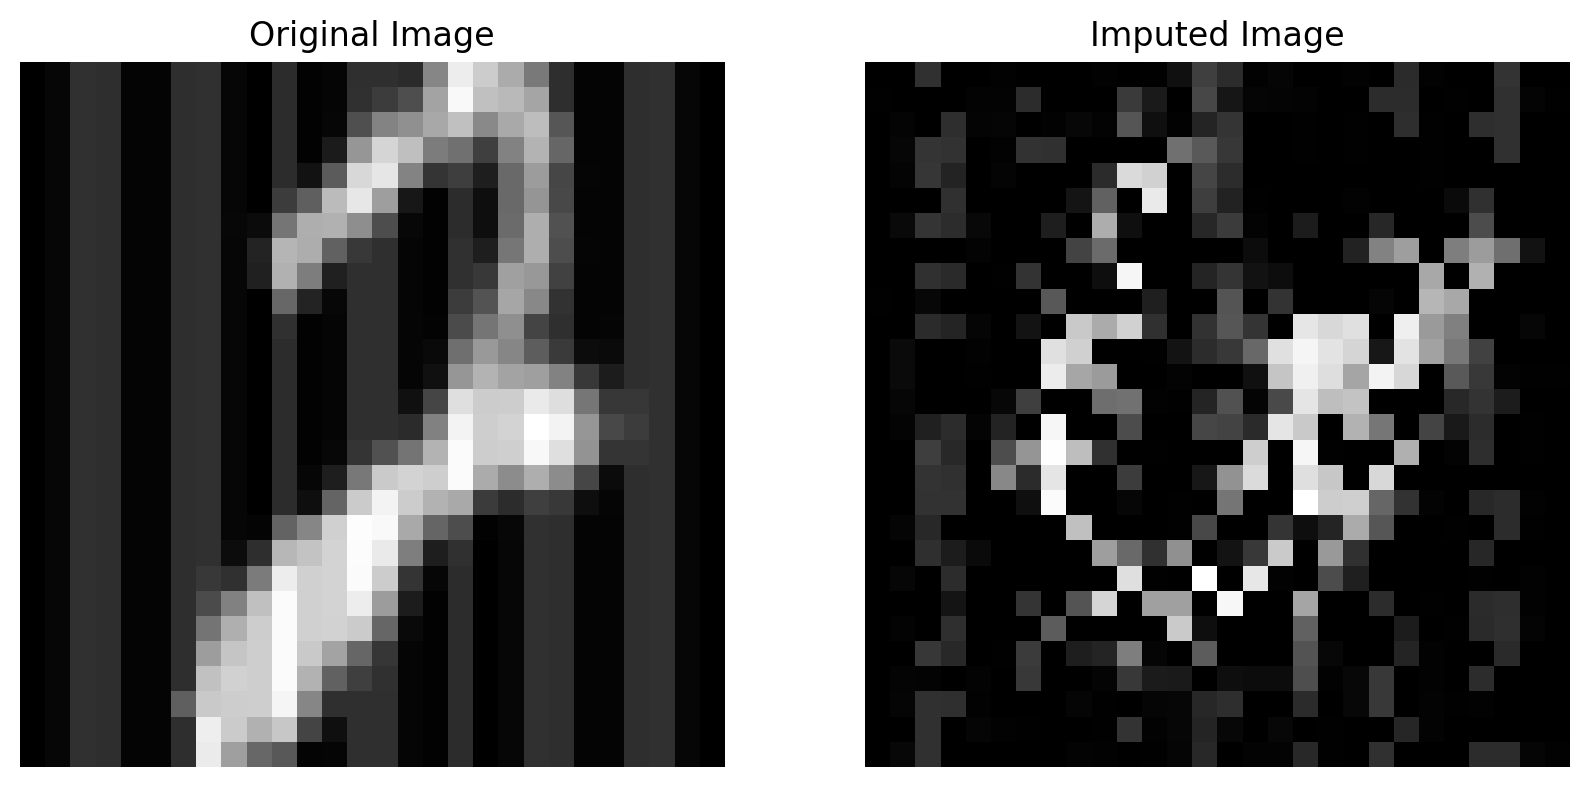


Sample 3:
Mean Squared Error (MSE): 0.0727
Structural Similarity Index (SSIM): 0.1924
Peak Signal-to-Noise Ratio (PSNR): 59.5128 dB


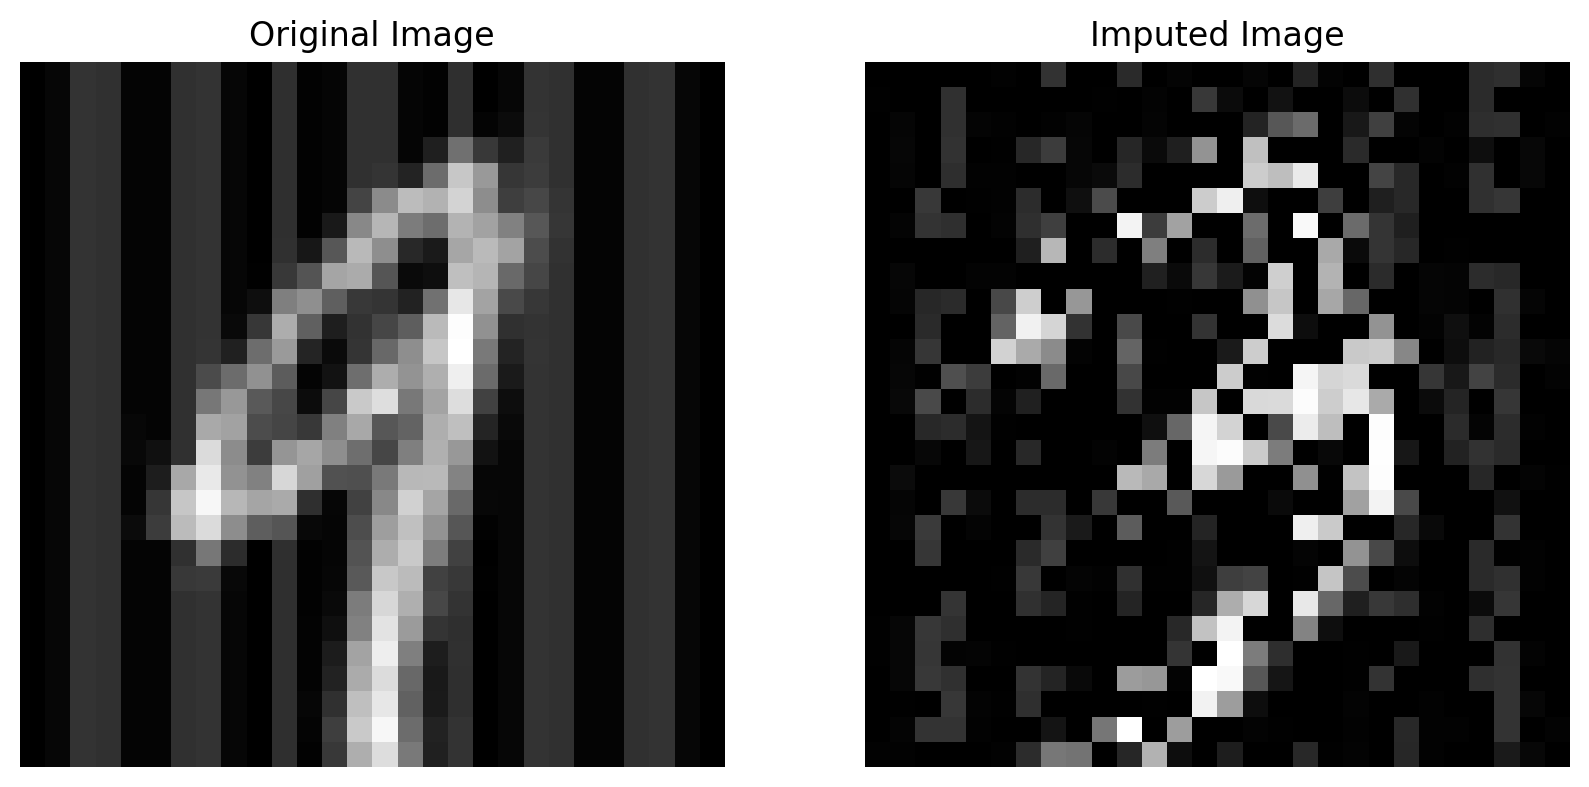


Sample 4:
Mean Squared Error (MSE): 0.0907
Structural Similarity Index (SSIM): 0.1135
Peak Signal-to-Noise Ratio (PSNR): 58.5525 dB


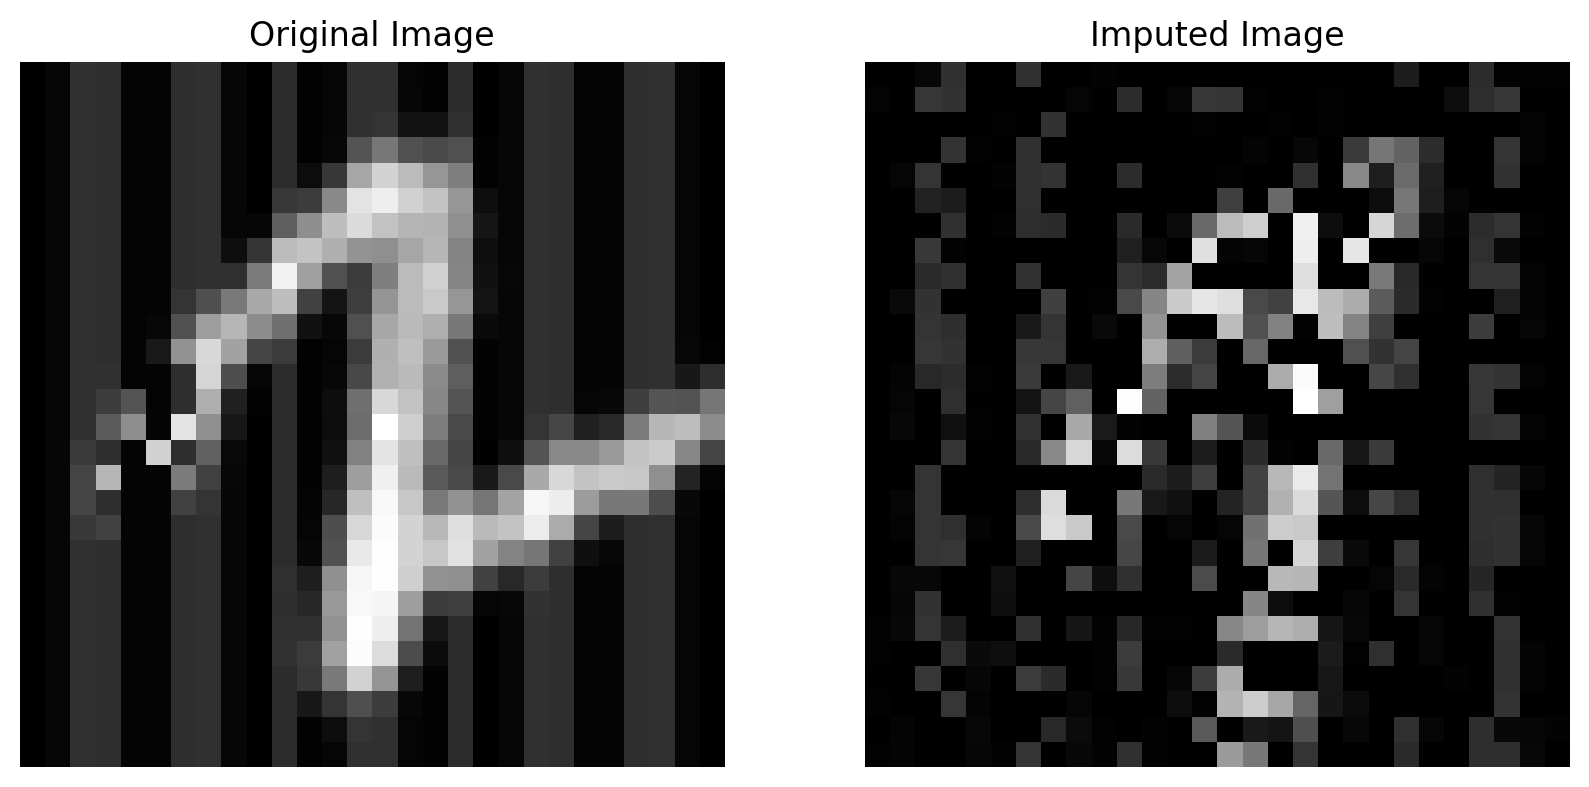


Sample 5:
Mean Squared Error (MSE): 0.0996
Structural Similarity Index (SSIM): 0.1066
Peak Signal-to-Noise Ratio (PSNR): 58.1495 dB


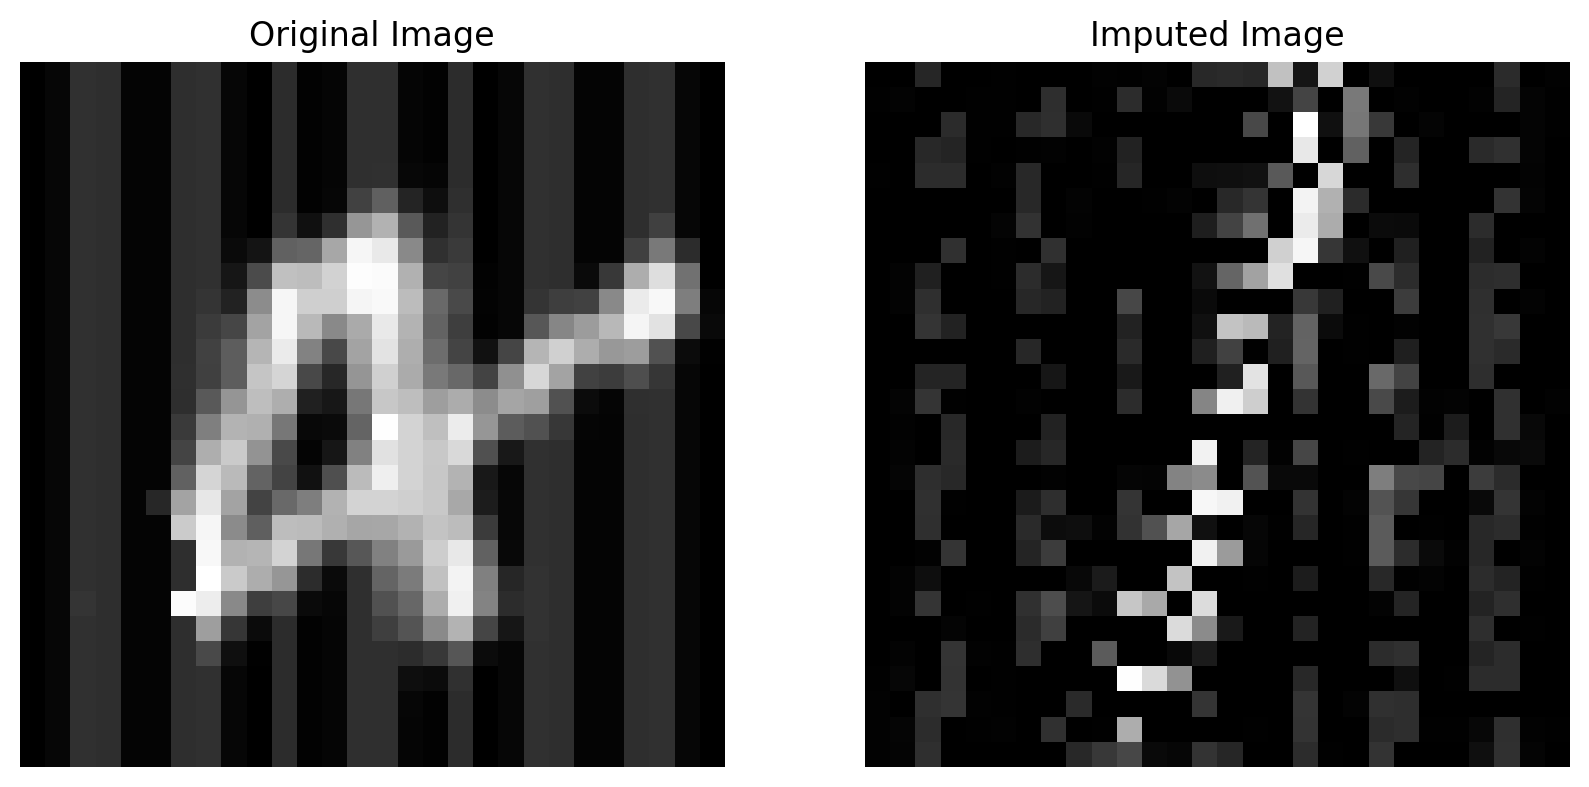

Epoch: 299


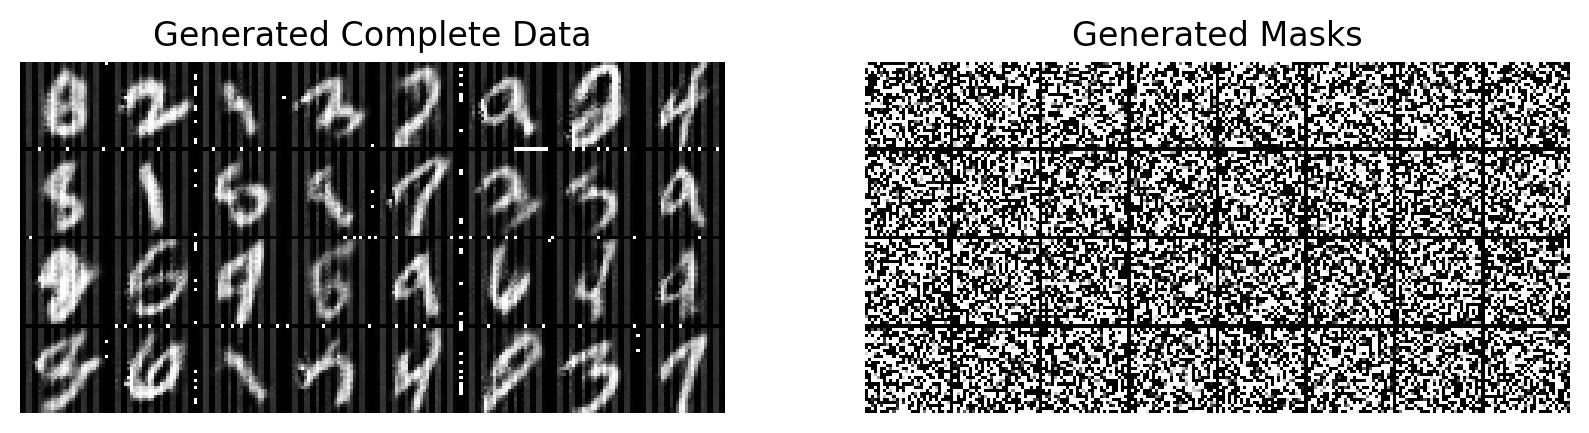


Sample 1:
Mean Squared Error (MSE): 0.0732
Structural Similarity Index (SSIM): 0.1583
Peak Signal-to-Noise Ratio (PSNR): 59.4879 dB


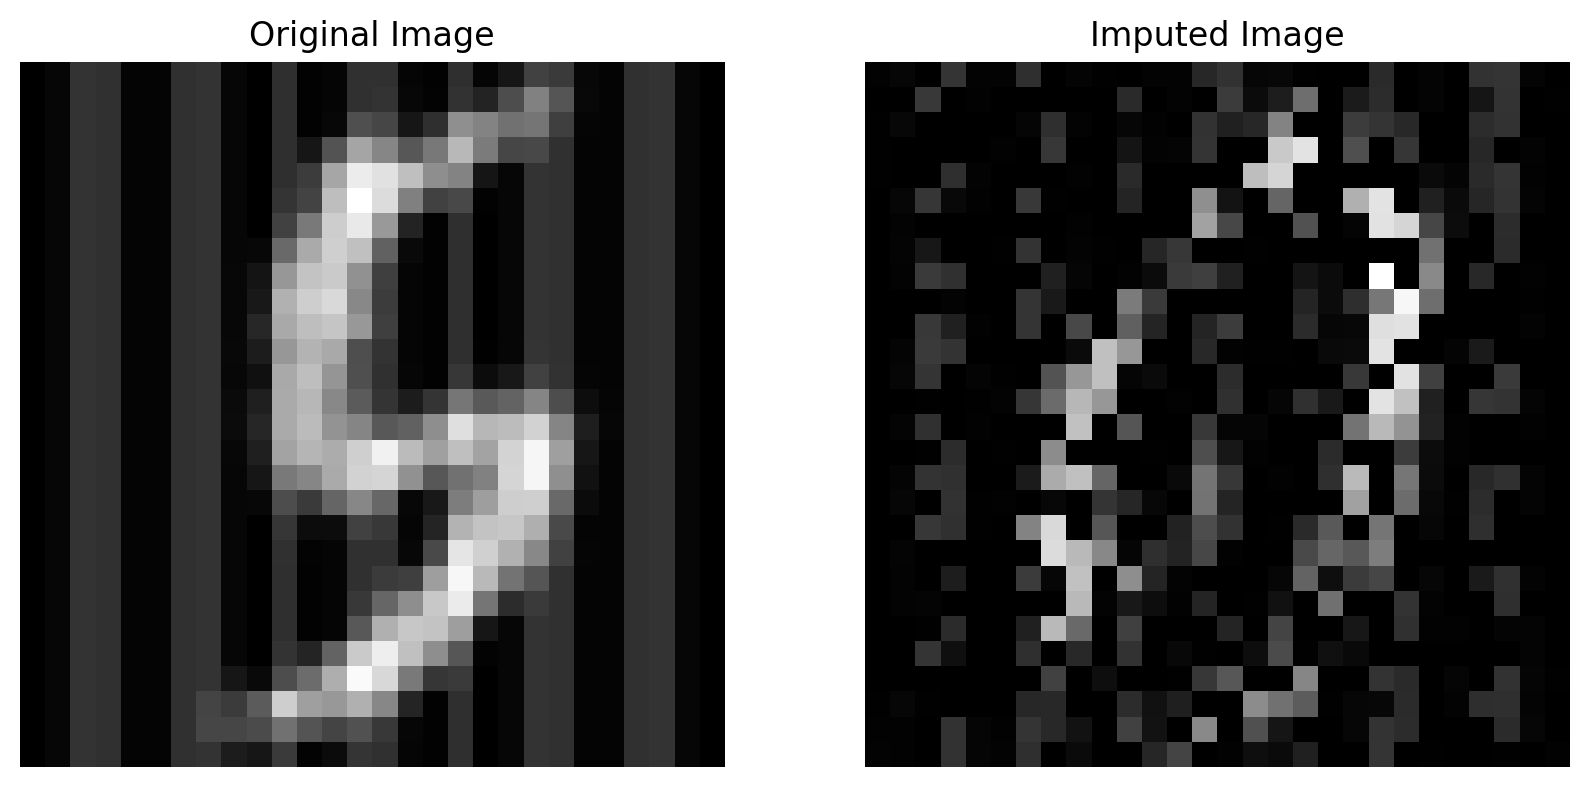


Sample 2:
Mean Squared Error (MSE): 0.1013
Structural Similarity Index (SSIM): 0.1447
Peak Signal-to-Noise Ratio (PSNR): 58.0748 dB


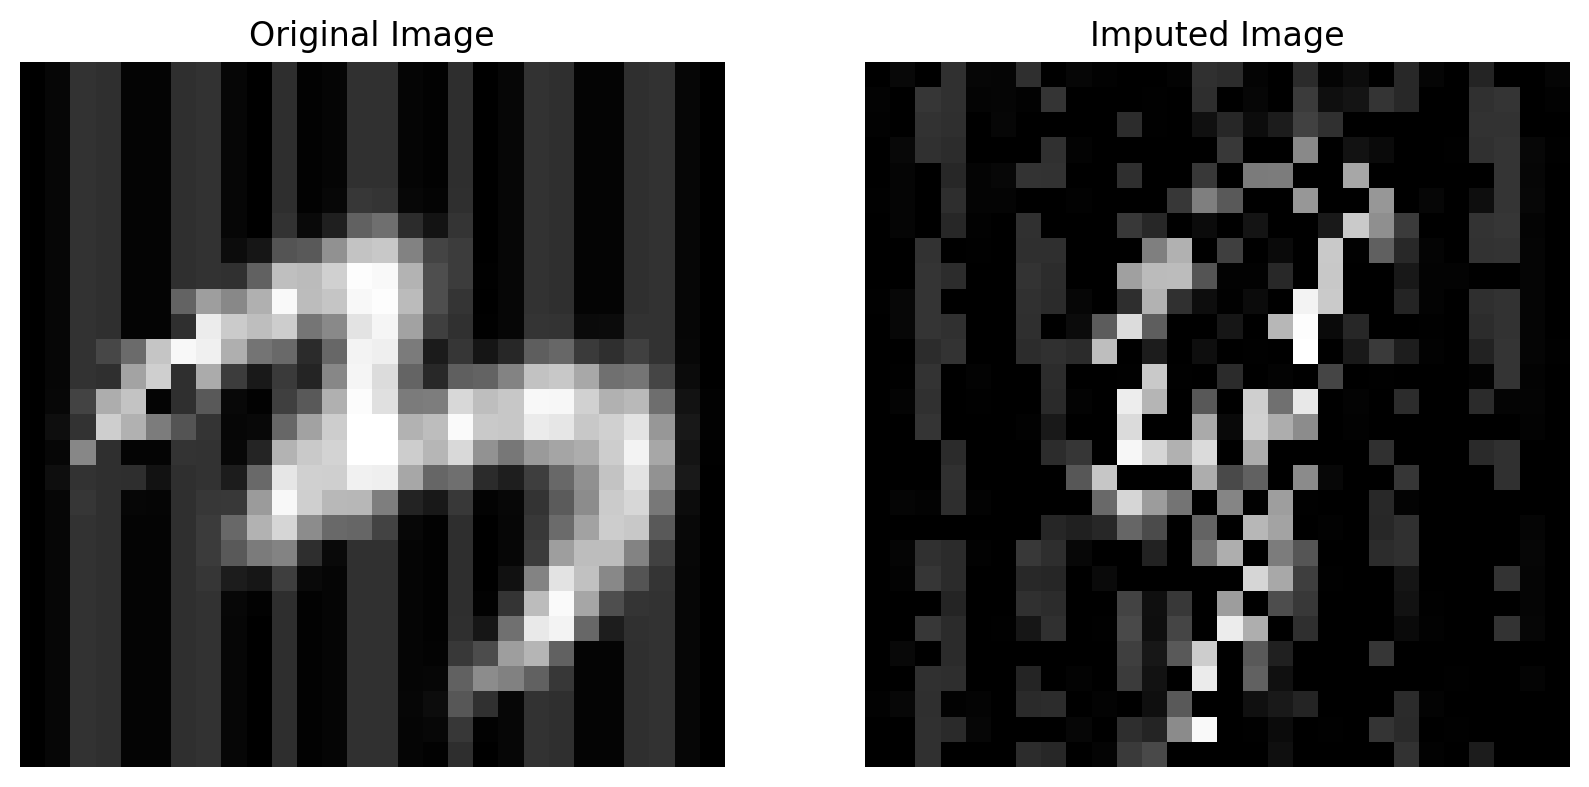


Sample 3:
Mean Squared Error (MSE): 0.1377
Structural Similarity Index (SSIM): 0.1948
Peak Signal-to-Noise Ratio (PSNR): 56.7428 dB


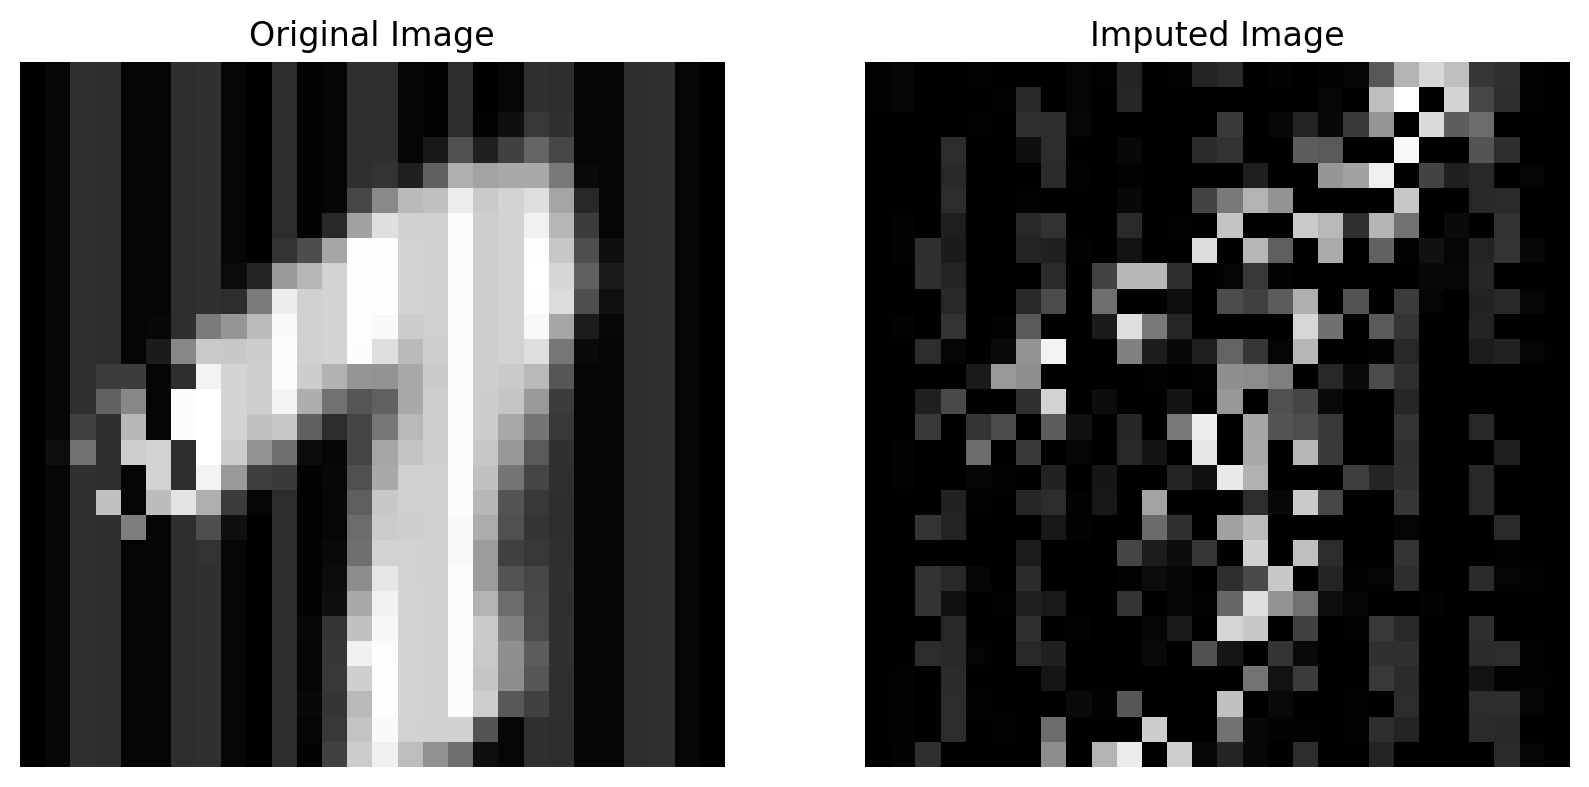


Sample 4:
Mean Squared Error (MSE): 0.0865
Structural Similarity Index (SSIM): 0.1437
Peak Signal-to-Noise Ratio (PSNR): 58.7609 dB


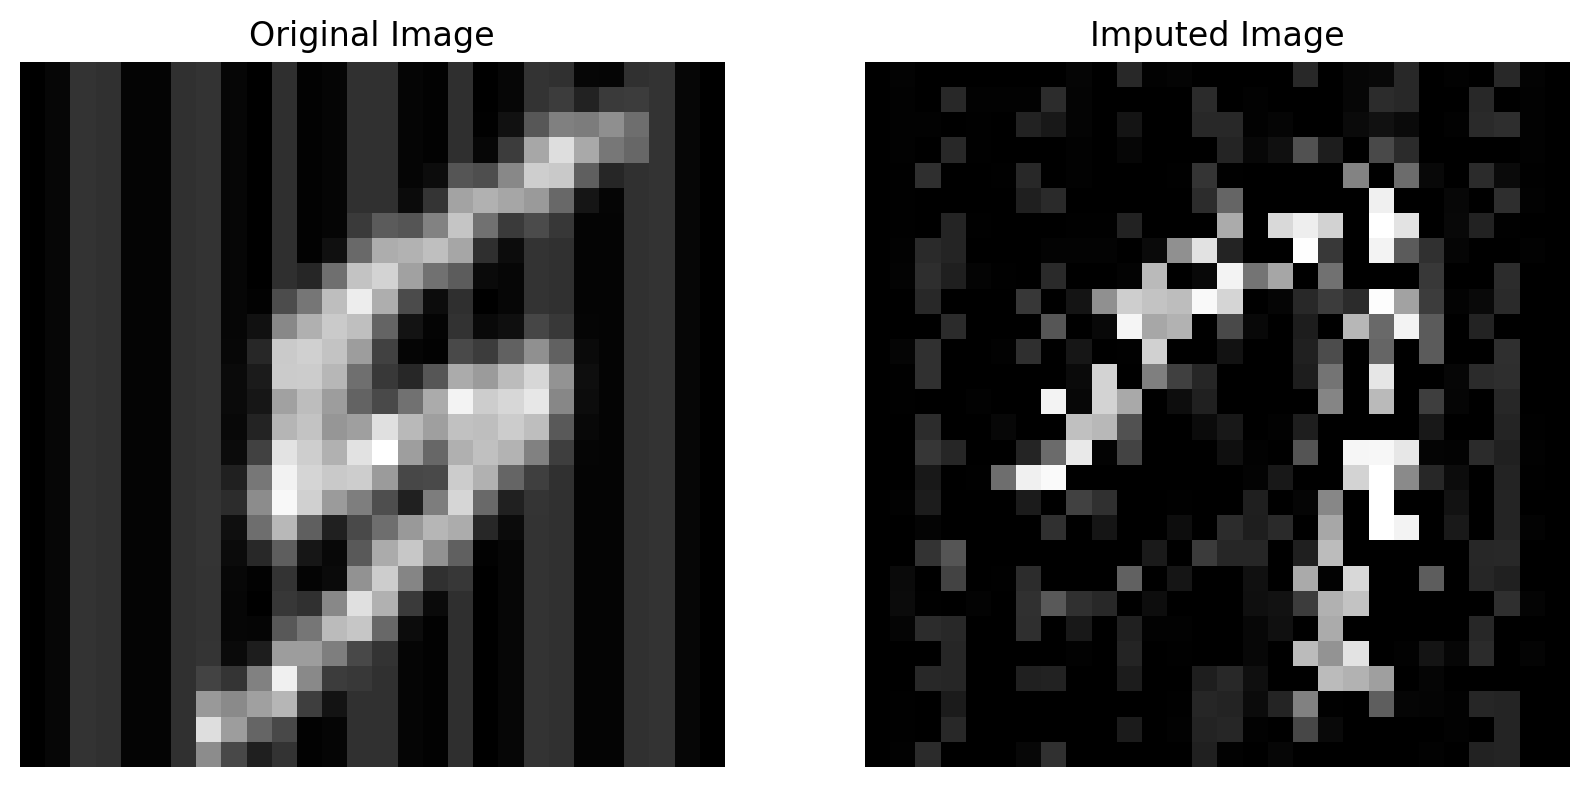


Sample 5:
Mean Squared Error (MSE): 0.0809
Structural Similarity Index (SSIM): 0.0827
Peak Signal-to-Noise Ratio (PSNR): 59.0501 dB


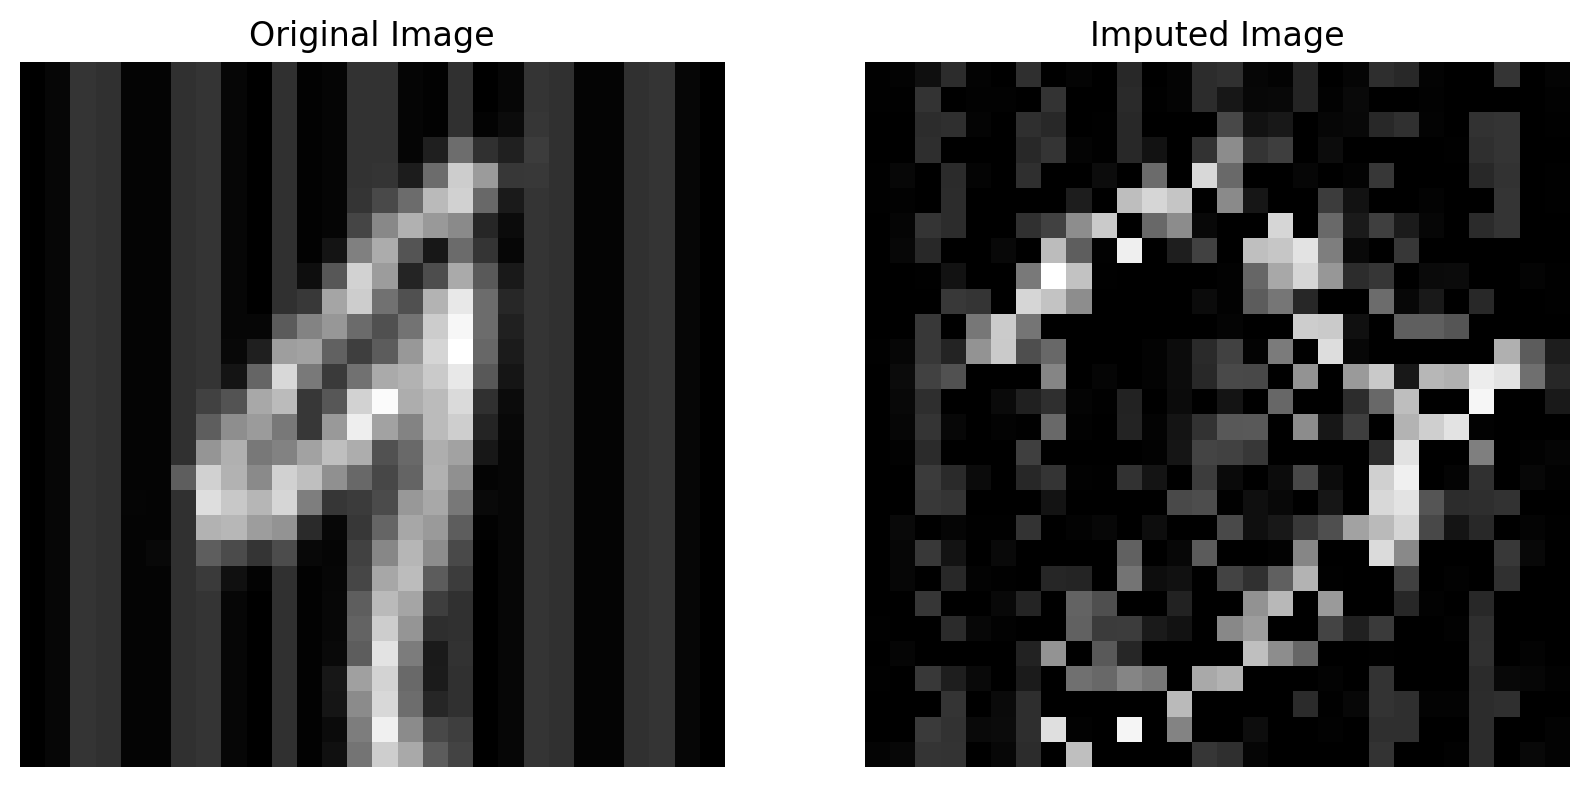

In [89]:
plot_interval = 20
critic_updates = 0

for epoch in range(300):
    for real_data, real_mask in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        # Update discriminators' parameters
        data_noise.normal_()
        mask_noise.normal_()

        fake_data = data_gen(data_noise)
        fake_mask = mask_gen(mask_noise)

        masked_fake_data = mask_data(fake_data, fake_mask)
        masked_real_data = mask_data(real_data, real_mask)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)

            data_gen.zero_grad()
            mask_gen.zero_grad()

            data_noise.normal_()
            mask_noise.normal_()

            fake_data = data_gen(data_noise)
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data.clone(), fake_mask.clone())

            data_loss = -data_critic(masked_fake_data).mean()
            data_loss.backward(retain_graph=True)
            data_gen_optimizer.step()

            mask_loss = -mask_critic(fake_mask).mean()
            total_loss = mask_loss + data_loss.detach() * alpha
            total_loss.backward()
            mask_gen_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)

    # Visualization and evaluation at the plot_interval
    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        data_gen.eval()
        mask_gen.eval()

        with torch.no_grad():
            print('Epoch:', epoch)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))

            # Generate fake data and masks
            data_noise.normal_()
            data_samples = data_gen(data_noise)
            plot_grid(ax1, data_samples, title='Generated Complete Data')

            mask_noise.normal_()
            mask_samples = mask_gen(mask_noise)
            plot_grid(ax2, mask_samples, title='Generated Masks')

            plt.show()
            plt.close(fig)

            # Evaluation of imputation
            original_images = real_data.cpu().numpy()  # Original real images
            imputed_images = masked_fake_data.cpu().numpy()  # Generated images

            # For each original and imputed image pair, evaluate the metrics
            for i in range(min(5, len(original_images))):  # Evaluating a few samples (adjust the range as needed)
                original = original_images[i].squeeze()  # Remove channel dim if needed
                imputed = imputed_images[i].squeeze()

                mse_value = mean_squared_error_metric(original, imputed)
                ssim_value = structural_similarity_index(original, imputed)
                psnr_value = peak_signal_to_noise_ratio(original, imputed)

                print(f'\nSample {i + 1}:')
                print(f'Mean Squared Error (MSE): {mse_value:.4f}')
                print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')
                print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')

                visualize_images(original, imputed)  # Display the original vs imputed image

        data_gen.train()
        mask_gen.train()


## Missing data imputation

### Imputer

In [55]:
class Imputer(nn.Module):
    def __init__(self, arch=(512, 512)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], 784),
        )

    def forward(self, data, mask, noise):
        net = data * mask + noise * (1 - mask)
        net = net.view(data.shape[0], -1)
        net = self.fc(net)
        net = torch.sigmoid(net).view(data.shape)
        return data * mask + net * (1 - mask)

Now we instantiate the imputer and the corresponding discriminator. We also use the Adam optimizer to train them.
Note that for MisGAN imputation, we will re-use most of the components created earlier for MisGAN including the data/mask generators and the discriminators.

In [56]:
imputer = Imputer().to(device)
impu_critic = ConvCritic().to(device)
impu_noise = torch.empty(batch_size, 1, 28, 28, device=device)

imputer_lrate = 2e-4
imputer_optimizer = optim.Adam(
    imputer.parameters(), lr=imputer_lrate, betas=(.5, .9))
impu_critic_optimizer = optim.Adam(
    impu_critic.parameters(), lr=imputer_lrate, betas=(.5, .9))
update_impu_critic = CriticUpdater(
    impu_critic, impu_critic_optimizer, batch_size)

### Training MisGAN Imputer

In [58]:
output_dir = r'C:\Users\Asus\OneDrive\Escritorio\TUe\Research Topics in Data Mining\Assignment 3\imputed_mnist'
os.makedirs(output_dir, exist_ok=True) 

In [ ]:
# beta = 0.1
# plot_interval = 100
# critic_updates = 0

# for epoch in range(600):
#     for real_data, real_mask, index in data_loader: # CHANGE index
#         real_data = real_data.to(device)
#         real_mask = real_mask.to(device).float()

#         masked_real_data = mask_data(real_data, real_mask)

#         # Update discriminators' parameters
#         data_noise.normal_()
#         fake_data = data_gen(data_noise)

#         mask_noise.normal_()
#         fake_mask = mask_gen(mask_noise)

#         with torch.no_grad():
#             masked_fake_data = mask_data(fake_data.detach(), fake_mask.detach())

#         impu_noise.uniform_()
#         imputed_data = imputer(real_data, real_mask, impu_noise)

#         update_data_critic(masked_real_data, masked_fake_data)
#         update_mask_critic(real_mask, fake_mask)
#         update_impu_critic(fake_data, imputed_data)

#         critic_updates += 1

#         if critic_updates == n_critic:
#             critic_updates = 0

#             # Update generators' parameters
#             for p in data_critic.parameters():
#                 p.requires_grad_(False)
#             for p in mask_critic.parameters():
#                 p.requires_grad_(False)
#             for p in impu_critic.parameters():
#                 p.requires_grad_(False)

#             data_noise.normal_()
#             fake_data = data_gen(data_noise)

#             mask_noise.normal_()
#             fake_mask = mask_gen(mask_noise)

#             with torch.no_grad():
#                 masked_fake_data = mask_data(fake_data.detach(), fake_mask.detach())

#             impu_noise.uniform_()
#             imputed_data = imputer(real_data, real_mask, impu_noise)

#             data_loss = -data_critic(masked_fake_data).mean()
#             mask_loss = -mask_critic(fake_mask).mean()
#             impu_loss = -impu_critic(imputed_data).mean()

#             mask_gen.zero_grad()
#             mask_total_loss = mask_loss + data_loss * alpha
#             mask_total_loss.backward(retain_graph=True)
#             mask_gen_optimizer.step()

#             data_gen.zero_grad()
#             data_total_loss = data_loss + impu_loss * beta
#             data_total_loss.backward(retain_graph=True)
#             data_gen_optimizer.step()

#             imputer.zero_grad()
#             impu_loss.backward()
#             imputer_optimizer.step()

#             for p in data_critic.parameters():
#                 p.requires_grad_(True)
#             for p in mask_critic.parameters():
#                 p.requires_grad_(True)
#             for p in impu_critic.parameters():
#                 p.requires_grad_(True)

#     if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
#         with torch.no_grad():
#             imputer.eval()

#             # Plot imputation results
#             impu_noise.uniform_()
#             imputed_data = imputer(real_data, real_mask, impu_noise)
#             bbox = [dataset.mask_loc[idx] for idx in index] # CHANGE index
#             print('Epoch:', epoch)
#             fig, ax = plt.subplots(figsize=(6, 3))
#             plot_grid(ax, imputed_data, bbox, gap=2)
#             save_path = os.path.join(output_dir, f'imputed_epoch_{epoch+1}.png')
#             plt.savefig(save_path)
#             plt.show()
#             plt.close(fig)

#             imputer.train()

In [74]:
beta = 0.1
plot_interval = 1
critic_updates = 0

for epoch in range(600):
    for batch_num, (real_data, real_mask) in enumerate(data_loader):  # Use batch_num instead of index
        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        masked_real_data = mask_data(real_data, real_mask)

        # Update discriminators' parameters
        data_noise.normal_()
        fake_data = data_gen(data_noise)

        mask_noise.normal_()
        fake_mask = mask_gen(mask_noise)

        with torch.no_grad():
            masked_fake_data = mask_data(fake_data.detach(), fake_mask.detach())

        impu_noise.uniform_()
        imputed_data = imputer(real_data, real_mask, impu_noise)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)
        update_impu_critic(fake_data, imputed_data)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)
            for p in impu_critic.parameters():
                p.requires_grad_(False)

            data_noise.normal_()
            fake_data = data_gen(data_noise)

            mask_noise.normal_()
            fake_mask = mask_gen(mask_noise)

            with torch.no_grad():
                masked_fake_data = mask_data(fake_data.detach(), fake_mask.detach())

            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)

            data_loss = -data_critic(masked_fake_data).mean()
            mask_loss = -mask_critic(fake_mask).mean()
            impu_loss = -impu_critic(imputed_data).mean()

            mask_gen.zero_grad()
            mask_total_loss = mask_loss + data_loss * alpha
            mask_total_loss.backward(retain_graph=True)
            mask_gen_optimizer.step()

            data_gen.zero_grad()
            data_total_loss = data_loss + impu_loss * beta
            data_total_loss.backward(retain_graph=True)
            data_gen_optimizer.step()

            imputer.zero_grad()
            impu_loss.backward()
            imputer_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)
            for p in impu_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        with torch.no_grad():
            imputer.eval()

            # Plot imputation results
            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)
            bbox = [dataset.mask_loc[batch_num] for _ in range(len(real_data))] 
            print('Epoch:', epoch)
            fig, ax = plt.subplots(figsize=(6, 3))
            plot_grid(ax, imputed_data, bbox, gap=2)
            save_path = os.path.join(output_dir, f'imputed_epoch_{epoch+1}_batch_{batch_num}.png')  
            evaluate_images(image_dir, save_path)
            plt.savefig(save_path)
            plt.show()
            plt.close(fig)

            imputer.train()


AttributeError: 'TransformedMNISTDataset' object has no attribute 'mask_loc'